In [2]:
%load_ext autoreload
%autoreload 2

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt
import time
import napari

In [3]:
os.chdir('/home/ali/packages/s2p-lbm/')

from suite3d.job import Job
from suite3d import lbmio, utils, ui
from suite3d import tiff_utils as tfu
from suite3d import file_utils as flu

In [4]:
job_params = {    
    'notch_filt' :     None,
    'planes' :         n.concatenate([n.arange(0,30,2), n.arange(1,31,2)]),
    'n_ch_tif' : 26,
    'convert_plane_ids_to_channel_ids' : False,
    
    'n_init_files' :   1,
    'init_file_pool' : None,
    'init_file_sample_method': 'random',
    
    'subtract_crosstalk' : True,
    'override_crosstalk' : 0.13,
    'crosstalk_n_planes' : 10, 
    
    'nonrigid' : True,
    'smooth_sigma' : 1.15,
    'maxregshift' : 0.15,
    'reg_filter_pcorr' : 1,
    'generate_sample_registered_bins' : False,

    'dtype' : n.float32,
    'tif_batch_size' : 1,
}



In [5]:
subjects_dir =   '/mnt/zortex-subjects/'
expt_info = { 
    'subject':         'AH012',
    'date' :          '2024-06-04',
    'expnum' :         [3,6],}

tifs, si_params, exp_str = flu.find_exp(subjects_dir, **expt_info, verbose=False)

job_params['fs'] = si_params['vol_rate']

job_params['fix_fastZ'] = 0
savedir = os.path.join('/mnt/md0/runs', expt_info['subject'], expt_info['date'])
os.makedirs(savedir, exist_ok=True)

# Create the job
job = Job('/mnt/md0/runs',exp_str, tifs = tifs,
          params=job_params, create=False, overwrite=True, verbosity = 100)

job.params['planes'] = n.array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22,  1,  3,
         5,  7,  9, 11, 13, 15, 17])
job.params['3d_reg'] = True
job.params['fuse_shift_override'] = 6
job.params['n_init_files'] = 1
job.params['init_n_frames'] = 400
job.params['cavity_size'] = 12
job.verbosity = 100

   Found and loaded params from /mnt/md0/runs/s3d-AH012_2024-06-04_3-6/params.npy


   Saved a copy of params at /mnt/md0/runs/s3d-AH012_2024-06-04_3-6/summary
   Updated main params file
Launching initial pass
Saving summary to /mnt/md0/runs/s3d-AH012_2024-06-04_3-6/summary/summary.npy
   Loading init tifs with 26 channels
      Loading /mnt/zortex-subjects/AH012/2024-06-04/3/2024-06-04_3_AH012_2P_00001_00046.tif
   Loaded 1 files, total 2.82 GB
   Not enough frames in loaded tifs - using 100 init frames instead
   Loaded movie with 100 frames and shape 21, 1000, 720
      Enforcing positivity in mean image
   Subtracting crosstalk with forced coefficient 0.130
         Subtracting plane 0 from 12
         Subtracting plane 1 from 13
         Subtracting plane 2 from 14
         Subtracting plane 3 from 15
         Subtracting plane 4 from 16
         Subtracting plane 5 from 17
         Subtracting plane 6 from 18
         Subtracting plane 7 from 19
         Subtracting plane 8 from 20
   Saved init mov to /mnt/md0/runs/s3d-AH012_2024-06-04_3-6/summary/init_mov.npy

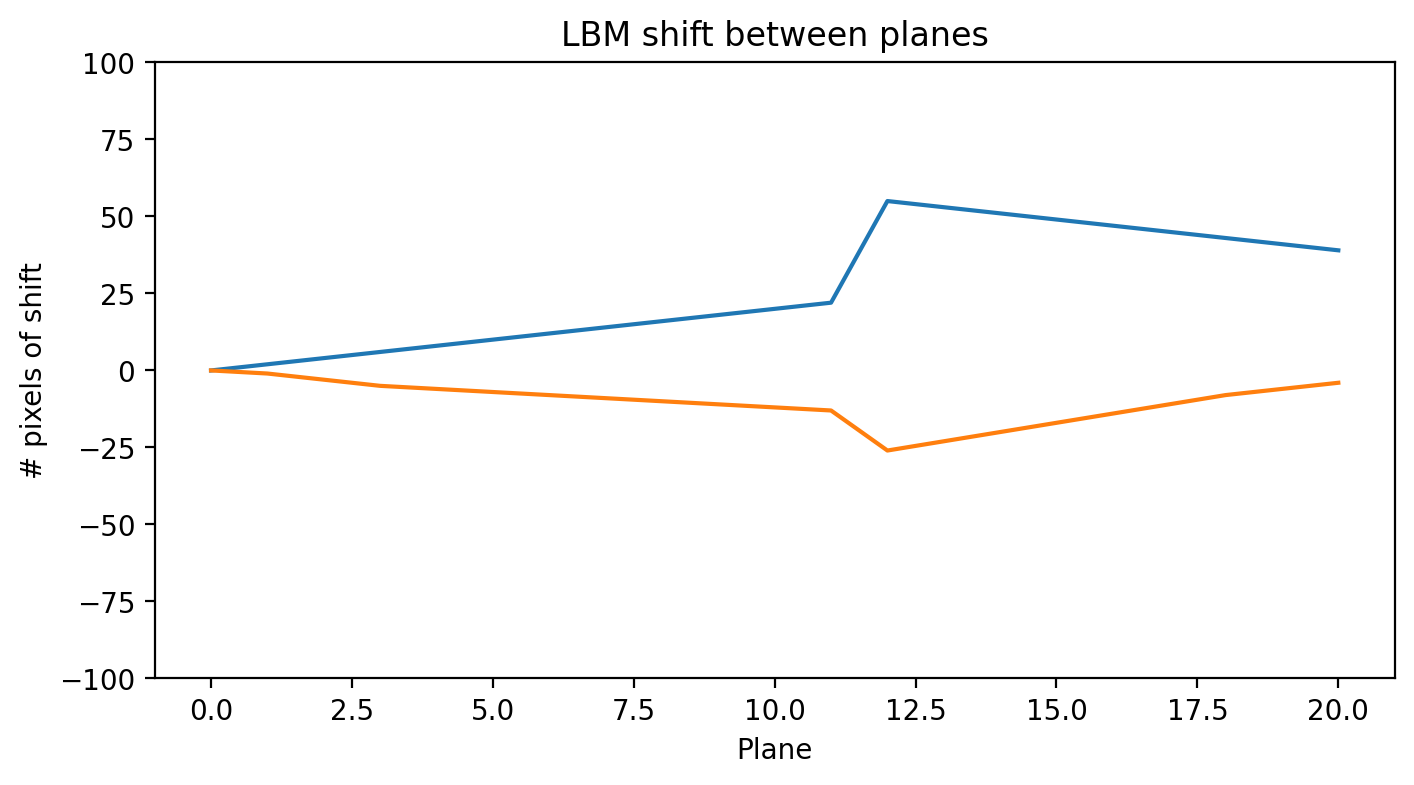

In [6]:
%%time
n.random.seed(10)
summary = job.run_init_pass()

In [6]:
summary = job.load_summary()

In [7]:
ref_vol = summary['ref_img_3d']

In [8]:
sig_range_high = n.percentile(ref_vol, 99.99, axis=(1,2))
sig_range_low = n.percentile(ref_vol, 25, axis=(1,2))

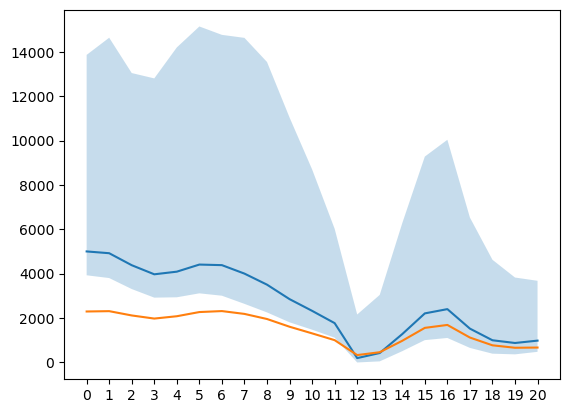

In [11]:
nz, ny, nx = ref_vol.shape

plt.plot(n.arange(nz),ref_vol.mean(axis=(1,2)))
plt.fill_between(n.arange(nz),sig_range_low, sig_range_high, alpha=0.25)
plt.plot(n.arange(nz),ref_vol.std(axis=(1,2)))
plt.xticks(n.arange(nz));

In [12]:
init_mov = n.load(os.path.join(job.dirs['summary'],'init_mov.npy'))

init_mean = init_mov.mean(axis=1)
init_std = init_mov.std(axis=1)
nz,ny,nx = init_mean.shape

pcts = n.array([n.percentile(init_std[i].flatten(), 98)  for i in range(nz)])

top_pix = [init_std[i] > pcts[i] for i in range(nz)]

top_pix_movs = n.array([init_mov[i][:,top_pix[i]] for i in range(nz)])

ff = top_pix_movs
df = n.diff(ff, axis=1)
dff = df / ff.mean(axis=1,keepdims=True)
abs_d_dff = n.abs(n.diff(dff,axis=1))
noise_level = n.nanmedian(abs_d_dff, axis=1)
noise_level = noise_level / job.params['fs']

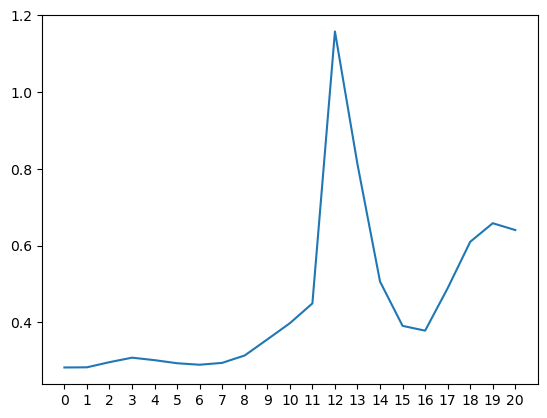

In [15]:
plt.plot(n.arange(nz), noise_level.mean(axis=1))
plt.xticks(n.arange(nz));

In [198]:
job.register_gpu_3d(tifs = job.tifs[10:15])

      Found dir /mnt/md0/runs/s3d-AH012_2024-05-17_1/registered_fused_data
      Updating self.dirs tag registered_fused_data
   Overriding fuse shift value to 6
   Not clipping frames for registration
Will analyze 5 tifs in 5 batches
   Enforcing positivity
   Launching IO thread
               [Thread] Loading batch 0 

         Memory at batch 0.  Total Used: 052.723 GB, Virtual Available: 450.540 GB, Virtual Used: 052.656 GB, Swap Used: 000.067 GB
Loading Batch 0 of 4
                  [Thread] Before load 0 
Total Used: 052.723 GB, Virtual Available: 450.540 GB, Virtual Used: 052.656 GB, Swap Used: 000.067 GB
      Loading /mnt/zortex-subjects/AH012/2024-05-17/1/2024-05-17_1_AH012_2P_00001_00011.tif


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.70 GB
               [Thread] Thread for batch 0 ready to join after 24.19 sec 

                  [Thread] After load 0 
Total Used: 055.436 GB, Virtual Available: 447.826 GB, Virtual Used: 055.369 GB, Swap Used: 000.067 GB
   Batch 0 IO thread joined
         Memory after IO thread joinTotal Used: 055.436 GB, Virtual Available: 447.826 GB, Virtual Used: 055.369 GB, Swap Used: 000.067 GB
         Memory after movie copied from threadTotal Used: 058.144 GB, Virtual Available: 445.119 GB, Virtual Used: 058.076 GB, Swap Used: 000.067 GB
         Memory after thread memory clearedTotal Used: 055.433 GB, Virtual Available: 447.830 GB, Virtual Used: 055.365 GB, Swap Used: 000.067 GB
   Launching IO thread for next batch
               [Thread] Loading batch 1 

         After IO thread launch:Total Used: 055.433 GB, Virtual Available: 447.830 GB, Virtual Used: 055.365 GB, Swap Used: 000.067 GB
      Loaded batch of size (18, 100, 800, 1008)
                  [Thre

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.70 GB
               [Thread] Thread for batch 1 ready to join after 26.70 sec 

                  [Thread] After load 1 
Total Used: 061.494 GB, Virtual Available: 441.768 GB, Virtual Used: 061.427 GB, Swap Used: 000.067 GB
   Batch 1 IO thread joined
         Memory after IO thread joinTotal Used: 061.494 GB, Virtual Available: 441.768 GB, Virtual Used: 061.427 GB, Swap Used: 000.067 GB
         Memory after movie copied from threadTotal Used: 061.496 GB, Virtual Available: 441.767 GB, Virtual Used: 061.428 GB, Swap Used: 000.067 GB
         Memory after thread memory clearedTotal Used: 058.796 GB, Virtual Available: 444.467 GB, Virtual Used: 058.729 GB, Swap Used: 000.067 GB
   Launching IO thread for next batch
               [Thread] Loading batch 2 

         After IO thread launch:Total Used: 058.796 GB, Virtual Available: 444.467 GB, Virtual Used: 058.729 GB, Swap Used: 000.067 GB
                  [Thread] Before load 2 
Total Used: 058.796 GB, Virtu

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.70 GB
               [Thread] Thread for batch 2 ready to join after 22.18 sec 

                  [Thread] After load 2 
Total Used: 061.366 GB, Virtual Available: 441.896 GB, Virtual Used: 061.299 GB, Swap Used: 000.067 GB
   Batch 2 IO thread joined
         Memory after IO thread joinTotal Used: 061.358 GB, Virtual Available: 441.904 GB, Virtual Used: 061.291 GB, Swap Used: 000.067 GB
         Memory after movie copied from threadTotal Used: 061.358 GB, Virtual Available: 441.904 GB, Virtual Used: 061.291 GB, Swap Used: 000.067 GB
         Memory after thread memory clearedTotal Used: 058.656 GB, Virtual Available: 444.606 GB, Virtual Used: 058.589 GB, Swap Used: 000.067 GB
   Launching IO thread for next batch
               [Thread] Loading batch 3 

         After IO thread launch:Total Used: 058.656 GB, Virtual Available: 444.606 GB, Virtual Used: 058.589 GB, Swap Used: 000.067 GB
                  [Thread] Before load 3 
Total Used: 058.656 GB, Virtu

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.70 GB
               [Thread] Thread for batch 3 ready to join after 22.92 sec 

                  [Thread] After load 3 
Total Used: 061.343 GB, Virtual Available: 441.920 GB, Virtual Used: 061.275 GB, Swap Used: 000.067 GB
   Batch 3 IO thread joined
         Memory after IO thread joinTotal Used: 061.343 GB, Virtual Available: 441.920 GB, Virtual Used: 061.275 GB, Swap Used: 000.067 GB
         Memory after movie copied from threadTotal Used: 061.343 GB, Virtual Available: 441.920 GB, Virtual Used: 061.275 GB, Swap Used: 000.067 GB
         Memory after thread memory clearedTotal Used: 058.630 GB, Virtual Available: 444.633 GB, Virtual Used: 058.563 GB, Swap Used: 000.067 GB
   Launching IO thread for next batch
               [Thread] Loading batch 4 

         After IO thread launch:Total Used: 058.630 GB, Virtual Available: 444.633 GB, Virtual Used: 058.563 GB, Swap Used: 000.067 GB
      Loaded batch of size (18, 100, 800, 1008)
                  [Thre

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.70 GB
               [Thread] Thread for batch 4 ready to join after 22.58 sec 

                  [Thread] After load 4 
Total Used: 061.311 GB, Virtual Available: 441.952 GB, Virtual Used: 061.243 GB, Swap Used: 000.067 GB
   Batch 4 IO thread joined
         Memory after IO thread joinTotal Used: 061.311 GB, Virtual Available: 441.952 GB, Virtual Used: 061.243 GB, Swap Used: 000.067 GB
         Memory after movie copied from threadTotal Used: 061.310 GB, Virtual Available: 441.953 GB, Virtual Used: 061.242 GB, Swap Used: 000.067 GB
         Memory after thread memory clearedTotal Used: 058.600 GB, Virtual Available: 444.663 GB, Virtual Used: 058.533 GB, Swap Used: 000.067 GB
      Loaded batch of size (18, 100, 800, 1008)
   Completed rigid reg on batch in :3.3380930423736572s
   Shifted the mov in: 0.8510715961456299s
         After all GPU Batches:Total Used: 061.311 GB, Virtual Available: 441.951 GB, Virtual Used: 061.244 GB, Swap Used: 000.067 GB
     

In [220]:
job.params['sdnorm_exp'] = 0.8
job.params['intensity_thresh'] = 0.0
job.params['cell_filt_xy_um'] = 3.0
job.params['npil_filt_xy_um'] = 10.0

In [222]:
__ = job.calculate_corr_map()

      Found dir /mnt/md0/runs/s3d-AH012_2024-05-17_1/corrmap
      Updating self.dirs tag corrmap
      Found dir /mnt/md0/runs/s3d-AH012_2024-05-17_1/mov_sub
      Updating self.dirs tag mov_sub
   Saved a copy of params at /mnt/md0/runs/s3d-AH012_2024-05-17_1/corrmap
   Updated main params file
   Computing correlation map of movie with 500 frames, volume shape: 18, 800, 1008
      Running batch 1 of 3
         Loading movie into shared memory
         Subtracting neuropil and applying cell filters
         Reducing filtered movie to compute correlation map
      Running batch 2 of 3
         Loading movie into shared memory
         Subtracting neuropil and applying cell filters
         Reducing filtered movie to compute correlation map
      Running batch 3 of 3
         Loading movie into shared memory
         Subtracting neuropil and applying cell filters
         Reducing filtered movie to compute correlation map


In [6]:
results = job.load_corr_map_results()

In [12]:
mov_full = job.get_registered_movie('registered_fused_data', 'fused')
im_full = mov_full[:,:200].mean(axis=1).compute()

In [18]:
job.params['t_batch_size'] = 400
job.params['voxel_size_um'] = (15, 2.5, 2.5)
job.params['npil_filt_type'] = 'unif'
job.params['npil_filt_xy_um'] = 70
job.params['npil_filt_z_um'] = 15.0
job.params['cell_filt_type'] = 'unif'
job.params['cell_filt_xy_um'] = 2.5
job.params['cell_filt_z_um'] = 15.0
job.params['edge_crop_npix'] = 7
job.params['fix_vmap_edge_planes'] = True
job.params['sdnorm_exp'] = 0.85
job.params['intensity_thresh'] = 0.1
job.params['n_proc'] = 32

params_to_sweep = { 
    'cell_filt_xy_um': [2.5, 5.0, 10.0],
    'intensity_thresh' : [0.1, 0.3],
    'sdnorm_exp' : [0.85, 1.0]
}
mov_full = job.get_registered_movie('registered_fused_data', 'fused')
sweep_summary = job.sweep_corrmap(params_to_sweep, mov = mov_full[:,:100],all_combinations=True)

   Setting up sweep
   Created dir /mnt/md0/runs/s3d-AH012_2024-05-17_1/sweeps with tag sweeps
      Updating self.dirs tag sweeps
   Created dir /mnt/md0/runs/s3d-AH012_2024-05-17_1/sweeps/corrmap with tag sweeps-corrmap
      Updating self.dirs tag sweeps-corrmap
   Total of 12 combinations
      Created directory for comb_00000 with params comb00000-params-cell_filt_xy_um_2.500-intensity_thresh_0.100-sdnorm_exp_0.850
   Created dir /mnt/md0/runs/s3d-AH012_2024-05-17_1/sweeps/corrmap/comb_00000 with tag sweeps-corrmap-comb_00000
      Updating self.dirs tag sweeps-corrmap-comb_00000
      Created directory for comb_00001 with params comb00001-params-cell_filt_xy_um_2.500-intensity_thresh_0.100-sdnorm_exp_1.000
   Created dir /mnt/md0/runs/s3d-AH012_2024-05-17_1/sweeps/corrmap/comb_00001 with tag sweeps-corrmap-comb_00001
      Updating self.dirs tag sweeps-corrmap-comb_00001
      Created directory for comb_00002 with params comb00002-params-cell_filt_xy_um_2.500-intensity_thresh_0.3

         Reducing filtered movie to compute correlation map
      Overwriting existing /mnt/md0/runs/s3d-AH012_2024-05-17_1/sweeps/corrmap/sweep_summary.npy
Running combination 06/12
   Created dir /mnt/md0/runs/s3d-AH012_2024-05-17_1/sweeps/corrmap/comb_00005/corrmap with tag sweeps-corrmap-comb_00005-corrmap
      Updating self.dirs tag sweeps-corrmap-comb_00005-corrmap
   Created dir /mnt/md0/runs/s3d-AH012_2024-05-17_1/sweeps/corrmap/comb_00005/mov_sub with tag sweeps-corrmap-comb_00005-mov_sub
      Updating self.dirs tag sweeps-corrmap-comb_00005-mov_sub
   Saved a copy of params at /mnt/md0/runs/s3d-AH012_2024-05-17_1/sweeps/corrmap/comb_00005/corrmap
   Updated main params file
   Computing correlation map of movie with 100 frames, volume shape: 18, 800, 1008
      Running batch 1 of 1
         Loading movie into shared memory
         Subtracting neuropil and applying cell filters
         Reducing filtered movie to compute correlation map
      Overwriting existing /mnt/md0/r

(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f6a03862370>)

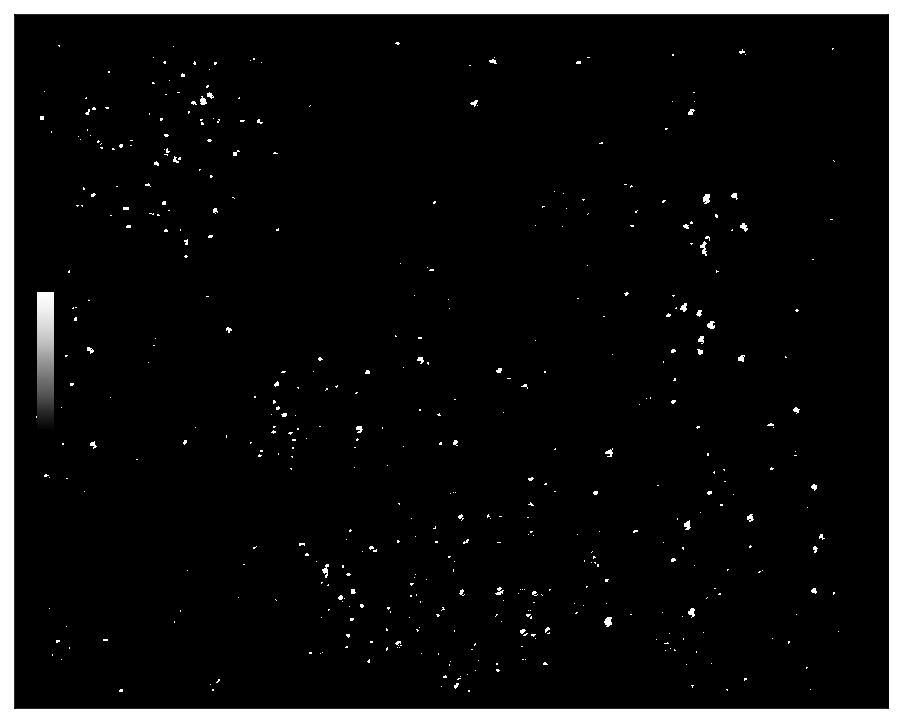

In [9]:
tfu.show_tif(results['vmap'][14], cbar=True, vminmax=(0.4999,0.5))

In [10]:
%%time
job.params['detection_timebin'] = 1 
job.params['detection_time_crop'] = (None,None)
job.params['max_pix'] = 250
job.params['peak_thresh'] = 0.50

job.params['activity_thresh'] = 1.0
job.params['percentile'] = 98.0
job.params['extend_thresh'] = 0.15
job.params['max_iter'] = 10000 # maximum number of ROIs detected in given patch
combined_dir = job.segment_rois()

      Found dir /mnt/md0/runs/s3d-AH012_2024-05-17_1/segmentation
      Updating self.dirs tag segmentation
   Saved a copy of params at /mnt/md0/runs/s3d-AH012_2024-05-17_1/segmentation
   Updated main params file
      Found dir /mnt/md0/runs/s3d-AH012_2024-05-17_1/rois
      Updating self.dirs tag rois
   Saving results to /mnt/md0/runs/s3d-AH012_2024-05-17_1/segmentation and /mnt/md0/runs/s3d-AH012_2024-05-17_1/rois 
dict_keys(['max_img', 'mean_img', 'vmap', 'all_params'])
   Detecting from patch 1 / 99
      Found dir /mnt/md0/runs/s3d-AH012_2024-05-17_1/segmentation/patch-0000
         Loading 0.48 GB movie to memory, shape: (500, 18, 120, 120) 
         Loaded
         Loading movie patch to shared memory
         Loaded
      Starting extraction with peak_thresh: 0.500 and Th2: 1.000
         Iter 0000: running 08 ROIs in parallel
         Added cell 1 at 12, 093, 071, peak: 0.917, thresh: 1.000, 140 frames, 13 pixels
         Added cell 2 at 01, 072, 100, peak: 0.795, thresh: 

         Added cell 81 at 03, 089, 098, peak: 0.514, thresh: 1.000, 185 frames, 13 pixels
         Added cell 82 at 00, 078, 103, peak: 0.513, thresh: 1.000, 188 frames, 15 pixels
         Added cell 83 at 07, 076, 083, peak: 0.513, thresh: 1.000, 180 frames, 9 pixels
         Added cell 84 at 03, 075, 062, peak: 0.512, thresh: 1.000, 192 frames, 13 pixels
         Added cell 85 at 00, 059, 066, peak: 0.511, thresh: 1.000, 189 frames, 10 pixels
         Added cell 86 at 07, 098, 088, peak: 0.510, thresh: 1.000, 196 frames, 14 pixels
         Added cell 87 at 03, 068, 101, peak: 0.509, thresh: 1.000, 188 frames, 13 pixels
         Added cell 88 at 15, 065, 039, peak: 0.507, thresh: 1.000, 182 frames, 15 pixels
         Iter 0011: running 08 ROIs in parallel
         Added cell 89 at 04, 078, 065, peak: 0.507, thresh: 1.000, 184 frames, 18 pixels
         Added cell 90 at 16, 035, 053, peak: 0.507, thresh: 1.000, 179 frames, 12 pixels
         Added cell 91 at 05, 077, 073, peak: 0.506, 

         Added cell 65 at 01, 099, 147, peak: 0.590, thresh: 1.000, 182 frames, 15 pixels
         Added cell 66 at 03, 034, 176, peak: 0.590, thresh: 1.000, 190 frames, 19 pixels
         Added cell 67 at 00, 054, 158, peak: 0.590, thresh: 1.000, 188 frames, 15 pixels
         Added cell 68 at 15, 028, 134, peak: 0.589, thresh: 1.000, 183 frames, 10 pixels
         Added cell 69 at 02, 095, 183, peak: 0.588, thresh: 1.000, 192 frames, 12 pixels
         Added cell 70 at 03, 082, 180, peak: 0.588, thresh: 1.000, 184 frames, 16 pixels
         Added cell 71 at 01, 011, 183, peak: 0.588, thresh: 1.000, 186 frames, 9 pixels
         Added cell 72 at 02, 091, 157, peak: 0.587, thresh: 1.000, 189 frames, 10 pixels
         Iter 0009: running 08 ROIs in parallel
         Added cell 73 at 06, 082, 187, peak: 0.585, thresh: 1.000, 203 frames, 11 pixels
         Added cell 74 at 04, 030, 174, peak: 0.585, thresh: 1.000, 193 frames, 10 pixels
         Added cell 75 at 00, 068, 122, peak: 0.584, 

         Added cell 153 at 00, 013, 171, peak: 0.541, thresh: 1.000, 189 frames, 13 pixels
         Added cell 154 at 03, 085, 118, peak: 0.541, thresh: 1.000, 176 frames, 11 pixels
         Added cell 155 at 00, 074, 181, peak: 0.541, thresh: 1.000, 187 frames, 7 pixels
         Added cell 156 at 00, 089, 161, peak: 0.540, thresh: 1.000, 199 frames, 31 pixels
         Added cell 157 at 00, 047, 160, peak: 0.540, thresh: 1.000, 192 frames, 11 pixels
         Added cell 158 at 01, 058, 106, peak: 0.539, thresh: 1.000, 189 frames, 10 pixels
         Added cell 159 at 06, 085, 186, peak: 0.539, thresh: 1.000, 194 frames, 17 pixels
         Added cell 160 at 01, 078, 191, peak: 0.539, thresh: 1.000, 200 frames, 8 pixels
         Iter 0020: running 08 ROIs in parallel
         Added cell 161 at 14, 089, 188, peak: 0.539, thresh: 1.000, 172 frames, 13 pixels
         Added cell 162 at 02, 046, 155, peak: 0.538, thresh: 1.000, 193 frames, 14 pixels
         Added cell 163 at 12, 083, 155, pea

         Added cell 241 at 01, 048, 177, peak: 0.514, thresh: 1.000, 180 frames, 11 pixels
         Added cell 242 at 00, 015, 173, peak: 0.514, thresh: 1.000, 205 frames, 9 pixels
         Added cell 243 at 05, 049, 126, peak: 0.514, thresh: 1.000, 183 frames, 9 pixels
         Added cell 244 at 04, 080, 163, peak: 0.514, thresh: 1.000, 180 frames, 14 pixels
         Added cell 245 at 01, 039, 180, peak: 0.514, thresh: 1.000, 187 frames, 13 pixels
         Added cell 246 at 00, 085, 116, peak: 0.513, thresh: 1.000, 186 frames, 8 pixels
         Added cell 247 at 04, 099, 188, peak: 0.513, thresh: 1.000, 191 frames, 21 pixels
         Added cell 248 at 02, 047, 114, peak: 0.513, thresh: 1.000, 189 frames, 29 pixels
         Iter 0031: running 08 ROIs in parallel
         Added cell 249 at 01, 047, 149, peak: 0.513, thresh: 1.000, 179 frames, 11 pixels
         Added cell 250 at 03, 052, 117, peak: 0.513, thresh: 1.000, 178 frames, 8 pixels
         Added cell 251 at 00, 040, 107, peak:

         Added cell 329 at 15, 090, 191, peak: 0.501, thresh: 1.000, 186 frames, 13 pixels
         Added cell 330 at 01, 068, 171, peak: 0.501, thresh: 1.000, 185 frames, 10 pixels
         Added cell 331 at 02, 074, 191, peak: 0.501, thresh: 1.000, 196 frames, 8 pixels
         Added cell 332 at 06, 051, 130, peak: 0.501, thresh: 1.000, 180 frames, 13 pixels
         Added cell 333 at 02, 093, 185, peak: 0.500, thresh: 1.000, 170 frames, 8 pixels
         Added cell 334 at 00, 034, 105, peak: 0.500, thresh: 1.000, 187 frames, 9 pixels
         Added cell 335 at 02, 042, 184, peak: 0.500, thresh: 1.000, 192 frames, 25 pixels
      Iter 0042: peak is too small  - ending extraction
   Found 335 cells in 42 iterations
   Saving cells to /mnt/md0/runs/s3d-AH012_2024-05-17_1/segmentation/patch-0001/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-AH012_2024-05-17_1/segmentation/patch-0001/iscell.npy
   Detecting from patch 3 / 99
      Found dir /mnt/md0/runs/s3d-AH012_2024-05-17_1/segm

         Added cell 81 at 03, 101, 240, peak: 0.598, thresh: 1.000, 182 frames, 15 pixels
         Added cell 82 at 15, 042, 278, peak: 0.596, thresh: 1.000, 165 frames, 11 pixels
         Added cell 83 at 01, 014, 192, peak: 0.596, thresh: 1.000, 189 frames, 9 pixels
         Added cell 84 at 05, 034, 238, peak: 0.595, thresh: 1.000, 189 frames, 6 pixels
         Added cell 85 at 03, 047, 259, peak: 0.593, thresh: 1.000, 180 frames, 12 pixels
         Added cell 86 at 14, 093, 222, peak: 0.593, thresh: 1.000, 168 frames, 12 pixels
         Added cell 87 at 00, 009, 205, peak: 0.592, thresh: 1.000, 191 frames, 13 pixels
         Added cell 88 at 01, 101, 209, peak: 0.592, thresh: 1.000, 186 frames, 9 pixels
         Iter 0011: running 08 ROIs in parallel
         Added cell 89 at 04, 024, 231, peak: 0.591, thresh: 1.000, 179 frames, 8 pixels
         Added cell 90 at 14, 051, 275, peak: 0.590, thresh: 1.000, 166 frames, 10 pixels
         Added cell 91 at 01, 044, 192, peak: 0.590, thr

         Added cell 169 at 03, 089, 266, peak: 0.547, thresh: 1.000, 211 frames, 24 pixels
         Added cell 170 at 13, 070, 202, peak: 0.547, thresh: 1.000, 183 frames, 36 pixels
         Added cell 171 at 15, 071, 275, peak: 0.546, thresh: 1.000, 206 frames, 10 pixels
         Added cell 172 at 03, 033, 234, peak: 0.546, thresh: 1.000, 175 frames, 12 pixels
         Added cell 173 at 02, 035, 223, peak: 0.545, thresh: 1.000, 187 frames, 9 pixels
         Added cell 174 at 00, 071, 243, peak: 0.545, thresh: 1.000, 190 frames, 14 pixels
         Added cell 175 at 00, 100, 217, peak: 0.544, thresh: 1.000, 206 frames, 10 pixels
         Added cell 176 at 01, 068, 201, peak: 0.544, thresh: 1.000, 191 frames, 18 pixels
         Iter 0022: running 08 ROIs in parallel
         Added cell 177 at 03, 086, 266, peak: 0.544, thresh: 1.000, 191 frames, 9 pixels
         Added cell 178 at 02, 093, 230, peak: 0.544, thresh: 1.000, 195 frames, 15 pixels
         Added cell 179 at 13, 059, 205, pea

         Added cell 257 at 00, 098, 216, peak: 0.518, thresh: 1.000, 199 frames, 11 pixels
         Added cell 258 at 04, 049, 261, peak: 0.518, thresh: 1.000, 186 frames, 7 pixels
         Added cell 259 at 15, 066, 266, peak: 0.518, thresh: 1.000, 182 frames, 22 pixels
         Added cell 260 at 02, 099, 211, peak: 0.517, thresh: 1.000, 185 frames, 10 pixels
         Added cell 261 at 01, 082, 225, peak: 0.517, thresh: 1.000, 192 frames, 24 pixels
         Added cell 262 at 14, 071, 197, peak: 0.517, thresh: 1.000, 191 frames, 11 pixels
         Added cell 263 at 05, 071, 248, peak: 0.517, thresh: 1.000, 199 frames, 14 pixels
         Added cell 264 at 09, 040, 247, peak: 0.516, thresh: 1.000, 176 frames, 10 pixels
         Iter 0033: running 08 ROIs in parallel
         Added cell 265 at 15, 055, 192, peak: 0.516, thresh: 1.000, 181 frames, 12 pixels
         Added cell 266 at 05, 031, 230, peak: 0.516, thresh: 1.000, 200 frames, 9 pixels
         Added cell 267 at 11, 086, 233, pea

         Added cell 345 at 12, 099, 214, peak: 0.508, thresh: 1.000, 185 frames, 37 pixels
         Added cell 346 at 00, 012, 206, peak: 0.508, thresh: 1.000, 187 frames, 10 pixels
         Added cell 347 at 03, 045, 223, peak: 0.508, thresh: 1.000, 183 frames, 11 pixels
         Added cell 348 at 00, 092, 205, peak: 0.507, thresh: 1.000, 194 frames, 11 pixels
         Added cell 349 at 02, 086, 264, peak: 0.507, thresh: 1.000, 185 frames, 10 pixels
         Added cell 350 at 00, 088, 236, peak: 0.507, thresh: 1.000, 191 frames, 9 pixels
         Added cell 351 at 01, 101, 238, peak: 0.507, thresh: 1.000, 179 frames, 9 pixels
         Added cell 352 at 01, 057, 202, peak: 0.507, thresh: 1.000, 187 frames, 10 pixels
         Iter 0044: running 08 ROIs in parallel
         Added cell 353 at 13, 096, 216, peak: 0.507, thresh: 1.000, 199 frames, 21 pixels
         Added cell 354 at 06, 066, 194, peak: 0.507, thresh: 1.000, 191 frames, 13 pixels
         Added cell 355 at 03, 030, 213, pea

         Added cell 25 at 08, 098, 307, peak: 0.553, thresh: 1.000, 199 frames, 11 pixels
         Added cell 26 at 03, 088, 288, peak: 0.524, thresh: 1.000, 184 frames, 14 pixels
         Added cell 27 at 02, 092, 308, peak: 0.522, thresh: 1.000, 188 frames, 5 pixels
         Added cell 28 at 00, 093, 300, peak: 0.522, thresh: 1.000, 193 frames, 13 pixels
         Added cell 29 at 06, 080, 316, peak: 0.520, thresh: 1.000, 180 frames, 20 pixels
         Added cell 30 at 04, 087, 313, peak: 0.519, thresh: 1.000, 182 frames, 13 pixels
         Added cell 31 at 04, 088, 305, peak: 0.518, thresh: 1.000, 191 frames, 27 pixels
         Added cell 32 at 14, 054, 284, peak: 0.517, thresh: 1.000, 175 frames, 10 pixels
         Iter 0004: running 08 ROIs in parallel
         Added cell 33 at 09, 094, 305, peak: 0.546, thresh: 1.000, 179 frames, 13 pixels
         Added cell 34 at 05, 029, 283, peak: 0.516, thresh: 1.000, 175 frames, 19 pixels
         Added cell 35 at 00, 086, 299, peak: 0.515, 

         Added cell 57 at 00, 051, 414, peak: 0.519, thresh: 1.000, 184 frames, 6 pixels
         Added cell 58 at 03, 066, 449, peak: 0.513, thresh: 1.000, 183 frames, 14 pixels
         Added cell 59 at 02, 043, 411, peak: 0.510, thresh: 1.000, 185 frames, 16 pixels
         Added cell 60 at 01, 040, 441, peak: 0.510, thresh: 1.000, 187 frames, 15 pixels
         Added cell 61 at 03, 064, 454, peak: 0.510, thresh: 1.000, 179 frames, 14 pixels
         Added cell 62 at 01, 026, 404, peak: 0.507, thresh: 1.000, 177 frames, 19 pixels
         Added cell 63 at 03, 031, 388, peak: 0.507, thresh: 1.000, 165 frames, 10 pixels
         Added cell 64 at 01, 082, 420, peak: 0.506, thresh: 1.000, 167 frames, 12 pixels
         Iter 0008: running 08 ROIs in parallel
         Added cell 65 at 14, 032, 443, peak: 0.506, thresh: 1.000, 141 frames, 8 pixels
         Added cell 66 at 00, 055, 416, peak: 0.505, thresh: 1.000, 176 frames, 9 pixels
         Added cell 67 at 02, 079, 427, peak: 0.503, th

         Added cell 65 at 04, 062, 498, peak: 0.578, thresh: 1.000, 190 frames, 18 pixels
         Added cell 66 at 14, 098, 531, peak: 0.577, thresh: 1.000, 170 frames, 11 pixels
         Added cell 67 at 06, 029, 471, peak: 0.576, thresh: 1.000, 197 frames, 8 pixels
         Added cell 68 at 03, 086, 499, peak: 0.576, thresh: 1.000, 186 frames, 5 pixels
         Added cell 69 at 06, 079, 529, peak: 0.575, thresh: 1.000, 178 frames, 20 pixels
         Added cell 70 at 08, 053, 525, peak: 0.574, thresh: 1.000, 192 frames, 10 pixels
         Added cell 71 at 01, 026, 482, peak: 0.574, thresh: 1.000, 186 frames, 15 pixels
         Added cell 72 at 03, 054, 499, peak: 0.571, thresh: 1.000, 184 frames, 17 pixels
         Iter 0009: running 08 ROIs in parallel
         Added cell 73 at 02, 086, 489, peak: 0.570, thresh: 1.000, 183 frames, 13 pixels
         Added cell 74 at 14, 052, 547, peak: 0.568, thresh: 1.000, 195 frames, 15 pixels
         Added cell 75 at 05, 033, 543, peak: 0.568, t

         Added cell 153 at 06, 039, 536, peak: 0.525, thresh: 1.000, 190 frames, 12 pixels
         Added cell 154 at 07, 053, 547, peak: 0.525, thresh: 1.000, 185 frames, 14 pixels
         Added cell 155 at 03, 093, 538, peak: 0.524, thresh: 1.000, 178 frames, 14 pixels
         Added cell 156 at 01, 053, 459, peak: 0.524, thresh: 1.000, 166 frames, 11 pixels
         Added cell 157 at 06, 045, 487, peak: 0.523, thresh: 1.000, 171 frames, 14 pixels
         Added cell 158 at 03, 085, 494, peak: 0.523, thresh: 1.000, 185 frames, 16 pixels
         Added cell 159 at 04, 093, 500, peak: 0.522, thresh: 1.000, 188 frames, 12 pixels
         Added cell 160 at 02, 021, 487, peak: 0.522, thresh: 1.000, 200 frames, 15 pixels
         Iter 0020: running 08 ROIs in parallel
         Added cell 161 at 04, 046, 474, peak: 0.522, thresh: 1.000, 196 frames, 15 pixels
         Added cell 162 at 06, 058, 541, peak: 0.522, thresh: 1.000, 183 frames, 10 pixels
         Added cell 163 at 02, 056, 520, p

         Added cell 241 at 05, 049, 483, peak: 0.503, thresh: 1.000, 195 frames, 8 pixels
         Added cell 242 at 01, 077, 536, peak: 0.503, thresh: 1.000, 183 frames, 7 pixels
         Added cell 243 at 01, 080, 511, peak: 0.503, thresh: 1.000, 183 frames, 10 pixels
         Added cell 244 at 06, 070, 518, peak: 0.503, thresh: 1.000, 201 frames, 33 pixels
         Added cell 245 at 04, 043, 533, peak: 0.502, thresh: 1.000, 190 frames, 12 pixels
         Added cell 246 at 04, 021, 503, peak: 0.502, thresh: 1.000, 191 frames, 14 pixels
         Added cell 247 at 05, 056, 498, peak: 0.502, thresh: 1.000, 184 frames, 9 pixels
         Added cell 248 at 15, 087, 470, peak: 0.502, thresh: 1.000, 169 frames, 13 pixels
         Iter 0031: running 07 ROIs in parallel
         Added cell 249 at 00, 066, 531, peak: 0.502, thresh: 1.000, 180 frames, 15 pixels
         Added cell 250 at 01, 010, 547, peak: 0.502, thresh: 1.000, 179 frames, 13 pixels
         Added cell 251 at 02, 070, 518, peak

         Added cell 73 at 05, 077, 589, peak: 0.579, thresh: 1.000, 201 frames, 25 pixels
         Added cell 74 at 01, 085, 608, peak: 0.579, thresh: 1.000, 185 frames, 14 pixels
         Added cell 75 at 01, 042, 577, peak: 0.577, thresh: 1.000, 195 frames, 15 pixels
         Added cell 76 at 05, 066, 558, peak: 0.577, thresh: 1.000, 183 frames, 9 pixels
         Added cell 77 at 02, 040, 583, peak: 0.577, thresh: 1.000, 197 frames, 16 pixels
         Added cell 78 at 01, 041, 599, peak: 0.576, thresh: 1.000, 191 frames, 13 pixels
         Added cell 79 at 06, 069, 589, peak: 0.576, thresh: 1.000, 182 frames, 14 pixels
         Added cell 80 at 01, 052, 599, peak: 0.575, thresh: 1.000, 180 frames, 20 pixels
         Iter 0010: running 08 ROIs in parallel
         Added cell 81 at 07, 052, 593, peak: 0.575, thresh: 1.000, 182 frames, 10 pixels
         Added cell 82 at 01, 020, 633, peak: 0.574, thresh: 1.000, 186 frames, 9 pixels
         Added cell 83 at 02, 015, 557, peak: 0.573, t

         Added cell 161 at 02, 073, 594, peak: 0.527, thresh: 1.000, 190 frames, 17 pixels
         Added cell 162 at 00, 084, 580, peak: 0.527, thresh: 1.000, 182 frames, 20 pixels
         Added cell 163 at 00, 009, 585, peak: 0.527, thresh: 1.000, 186 frames, 10 pixels
         Added cell 164 at 16, 052, 593, peak: 0.527, thresh: 1.000, 185 frames, 11 pixels
         Added cell 165 at 06, 054, 633, peak: 0.527, thresh: 1.000, 187 frames, 25 pixels
         Added cell 166 at 03, 035, 587, peak: 0.526, thresh: 1.000, 193 frames, 15 pixels
         Added cell 167 at 07, 058, 607, peak: 0.526, thresh: 1.000, 192 frames, 8 pixels
         Added cell 168 at 06, 037, 621, peak: 0.526, thresh: 1.000, 199 frames, 10 pixels
         Iter 0021: running 08 ROIs in parallel
         Added cell 169 at 05, 044, 635, peak: 0.525, thresh: 1.000, 192 frames, 8 pixels
         Added cell 170 at 02, 075, 581, peak: 0.525, thresh: 1.000, 175 frames, 12 pixels
         Added cell 171 at 00, 070, 565, pea

         Added cell 249 at 02, 068, 613, peak: 0.503, thresh: 1.000, 182 frames, 11 pixels
         Added cell 250 at 03, 018, 548, peak: 0.503, thresh: 1.000, 192 frames, 27 pixels
         Added cell 251 at 08, 061, 559, peak: 0.503, thresh: 1.000, 186 frames, 28 pixels
         Added cell 252 at 05, 041, 613, peak: 0.502, thresh: 1.000, 193 frames, 12 pixels
         Added cell 253 at 02, 018, 615, peak: 0.502, thresh: 1.000, 188 frames, 9 pixels
         Added cell 254 at 02, 071, 598, peak: 0.502, thresh: 1.000, 179 frames, 14 pixels
         Added cell 255 at 01, 085, 605, peak: 0.501, thresh: 1.000, 191 frames, 8 pixels
         Added cell 256 at 02, 036, 631, peak: 0.501, thresh: 1.000, 188 frames, 12 pixels
         Iter 0032: running 05 ROIs in parallel
         Added cell 257 at 06, 092, 589, peak: 0.501, thresh: 1.000, 177 frames, 10 pixels
         Added cell 258 at 07, 068, 598, peak: 0.501, thresh: 1.000, 178 frames, 10 pixels
         Added cell 259 at 05, 062, 621, pea

         Added cell 73 at 02, 062, 643, peak: 0.546, thresh: 1.000, 189 frames, 22 pixels
         Added cell 74 at 06, 078, 668, peak: 0.546, thresh: 1.000, 183 frames, 13 pixels
         Added cell 75 at 06, 079, 654, peak: 0.546, thresh: 1.000, 204 frames, 12 pixels
         Added cell 76 at 00, 009, 639, peak: 0.546, thresh: 1.000, 184 frames, 10 pixels
         Added cell 77 at 08, 036, 714, peak: 0.546, thresh: 1.000, 177 frames, 8 pixels
         Added cell 78 at 05, 092, 701, peak: 0.546, thresh: 1.000, 186 frames, 26 pixels
         Added cell 79 at 01, 050, 645, peak: 0.545, thresh: 1.000, 170 frames, 11 pixels
         Added cell 80 at 08, 044, 692, peak: 0.544, thresh: 1.000, 187 frames, 17 pixels
         Iter 0010: running 08 ROIs in parallel
         Added cell 81 at 13, 050, 651, peak: 0.544, thresh: 1.000, 168 frames, 10 pixels
         Added cell 82 at 00, 009, 691, peak: 0.543, thresh: 1.000, 167 frames, 11 pixels
         Added cell 83 at 03, 053, 645, peak: 0.543, 

         Added cell 161 at 06, 050, 641, peak: 0.506, thresh: 1.000, 187 frames, 9 pixels
         Added cell 162 at 07, 043, 644, peak: 0.505, thresh: 1.000, 176 frames, 13 pixels
         Added cell 163 at 07, 057, 717, peak: 0.505, thresh: 1.000, 192 frames, 8 pixels
         Added cell 164 at 00, 096, 658, peak: 0.505, thresh: 1.000, 171 frames, 6 pixels
         Added cell 165 at 16, 031, 648, peak: 0.504, thresh: 1.000, 183 frames, 13 pixels
         Added cell 166 at 00, 013, 662, peak: 0.504, thresh: 1.000, 183 frames, 9 pixels
         Added cell 167 at 02, 045, 659, peak: 0.504, thresh: 1.000, 187 frames, 16 pixels
         Added cell 168 at 03, 053, 681, peak: 0.504, thresh: 1.000, 172 frames, 11 pixels
         Iter 0021: running 08 ROIs in parallel
         Added cell 169 at 03, 094, 679, peak: 0.504, thresh: 1.000, 187 frames, 21 pixels
         Added cell 170 at 02, 060, 646, peak: 0.503, thresh: 1.000, 170 frames, 12 pixels
         Added cell 171 at 07, 055, 693, peak:

         Added cell 65 at 05, 091, 803, peak: 0.534, thresh: 1.000, 167 frames, 17 pixels
         Added cell 66 at 08, 088, 734, peak: 0.533, thresh: 1.000, 195 frames, 9 pixels
         Added cell 67 at 07, 051, 733, peak: 0.533, thresh: 1.000, 190 frames, 8 pixels
         Added cell 68 at 01, 056, 772, peak: 0.532, thresh: 1.000, 169 frames, 10 pixels
         Added cell 69 at 10, 056, 781, peak: 0.531, thresh: 1.000, 160 frames, 11 pixels
         Added cell 70 at 09, 075, 775, peak: 0.531, thresh: 1.000, 182 frames, 11 pixels
         Added cell 71 at 08, 074, 727, peak: 0.530, thresh: 1.000, 181 frames, 7 pixels
         Added cell 72 at 08, 066, 733, peak: 0.528, thresh: 1.000, 187 frames, 8 pixels
         Iter 0009: running 08 ROIs in parallel
         Added cell 73 at 01, 069, 789, peak: 0.526, thresh: 1.000, 180 frames, 11 pixels
         Added cell 74 at 08, 084, 730, peak: 0.525, thresh: 1.000, 188 frames, 9 pixels
         Added cell 75 at 07, 069, 793, peak: 0.525, thre

         Added cell 9 at 14, 043, 836, peak: 0.639, thresh: 1.000, 167 frames, 11 pixels
         Added cell 10 at 16, 062, 866, peak: 0.615, thresh: 1.000, 176 frames, 9 pixels
         Added cell 11 at 01, 060, 889, peak: 0.607, thresh: 1.000, 176 frames, 19 pixels
         Added cell 12 at 00, 058, 819, peak: 0.605, thresh: 1.000, 167 frames, 8 pixels
         Added cell 13 at 15, 044, 858, peak: 0.604, thresh: 1.000, 181 frames, 13 pixels
         Added cell 14 at 15, 074, 823, peak: 0.597, thresh: 1.000, 181 frames, 8 pixels
         Added cell 15 at 08, 093, 822, peak: 0.594, thresh: 1.000, 175 frames, 28 pixels
         Added cell 16 at 02, 100, 899, peak: 0.585, thresh: 1.000, 171 frames, 10 pixels
         Iter 0002: running 08 ROIs in parallel
         Added cell 17 at 13, 095, 832, peak: 0.584, thresh: 1.000, 168 frames, 20 pixels
         Added cell 18 at 06, 099, 877, peak: 0.572, thresh: 1.000, 168 frames, 11 pixels
         Added cell 19 at 09, 054, 902, peak: 0.571, thr

         Added cell 33 at 05, 101, 927, peak: 0.555, thresh: 1.000, 186 frames, 8 pixels
         Added cell 34 at 00, 074, 908, peak: 0.546, thresh: 1.000, 187 frames, 13 pixels
         Added cell 35 at 02, 048, 933, peak: 0.542, thresh: 1.000, 168 frames, 10 pixels
         Added cell 36 at 06, 084, 934, peak: 0.541, thresh: 1.000, 185 frames, 8 pixels
         Added cell 37 at 00, 098, 933, peak: 0.540, thresh: 1.000, 191 frames, 14 pixels
         Added cell 38 at 02, 049, 925, peak: 0.538, thresh: 1.000, 166 frames, 10 pixels
         Added cell 39 at 00, 101, 913, peak: 0.538, thresh: 1.000, 182 frames, 11 pixels
         Added cell 40 at 15, 088, 920, peak: 0.538, thresh: 1.000, 172 frames, 12 pixels
         Iter 0005: running 08 ROIs in parallel
         Added cell 41 at 00, 081, 906, peak: 0.536, thresh: 1.000, 194 frames, 5 pixels
         Added cell 42 at 03, 074, 936, peak: 0.536, thresh: 1.000, 182 frames, 8 pixels
         Added cell 43 at 00, 054, 923, peak: 0.536, thr

         Added cell 25 at 01, 123, 064, peak: 0.626, thresh: 1.000, 190 frames, 13 pixels
         Added cell 26 at 13, 163, 101, peak: 0.623, thresh: 1.000, 167 frames, 10 pixels
         Added cell 27 at 01, 135, 063, peak: 0.619, thresh: 1.000, 183 frames, 9 pixels
         Added cell 28 at 00, 171, 103, peak: 0.618, thresh: 1.000, 199 frames, 11 pixels
         Added cell 29 at 02, 146, 099, peak: 0.618, thresh: 1.000, 200 frames, 10 pixels
         Added cell 30 at 15, 160, 084, peak: 0.613, thresh: 1.000, 196 frames, 11 pixels
         Added cell 31 at 01, 160, 091, peak: 0.606, thresh: 1.000, 181 frames, 13 pixels
         Added cell 32 at 00, 178, 090, peak: 0.602, thresh: 1.000, 186 frames, 7 pixels
         Iter 0004: running 08 ROIs in parallel
         Added cell 33 at 12, 160, 101, peak: 0.601, thresh: 1.000, 164 frames, 11 pixels
         Added cell 34 at 12, 105, 090, peak: 0.601, thresh: 1.000, 162 frames, 10 pixels
         Added cell 35 at 00, 127, 077, peak: 0.599, t

         Added cell 113 at 06, 177, 063, peak: 0.512, thresh: 1.000, 194 frames, 9 pixels
         Added cell 114 at 10, 146, 088, peak: 0.511, thresh: 1.000, 177 frames, 12 pixels
         Added cell 115 at 01, 130, 093, peak: 0.511, thresh: 1.000, 194 frames, 11 pixels
         Added cell 116 at 08, 124, 102, peak: 0.510, thresh: 1.000, 181 frames, 7 pixels
         Added cell 117 at 06, 153, 071, peak: 0.510, thresh: 1.000, 196 frames, 26 pixels
         Added cell 118 at 01, 138, 085, peak: 0.510, thresh: 1.000, 185 frames, 12 pixels
         Added cell 119 at 00, 127, 082, peak: 0.510, thresh: 1.000, 191 frames, 14 pixels
         Added cell 120 at 00, 134, 072, peak: 0.509, thresh: 1.000, 194 frames, 9 pixels
         Iter 0015: running 08 ROIs in parallel
         Added cell 121 at 05, 163, 098, peak: 0.509, thresh: 1.000, 182 frames, 10 pixels
         Added cell 122 at 00, 152, 080, peak: 0.509, thresh: 1.000, 199 frames, 10 pixels
         Added cell 123 at 14, 143, 075, peak

         Added cell 41 at 02, 166, 183, peak: 0.753, thresh: 1.000, 214 frames, 71 pixels
         Added cell 42 at 00, 140, 178, peak: 0.735, thresh: 1.000, 212 frames, 32 pixels
         Added cell 43 at 00, 135, 153, peak: 0.734, thresh: 1.000, 200 frames, 9 pixels
         Added cell 44 at 00, 126, 120, peak: 0.732, thresh: 1.000, 200 frames, 17 pixels
         Added cell 45 at 01, 147, 128, peak: 0.729, thresh: 1.000, 198 frames, 19 pixels
         Added cell 46 at 15, 168, 167, peak: 0.728, thresh: 1.000, 147 frames, 7 pixels
         Added cell 47 at 16, 173, 166, peak: 0.728, thresh: 1.000, 158 frames, 9 pixels
         Added cell 48 at 07, 128, 176, peak: 0.725, thresh: 1.000, 195 frames, 10 pixels
         Iter 0006: running 08 ROIs in parallel
         Added cell 49 at 04, 146, 178, peak: 0.721, thresh: 1.000, 194 frames, 8 pixels
         Added cell 50 at 03, 116, 186, peak: 0.717, thresh: 1.000, 199 frames, 11 pixels
         Added cell 51 at 13, 123, 165, peak: 0.711, thr

         Added cell 129 at 00, 124, 114, peak: 0.610, thresh: 1.000, 202 frames, 7 pixels
         Added cell 130 at 05, 125, 144, peak: 0.608, thresh: 1.000, 186 frames, 14 pixels
         Added cell 131 at 15, 137, 184, peak: 0.608, thresh: 1.000, 190 frames, 11 pixels
         Added cell 132 at 12, 135, 152, peak: 0.606, thresh: 1.000, 152 frames, 11 pixels
         Added cell 133 at 13, 113, 151, peak: 0.606, thresh: 1.000, 165 frames, 10 pixels
         Added cell 134 at 00, 142, 152, peak: 0.605, thresh: 1.000, 203 frames, 8 pixels
         Added cell 135 at 00, 158, 119, peak: 0.605, thresh: 1.000, 194 frames, 10 pixels
         Added cell 136 at 01, 160, 184, peak: 0.604, thresh: 1.000, 201 frames, 14 pixels
         Iter 0017: running 08 ROIs in parallel
         Added cell 137 at 12, 113, 188, peak: 0.603, thresh: 1.000, 169 frames, 17 pixels
         Added cell 138 at 01, 132, 178, peak: 0.603, thresh: 1.000, 200 frames, 21 pixels
         Added cell 139 at 12, 167, 135, pea

         Added cell 217 at 12, 114, 135, peak: 0.565, thresh: 1.000, 167 frames, 11 pixels
         Added cell 218 at 08, 186, 191, peak: 0.565, thresh: 1.000, 187 frames, 8 pixels
         Added cell 219 at 12, 160, 131, peak: 0.565, thresh: 1.000, 179 frames, 20 pixels
         Added cell 220 at 01, 145, 156, peak: 0.564, thresh: 1.000, 199 frames, 9 pixels
         Added cell 221 at 01, 164, 138, peak: 0.563, thresh: 1.000, 203 frames, 16 pixels
         Added cell 222 at 00, 111, 119, peak: 0.563, thresh: 1.000, 188 frames, 10 pixels
         Added cell 223 at 12, 105, 146, peak: 0.562, thresh: 1.000, 175 frames, 58 pixels
         Added cell 224 at 00, 115, 149, peak: 0.562, thresh: 1.000, 193 frames, 10 pixels
         Iter 0028: running 08 ROIs in parallel
         Added cell 225 at 01, 135, 177, peak: 0.562, thresh: 1.000, 190 frames, 7 pixels
         Added cell 226 at 02, 165, 188, peak: 0.561, thresh: 1.000, 197 frames, 11 pixels
         Added cell 227 at 03, 120, 174, peak

         Added cell 305 at 00, 141, 110, peak: 0.536, thresh: 1.000, 188 frames, 12 pixels
         Added cell 306 at 04, 164, 114, peak: 0.536, thresh: 1.000, 197 frames, 13 pixels
         Added cell 307 at 04, 124, 151, peak: 0.536, thresh: 1.000, 192 frames, 31 pixels
         Added cell 308 at 08, 131, 170, peak: 0.535, thresh: 1.000, 190 frames, 10 pixels
         Added cell 309 at 12, 159, 113, peak: 0.535, thresh: 1.000, 178 frames, 18 pixels
         Added cell 310 at 00, 105, 149, peak: 0.535, thresh: 1.000, 198 frames, 10 pixels
         Added cell 311 at 04, 150, 182, peak: 0.534, thresh: 1.000, 191 frames, 11 pixels
         Added cell 312 at 02, 158, 121, peak: 0.534, thresh: 1.000, 209 frames, 10 pixels
         Iter 0039: running 08 ROIs in parallel
         Added cell 313 at 01, 107, 137, peak: 0.534, thresh: 1.000, 195 frames, 13 pixels
         Added cell 314 at 01, 137, 159, peak: 0.534, thresh: 1.000, 189 frames, 14 pixels
         Added cell 315 at 00, 144, 156, p

         Added cell 393 at 03, 155, 138, peak: 0.523, thresh: 1.000, 181 frames, 15 pixels
         Added cell 394 at 00, 172, 104, peak: 0.522, thresh: 1.000, 206 frames, 14 pixels
         Added cell 395 at 05, 158, 119, peak: 0.522, thresh: 1.000, 190 frames, 21 pixels
         Added cell 396 at 02, 131, 136, peak: 0.522, thresh: 1.000, 200 frames, 16 pixels
         Added cell 397 at 02, 169, 162, peak: 0.521, thresh: 1.000, 180 frames, 7 pixels
         Added cell 398 at 03, 150, 179, peak: 0.521, thresh: 1.000, 200 frames, 10 pixels
         Added cell 399 at 01, 150, 128, peak: 0.521, thresh: 1.000, 190 frames, 16 pixels
         Added cell 400 at 00, 114, 118, peak: 0.521, thresh: 1.000, 202 frames, 10 pixels
         Iter 0050: running 08 ROIs in parallel
         Added cell 401 at 00, 120, 105, peak: 0.520, thresh: 1.000, 189 frames, 6 pixels
         Added cell 402 at 12, 141, 183, peak: 0.520, thresh: 1.000, 167 frames, 11 pixels
         Added cell 403 at 03, 104, 111, pea

         Added cell 481 at 02, 166, 174, peak: 0.509, thresh: 1.000, 194 frames, 15 pixels
         Added cell 482 at 04, 184, 122, peak: 0.509, thresh: 1.000, 179 frames, 14 pixels
         Added cell 483 at 00, 103, 142, peak: 0.509, thresh: 1.000, 190 frames, 15 pixels
         Added cell 484 at 01, 130, 131, peak: 0.509, thresh: 1.000, 206 frames, 12 pixels
         Added cell 485 at 02, 137, 149, peak: 0.509, thresh: 1.000, 186 frames, 19 pixels
         Added cell 486 at 12, 151, 128, peak: 0.509, thresh: 1.000, 173 frames, 9 pixels
         Added cell 487 at 00, 167, 163, peak: 0.509, thresh: 1.000, 202 frames, 10 pixels
         Added cell 488 at 02, 136, 168, peak: 0.509, thresh: 1.000, 196 frames, 17 pixels
         Iter 0061: running 08 ROIs in parallel
         Added cell 489 at 01, 116, 159, peak: 0.509, thresh: 1.000, 186 frames, 13 pixels
         Added cell 490 at 03, 103, 168, peak: 0.509, thresh: 1.000, 192 frames, 11 pixels
         Added cell 491 at 03, 114, 173, pe

         Added cell 569 at 14, 170, 188, peak: 0.502, thresh: 1.000, 174 frames, 9 pixels
         Added cell 570 at 05, 139, 151, peak: 0.502, thresh: 1.000, 185 frames, 9 pixels
         Added cell 571 at 02, 164, 170, peak: 0.502, thresh: 1.000, 189 frames, 9 pixels
         Added cell 572 at 00, 108, 123, peak: 0.502, thresh: 1.000, 198 frames, 8 pixels
         Added cell 573 at 00, 161, 145, peak: 0.502, thresh: 1.000, 207 frames, 28 pixels
         Added cell 574 at 05, 104, 129, peak: 0.502, thresh: 1.000, 192 frames, 13 pixels
         Added cell 575 at 03, 127, 170, peak: 0.501, thresh: 1.000, 195 frames, 14 pixels
         Added cell 576 at 01, 178, 176, peak: 0.501, thresh: 1.000, 194 frames, 11 pixels
         Iter 0072: running 08 ROIs in parallel
         Added cell 577 at 00, 125, 131, peak: 0.501, thresh: 1.000, 205 frames, 17 pixels
         Added cell 578 at 02, 153, 172, peak: 0.501, thresh: 1.000, 201 frames, 14 pixels
         Added cell 579 at 00, 138, 156, peak:

         Added cell 49 at 15, 157, 256, peak: 0.691, thresh: 1.000, 162 frames, 16 pixels
         Added cell 50 at 03, 136, 206, peak: 0.687, thresh: 1.000, 214 frames, 21 pixels
         Added cell 51 at 01, 107, 222, peak: 0.685, thresh: 1.000, 215 frames, 31 pixels
         Added cell 52 at 00, 182, 222, peak: 0.682, thresh: 1.000, 204 frames, 39 pixels
         Added cell 53 at 06, 182, 248, peak: 0.682, thresh: 1.000, 186 frames, 12 pixels
         Added cell 54 at 03, 164, 198, peak: 0.681, thresh: 1.000, 181 frames, 22 pixels
         Added cell 55 at 01, 165, 275, peak: 0.680, thresh: 1.000, 205 frames, 36 pixels
         Added cell 56 at 01, 146, 204, peak: 0.679, thresh: 1.000, 212 frames, 11 pixels
         Iter 0007: running 08 ROIs in parallel
         Added cell 57 at 12, 125, 271, peak: 0.679, thresh: 1.000, 167 frames, 8 pixels
         Added cell 58 at 02, 167, 201, peak: 0.678, thresh: 1.000, 192 frames, 21 pixels
         Added cell 59 at 03, 111, 245, peak: 0.676, 

         Added cell 137 at 03, 132, 217, peak: 0.608, thresh: 1.000, 204 frames, 9 pixels
         Added cell 138 at 04, 165, 242, peak: 0.607, thresh: 1.000, 195 frames, 7 pixels
         Added cell 139 at 02, 120, 236, peak: 0.606, thresh: 1.000, 186 frames, 19 pixels
         Added cell 140 at 00, 148, 202, peak: 0.606, thresh: 1.000, 193 frames, 15 pixels
         Added cell 141 at 01, 143, 267, peak: 0.605, thresh: 1.000, 196 frames, 16 pixels
         Added cell 142 at 03, 171, 234, peak: 0.604, thresh: 1.000, 204 frames, 15 pixels
         Added cell 143 at 06, 182, 193, peak: 0.602, thresh: 1.000, 201 frames, 11 pixels
         Added cell 144 at 02, 121, 195, peak: 0.602, thresh: 1.000, 192 frames, 9 pixels
         Iter 0018: running 08 ROIs in parallel
         Added cell 145 at 02, 140, 270, peak: 0.605, thresh: 1.000, 200 frames, 11 pixels
         Added cell 146 at 02, 172, 261, peak: 0.602, thresh: 1.000, 200 frames, 18 pixels
         Added cell 147 at 02, 184, 270, peak

         Added cell 225 at 01, 124, 199, peak: 0.562, thresh: 1.000, 199 frames, 17 pixels
         Added cell 226 at 00, 177, 248, peak: 0.561, thresh: 1.000, 189 frames, 6 pixels
         Added cell 227 at 03, 169, 260, peak: 0.560, thresh: 1.000, 204 frames, 13 pixels
         Added cell 228 at 03, 114, 205, peak: 0.558, thresh: 1.000, 193 frames, 16 pixels
         Added cell 229 at 00, 119, 205, peak: 0.558, thresh: 1.000, 191 frames, 9 pixels
         Added cell 230 at 16, 145, 241, peak: 0.558, thresh: 1.000, 190 frames, 17 pixels
         Added cell 231 at 15, 131, 215, peak: 0.557, thresh: 1.000, 180 frames, 7 pixels
         Added cell 232 at 06, 116, 211, peak: 0.557, thresh: 1.000, 192 frames, 7 pixels
         Iter 0029: running 08 ROIs in parallel
         Added cell 233 at 04, 186, 210, peak: 0.557, thresh: 1.000, 199 frames, 8 pixels
         Added cell 234 at 03, 114, 249, peak: 0.557, thresh: 1.000, 195 frames, 16 pixels
         Added cell 235 at 15, 160, 275, peak: 

         Added cell 313 at 00, 164, 195, peak: 0.537, thresh: 1.000, 207 frames, 9 pixels
         Added cell 314 at 04, 128, 220, peak: 0.537, thresh: 1.000, 191 frames, 10 pixels
         Added cell 315 at 06, 119, 254, peak: 0.536, thresh: 1.000, 192 frames, 12 pixels
         Added cell 316 at 00, 113, 195, peak: 0.536, thresh: 1.000, 188 frames, 11 pixels
         Added cell 317 at 06, 104, 206, peak: 0.536, thresh: 1.000, 194 frames, 14 pixels
         Added cell 318 at 01, 181, 227, peak: 0.536, thresh: 1.000, 200 frames, 15 pixels
         Added cell 319 at 13, 154, 200, peak: 0.536, thresh: 1.000, 180 frames, 12 pixels
         Added cell 320 at 02, 140, 267, peak: 0.536, thresh: 1.000, 194 frames, 14 pixels
         Iter 0040: running 08 ROIs in parallel
         Added cell 321 at 01, 159, 193, peak: 0.537, thresh: 1.000, 197 frames, 15 pixels
         Added cell 322 at 01, 173, 250, peak: 0.536, thresh: 1.000, 199 frames, 27 pixels
         Added cell 323 at 02, 121, 265, pe

         Added cell 401 at 07, 122, 202, peak: 0.520, thresh: 1.000, 184 frames, 21 pixels
         Added cell 402 at 05, 149, 278, peak: 0.520, thresh: 1.000, 191 frames, 20 pixels
         Added cell 403 at 00, 102, 260, peak: 0.520, thresh: 1.000, 190 frames, 13 pixels
         Added cell 404 at 01, 108, 227, peak: 0.520, thresh: 1.000, 180 frames, 6 pixels
         Added cell 405 at 00, 129, 214, peak: 0.520, thresh: 1.000, 194 frames, 14 pixels
         Added cell 406 at 03, 133, 208, peak: 0.520, thresh: 1.000, 206 frames, 8 pixels
         Added cell 407 at 04, 136, 280, peak: 0.519, thresh: 1.000, 193 frames, 28 pixels
         Added cell 408 at 01, 122, 228, peak: 0.519, thresh: 1.000, 178 frames, 13 pixels
         Iter 0051: running 08 ROIs in parallel
         Added cell 409 at 03, 104, 228, peak: 0.519, thresh: 1.000, 201 frames, 14 pixels
         Added cell 410 at 01, 168, 252, peak: 0.519, thresh: 1.000, 195 frames, 15 pixels
         Added cell 411 at 14, 175, 232, pea

         Added cell 489 at 02, 175, 224, peak: 0.510, thresh: 1.000, 192 frames, 10 pixels
         Added cell 490 at 00, 178, 194, peak: 0.510, thresh: 1.000, 190 frames, 10 pixels
         Added cell 491 at 01, 151, 275, peak: 0.510, thresh: 1.000, 195 frames, 13 pixels
         Added cell 492 at 14, 119, 228, peak: 0.509, thresh: 1.000, 182 frames, 10 pixels
         Added cell 493 at 14, 102, 220, peak: 0.509, thresh: 1.000, 191 frames, 10 pixels
         Added cell 494 at 02, 182, 239, peak: 0.509, thresh: 1.000, 184 frames, 12 pixels
         Added cell 495 at 00, 113, 214, peak: 0.509, thresh: 1.000, 190 frames, 14 pixels
         Added cell 496 at 14, 119, 214, peak: 0.509, thresh: 1.000, 186 frames, 19 pixels
         Iter 0062: running 08 ROIs in parallel
         Added cell 497 at 01, 146, 273, peak: 0.509, thresh: 1.000, 195 frames, 8 pixels
         Added cell 498 at 00, 138, 280, peak: 0.509, thresh: 1.000, 179 frames, 9 pixels
         Added cell 499 at 04, 132, 208, pea

         Added cell 577 at 00, 159, 252, peak: 0.501, thresh: 1.000, 199 frames, 9 pixels
         Added cell 578 at 03, 161, 272, peak: 0.501, thresh: 1.000, 199 frames, 9 pixels
         Added cell 579 at 01, 153, 222, peak: 0.501, thresh: 1.000, 183 frames, 9 pixels
         Added cell 580 at 14, 121, 264, peak: 0.501, thresh: 1.000, 184 frames, 12 pixels
         Added cell 581 at 03, 121, 194, peak: 0.501, thresh: 1.000, 191 frames, 8 pixels
         Added cell 582 at 06, 118, 214, peak: 0.501, thresh: 1.000, 186 frames, 27 pixels
         Added cell 583 at 01, 148, 256, peak: 0.501, thresh: 1.000, 186 frames, 12 pixels
         Added cell 584 at 02, 161, 212, peak: 0.501, thresh: 1.000, 193 frames, 14 pixels
         Iter 0073: running 06 ROIs in parallel
         Added cell 585 at 00, 129, 260, peak: 0.501, thresh: 1.000, 191 frames, 10 pixels
         Added cell 586 at 05, 180, 204, peak: 0.501, thresh: 1.000, 196 frames, 11 pixels
         Added cell 587 at 00, 124, 232, peak:

         Added cell 73 at 06, 124, 289, peak: 0.548, thresh: 1.000, 245 frames, 153 pixels
         Added cell 74 at 00, 170, 298, peak: 0.547, thresh: 1.000, 185 frames, 10 pixels
         Added cell 75 at 06, 114, 325, peak: 0.547, thresh: 1.000, 187 frames, 10 pixels
         Added cell 76 at 01, 145, 314, peak: 0.546, thresh: 1.000, 191 frames, 17 pixels
         Added cell 77 at 02, 127, 286, peak: 0.545, thresh: 1.000, 193 frames, 13 pixels
         Added cell 78 at 00, 174, 292, peak: 0.544, thresh: 1.000, 177 frames, 9 pixels
         Added cell 79 at 03, 186, 318, peak: 0.544, thresh: 1.000, 187 frames, 13 pixels
         Added cell 80 at 13, 120, 352, peak: 0.544, thresh: 1.000, 175 frames, 13 pixels
         Iter 0010: running 08 ROIs in parallel
         Added cell 81 at 04, 152, 297, peak: 0.544, thresh: 1.000, 207 frames, 14 pixels
         Added cell 82 at 02, 102, 322, peak: 0.544, thresh: 1.000, 164 frames, 8 pixels
         Added cell 83 at 02, 129, 302, peak: 0.543, 

         Added cell 161 at 06, 119, 350, peak: 0.510, thresh: 1.000, 177 frames, 13 pixels
         Added cell 162 at 03, 156, 305, peak: 0.510, thresh: 1.000, 197 frames, 14 pixels
         Added cell 163 at 01, 144, 311, peak: 0.510, thresh: 1.000, 204 frames, 7 pixels
         Added cell 164 at 02, 118, 285, peak: 0.509, thresh: 1.000, 182 frames, 21 pixels
         Added cell 165 at 08, 149, 297, peak: 0.509, thresh: 1.000, 188 frames, 9 pixels
         Added cell 166 at 15, 160, 295, peak: 0.509, thresh: 1.000, 181 frames, 10 pixels
         Added cell 167 at 00, 138, 281, peak: 0.508, thresh: 1.000, 201 frames, 14 pixels
         Added cell 168 at 16, 151, 294, peak: 0.508, thresh: 1.000, 183 frames, 14 pixels
         Iter 0021: running 08 ROIs in parallel
         Added cell 169 at 02, 152, 281, peak: 0.508, thresh: 1.000, 182 frames, 11 pixels
         Added cell 170 at 01, 110, 283, peak: 0.508, thresh: 1.000, 191 frames, 17 pixels
         Added cell 171 at 14, 104, 340, pea

         Added cell 17 at 02, 106, 459, peak: 0.561, thresh: 1.000, 188 frames, 13 pixels
         Added cell 18 at 03, 105, 464, peak: 0.557, thresh: 1.000, 190 frames, 8 pixels
         Added cell 19 at 03, 130, 480, peak: 0.520, thresh: 1.000, 177 frames, 15 pixels
         Added cell 20 at 03, 102, 469, peak: 0.519, thresh: 1.000, 176 frames, 23 pixels
         Added cell 21 at 02, 116, 497, peak: 0.514, thresh: 1.000, 191 frames, 25 pixels
         Added cell 22 at 04, 116, 465, peak: 0.513, thresh: 1.000, 186 frames, 16 pixels
         Added cell 23 at 07, 174, 535, peak: 0.512, thresh: 1.000, 181 frames, 17 pixels
         Added cell 24 at 00, 112, 495, peak: 0.512, thresh: 1.000, 182 frames, 13 pixels
         Iter 0003: running 08 ROIs in parallel
         Added cell 25 at 04, 108, 528, peak: 0.512, thresh: 1.000, 177 frames, 12 pixels
         Added cell 26 at 02, 131, 497, peak: 0.510, thresh: 1.000, 190 frames, 11 pixels
         Added cell 27 at 15, 117, 517, peak: 0.509, 

   Detecting from patch 19 / 99
      Found dir /mnt/md0/runs/s3d-AH012_2024-05-17_1/segmentation/patch-0018
         Loading 0.48 GB movie to memory, shape: (500, 18, 120, 120) 
         Loaded
         Loading movie patch to shared memory
         Loaded
      Starting extraction with peak_thresh: 0.500 and Th2: 1.000
         Iter 0000: running 08 ROIs in parallel
         Added cell 1 at 01, 111, 680, peak: 0.838, thresh: 1.000, 200 frames, 25 pixels
         Added cell 2 at 06, 180, 724, peak: 0.810, thresh: 1.000, 200 frames, 33 pixels
         Added cell 3 at 03, 172, 681, peak: 0.733, thresh: 1.000, 209 frames, 14 pixels
         Added cell 4 at 06, 131, 680, peak: 0.719, thresh: 1.000, 205 frames, 17 pixels
         Added cell 5 at 02, 180, 679, peak: 0.702, thresh: 1.000, 180 frames, 17 pixels
         Added cell 6 at 03, 168, 651, peak: 0.688, thresh: 1.000, 198 frames, 9 pixels
         Added cell 7 at 06, 180, 646, peak: 0.687, thresh: 1.000, 195 frames, 11 pixels
        

         Added cell 89 at 04, 154, 722, peak: 0.545, thresh: 1.000, 181 frames, 13 pixels
         Added cell 90 at 07, 134, 709, peak: 0.545, thresh: 1.000, 178 frames, 11 pixels
         Added cell 91 at 13, 111, 681, peak: 0.543, thresh: 1.000, 150 frames, 7 pixels
         Added cell 92 at 04, 168, 684, peak: 0.543, thresh: 1.000, 199 frames, 9 pixels
         Added cell 93 at 06, 148, 688, peak: 0.541, thresh: 1.000, 187 frames, 10 pixels
         Added cell 94 at 06, 128, 719, peak: 0.539, thresh: 1.000, 178 frames, 20 pixels
         Added cell 95 at 00, 155, 705, peak: 0.538, thresh: 1.000, 179 frames, 10 pixels
         Added cell 96 at 02, 107, 681, peak: 0.537, thresh: 1.000, 168 frames, 9 pixels
         Iter 0012: running 08 ROIs in parallel
         Added cell 97 at 03, 163, 682, peak: 0.541, thresh: 1.000, 176 frames, 19 pixels
         Added cell 98 at 03, 170, 680, peak: 0.538, thresh: 1.000, 196 frames, 17 pixels
         Added cell 99 at 04, 158, 639, peak: 0.536, th

         Added cell 177 at 07, 153, 647, peak: 0.509, thresh: 1.000, 191 frames, 8 pixels
         Added cell 178 at 00, 120, 669, peak: 0.508, thresh: 1.000, 194 frames, 13 pixels
         Added cell 179 at 03, 118, 666, peak: 0.508, thresh: 1.000, 184 frames, 14 pixels
         Added cell 180 at 16, 173, 655, peak: 0.508, thresh: 1.000, 184 frames, 12 pixels
         Added cell 181 at 05, 147, 657, peak: 0.508, thresh: 1.000, 185 frames, 10 pixels
         Added cell 182 at 07, 126, 712, peak: 0.507, thresh: 1.000, 181 frames, 10 pixels
         Added cell 183 at 07, 137, 706, peak: 0.507, thresh: 1.000, 182 frames, 9 pixels
         Added cell 184 at 15, 172, 682, peak: 0.507, thresh: 1.000, 187 frames, 10 pixels
         Iter 0023: running 08 ROIs in parallel
         Added cell 185 at 03, 171, 677, peak: 0.507, thresh: 1.000, 190 frames, 16 pixels
         Added cell 186 at 04, 102, 677, peak: 0.507, thresh: 1.000, 194 frames, 12 pixels
         Added cell 187 at 06, 164, 646, pea

         Added cell 41 at 06, 121, 736, peak: 0.579, thresh: 1.000, 195 frames, 19 pixels
         Added cell 42 at 04, 147, 803, peak: 0.578, thresh: 1.000, 183 frames, 7 pixels
         Added cell 43 at 05, 104, 746, peak: 0.578, thresh: 1.000, 198 frames, 13 pixels
         Added cell 44 at 05, 144, 809, peak: 0.576, thresh: 1.000, 179 frames, 15 pixels
         Added cell 45 at 12, 171, 784, peak: 0.576, thresh: 1.000, 151 frames, 10 pixels
         Added cell 46 at 01, 177, 802, peak: 0.576, thresh: 1.000, 166 frames, 8 pixels
         Added cell 47 at 07, 138, 810, peak: 0.575, thresh: 1.000, 177 frames, 11 pixels
         Added cell 48 at 04, 117, 747, peak: 0.575, thresh: 1.000, 184 frames, 19 pixels
         Iter 0006: running 08 ROIs in parallel
         Added cell 49 at 08, 131, 775, peak: 0.575, thresh: 1.000, 185 frames, 15 pixels
         Added cell 50 at 07, 117, 806, peak: 0.574, thresh: 1.000, 182 frames, 17 pixels
         Added cell 51 at 05, 164, 769, peak: 0.574, t

         Added cell 129 at 05, 133, 812, peak: 0.518, thresh: 1.000, 195 frames, 16 pixels
         Added cell 130 at 03, 102, 736, peak: 0.518, thresh: 1.000, 175 frames, 11 pixels
         Added cell 131 at 06, 136, 733, peak: 0.517, thresh: 1.000, 194 frames, 16 pixels
         Added cell 132 at 03, 147, 780, peak: 0.517, thresh: 1.000, 185 frames, 11 pixels
         Added cell 133 at 08, 132, 777, peak: 0.517, thresh: 1.000, 181 frames, 8 pixels
         Added cell 134 at 07, 179, 735, peak: 0.517, thresh: 1.000, 197 frames, 19 pixels
         Added cell 135 at 05, 108, 770, peak: 0.517, thresh: 1.000, 188 frames, 12 pixels
         Added cell 136 at 04, 155, 781, peak: 0.517, thresh: 1.000, 176 frames, 13 pixels
         Iter 0017: running 08 ROIs in parallel
         Added cell 137 at 04, 154, 725, peak: 0.517, thresh: 1.000, 183 frames, 9 pixels
         Added cell 138 at 07, 106, 806, peak: 0.516, thresh: 1.000, 185 frames, 10 pixels
         Added cell 139 at 05, 176, 745, pea

         Added cell 9 at 12, 150, 856, peak: 0.706, thresh: 1.000, 155 frames, 9 pixels
         Added cell 10 at 07, 103, 878, peak: 0.633, thresh: 1.000, 165 frames, 11 pixels
         Added cell 11 at 16, 180, 842, peak: 0.628, thresh: 1.000, 202 frames, 13 pixels
         Added cell 12 at 16, 172, 878, peak: 0.620, thresh: 1.000, 172 frames, 13 pixels
         Added cell 13 at 16, 151, 878, peak: 0.590, thresh: 1.000, 191 frames, 12 pixels
         Added cell 14 at 06, 117, 824, peak: 0.579, thresh: 1.000, 178 frames, 11 pixels
         Added cell 15 at 13, 118, 823, peak: 0.572, thresh: 1.000, 162 frames, 12 pixels
         Added cell 16 at 06, 164, 831, peak: 0.569, thresh: 1.000, 173 frames, 13 pixels
         Iter 0002: running 08 ROIs in parallel
         Added cell 17 at 12, 150, 859, peak: 0.574, thresh: 1.000, 160 frames, 16 pixels
         Added cell 18 at 07, 104, 881, peak: 0.573, thresh: 1.000, 175 frames, 15 pixels
         Added cell 19 at 16, 180, 846, peak: 0.567, t

         Added cell 33 at 13, 136, 906, peak: 0.502, thresh: 1.000, 171 frames, 11 pixels
      Iter 0005: peak is too small  - ending extraction
   Found 33 cells in 5 iterations
   Saving cells to /mnt/md0/runs/s3d-AH012_2024-05-17_1/segmentation/patch-0021/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-AH012_2024-05-17_1/segmentation/patch-0021/iscell.npy
   Detecting from patch 23 / 99
      Found dir /mnt/md0/runs/s3d-AH012_2024-05-17_1/segmentation/patch-0022
         Loading 0.48 GB movie to memory, shape: (500, 18, 120, 120) 
         Loaded
         Loading movie patch to shared memory
         Loaded
      Starting extraction with peak_thresh: 0.500 and Th2: 1.000
         Iter 0000: running 08 ROIs in parallel
         Added cell 1 at 14, 208, 089, peak: 0.656, thresh: 1.000, 177 frames, 12 pixels
         Added cell 2 at 01, 253, 086, peak: 0.633, thresh: 1.000, 187 frames, 22 pixels
         Added cell 3 at 01, 199, 102, peak: 0.627, thresh: 1.000, 199 frames, 8 pixel

         Added cell 17 at 12, 209, 161, peak: 0.700, thresh: 1.000, 171 frames, 20 pixels
         Added cell 18 at 02, 248, 174, peak: 0.698, thresh: 1.000, 183 frames, 17 pixels
         Added cell 19 at 03, 223, 179, peak: 0.698, thresh: 1.000, 202 frames, 10 pixels
         Added cell 20 at 00, 233, 122, peak: 0.693, thresh: 1.000, 205 frames, 10 pixels
         Added cell 21 at 12, 233, 163, peak: 0.691, thresh: 1.000, 146 frames, 12 pixels
         Added cell 22 at 00, 208, 160, peak: 0.686, thresh: 1.000, 207 frames, 26 pixels
         Added cell 23 at 04, 236, 157, peak: 0.684, thresh: 1.000, 201 frames, 12 pixels
         Added cell 24 at 14, 244, 131, peak: 0.678, thresh: 1.000, 201 frames, 10 pixels
         Iter 0003: running 08 ROIs in parallel
         Added cell 25 at 01, 259, 191, peak: 0.670, thresh: 1.000, 196 frames, 23 pixels
         Added cell 26 at 04, 196, 166, peak: 0.670, thresh: 1.000, 185 frames, 23 pixels
         Added cell 27 at 02, 231, 165, peak: 0.669,

         Added cell 105 at 00, 215, 136, peak: 0.579, thresh: 1.000, 205 frames, 8 pixels
         Added cell 106 at 12, 233, 160, peak: 0.578, thresh: 1.000, 160 frames, 17 pixels
         Added cell 107 at 00, 246, 185, peak: 0.578, thresh: 1.000, 202 frames, 8 pixels
         Added cell 108 at 01, 232, 167, peak: 0.578, thresh: 1.000, 206 frames, 33 pixels
         Added cell 109 at 07, 189, 190, peak: 0.577, thresh: 1.000, 189 frames, 11 pixels
         Added cell 110 at 03, 224, 170, peak: 0.577, thresh: 1.000, 193 frames, 10 pixels
         Added cell 111 at 00, 190, 180, peak: 0.577, thresh: 1.000, 206 frames, 9 pixels
         Added cell 112 at 05, 266, 160, peak: 0.576, thresh: 1.000, 195 frames, 11 pixels
         Iter 0014: running 08 ROIs in parallel
         Added cell 113 at 16, 236, 156, peak: 0.576, thresh: 1.000, 169 frames, 13 pixels
         Added cell 114 at 03, 189, 117, peak: 0.573, thresh: 1.000, 180 frames, 13 pixels
         Added cell 115 at 03, 196, 157, peak

         Added cell 193 at 02, 228, 155, peak: 0.537, thresh: 1.000, 181 frames, 8 pixels
         Added cell 194 at 02, 212, 150, peak: 0.537, thresh: 1.000, 205 frames, 7 pixels
         Added cell 195 at 15, 197, 121, peak: 0.536, thresh: 1.000, 185 frames, 16 pixels
         Added cell 196 at 02, 193, 153, peak: 0.535, thresh: 1.000, 180 frames, 12 pixels
         Added cell 197 at 12, 230, 182, peak: 0.535, thresh: 1.000, 158 frames, 11 pixels
         Added cell 198 at 03, 221, 181, peak: 0.535, thresh: 1.000, 190 frames, 14 pixels
         Added cell 199 at 00, 234, 157, peak: 0.534, thresh: 1.000, 194 frames, 9 pixels
         Added cell 200 at 04, 213, 120, peak: 0.534, thresh: 1.000, 190 frames, 20 pixels
         Iter 0025: running 08 ROIs in parallel
         Added cell 201 at 02, 232, 154, peak: 0.535, thresh: 1.000, 198 frames, 10 pixels
         Added cell 202 at 01, 225, 104, peak: 0.534, thresh: 1.000, 187 frames, 16 pixels
         Added cell 203 at 13, 226, 185, peak

         Added cell 281 at 00, 196, 139, peak: 0.512, thresh: 1.000, 192 frames, 12 pixels
         Added cell 282 at 01, 255, 162, peak: 0.511, thresh: 1.000, 212 frames, 10 pixels
         Added cell 283 at 01, 254, 191, peak: 0.511, thresh: 1.000, 186 frames, 8 pixels
         Added cell 284 at 02, 205, 134, peak: 0.511, thresh: 1.000, 192 frames, 22 pixels
         Added cell 285 at 05, 197, 174, peak: 0.511, thresh: 1.000, 200 frames, 15 pixels
         Added cell 286 at 12, 258, 109, peak: 0.510, thresh: 1.000, 165 frames, 14 pixels
         Added cell 287 at 02, 203, 179, peak: 0.510, thresh: 1.000, 198 frames, 8 pixels
         Added cell 288 at 00, 223, 115, peak: 0.510, thresh: 1.000, 198 frames, 9 pixels
         Iter 0036: running 08 ROIs in parallel
         Added cell 289 at 02, 205, 190, peak: 0.510, thresh: 1.000, 192 frames, 8 pixels
         Added cell 290 at 00, 203, 191, peak: 0.510, thresh: 1.000, 206 frames, 15 pixels
         Added cell 291 at 00, 225, 191, peak:

         Added cell 17 at 03, 219, 238, peak: 0.774, thresh: 1.000, 191 frames, 26 pixels
         Added cell 18 at 03, 214, 246, peak: 0.771, thresh: 1.000, 196 frames, 11 pixels
         Added cell 19 at 01, 254, 203, peak: 0.764, thresh: 1.000, 208 frames, 10 pixels
         Added cell 20 at 03, 192, 226, peak: 0.759, thresh: 1.000, 208 frames, 13 pixels
         Added cell 21 at 12, 254, 198, peak: 0.758, thresh: 1.000, 158 frames, 13 pixels
         Added cell 22 at 00, 190, 198, peak: 0.747, thresh: 1.000, 185 frames, 15 pixels
         Added cell 23 at 04, 251, 267, peak: 0.747, thresh: 1.000, 209 frames, 10 pixels
         Added cell 24 at 12, 250, 210, peak: 0.742, thresh: 1.000, 159 frames, 28 pixels
         Iter 0003: running 08 ROIs in parallel
         Added cell 25 at 03, 196, 257, peak: 0.738, thresh: 1.000, 188 frames, 20 pixels
         Added cell 26 at 00, 257, 201, peak: 0.736, thresh: 1.000, 206 frames, 19 pixels
         Added cell 27 at 03, 200, 222, peak: 0.733,

         Added cell 105 at 01, 220, 202, peak: 0.602, thresh: 1.000, 198 frames, 15 pixels
         Added cell 106 at 00, 250, 229, peak: 0.601, thresh: 1.000, 189 frames, 10 pixels
         Added cell 107 at 01, 223, 192, peak: 0.600, thresh: 1.000, 188 frames, 17 pixels
         Added cell 108 at 02, 262, 205, peak: 0.599, thresh: 1.000, 192 frames, 10 pixels
         Added cell 109 at 02, 216, 240, peak: 0.598, thresh: 1.000, 193 frames, 13 pixels
         Added cell 110 at 00, 194, 201, peak: 0.596, thresh: 1.000, 201 frames, 8 pixels
         Added cell 111 at 03, 260, 268, peak: 0.596, thresh: 1.000, 198 frames, 19 pixels
         Added cell 112 at 06, 204, 213, peak: 0.596, thresh: 1.000, 190 frames, 35 pixels
         Iter 0014: running 08 ROIs in parallel
         Added cell 113 at 00, 266, 240, peak: 0.595, thresh: 1.000, 200 frames, 8 pixels
         Added cell 114 at 13, 260, 237, peak: 0.594, thresh: 1.000, 163 frames, 13 pixels
         Added cell 115 at 02, 219, 236, pea

         Added cell 193 at 02, 256, 193, peak: 0.556, thresh: 1.000, 191 frames, 13 pixels
         Added cell 194 at 15, 229, 247, peak: 0.554, thresh: 1.000, 178 frames, 12 pixels
         Added cell 195 at 00, 194, 203, peak: 0.553, thresh: 1.000, 185 frames, 8 pixels
         Added cell 196 at 01, 187, 269, peak: 0.553, thresh: 1.000, 190 frames, 12 pixels
         Added cell 197 at 03, 261, 277, peak: 0.553, thresh: 1.000, 200 frames, 16 pixels
         Added cell 198 at 04, 210, 248, peak: 0.552, thresh: 1.000, 193 frames, 15 pixels
         Added cell 199 at 00, 249, 217, peak: 0.552, thresh: 1.000, 203 frames, 9 pixels
         Added cell 200 at 03, 201, 225, peak: 0.552, thresh: 1.000, 199 frames, 10 pixels
         Iter 0025: running 08 ROIs in parallel
         Added cell 201 at 04, 259, 277, peak: 0.552, thresh: 1.000, 187 frames, 9 pixels
         Added cell 202 at 01, 267, 198, peak: 0.552, thresh: 1.000, 193 frames, 13 pixels
         Added cell 203 at 00, 213, 248, peak

         Added cell 281 at 01, 236, 201, peak: 0.528, thresh: 1.000, 184 frames, 11 pixels
         Added cell 282 at 01, 262, 225, peak: 0.526, thresh: 1.000, 202 frames, 23 pixels
         Added cell 283 at 00, 249, 226, peak: 0.526, thresh: 1.000, 199 frames, 8 pixels
         Added cell 284 at 00, 235, 249, peak: 0.526, thresh: 1.000, 194 frames, 8 pixels
         Added cell 285 at 02, 262, 214, peak: 0.526, thresh: 1.000, 194 frames, 12 pixels
         Added cell 286 at 02, 245, 265, peak: 0.526, thresh: 1.000, 189 frames, 18 pixels
         Added cell 287 at 07, 208, 279, peak: 0.525, thresh: 1.000, 181 frames, 9 pixels
         Added cell 288 at 03, 238, 211, peak: 0.525, thresh: 1.000, 198 frames, 13 pixels
         Iter 0036: running 08 ROIs in parallel
         Added cell 289 at 15, 193, 230, peak: 0.525, thresh: 1.000, 166 frames, 6 pixels
         Added cell 290 at 00, 250, 251, peak: 0.525, thresh: 1.000, 186 frames, 8 pixels
         Added cell 291 at 05, 197, 232, peak: 

         Added cell 369 at 15, 263, 246, peak: 0.512, thresh: 1.000, 181 frames, 12 pixels
         Added cell 370 at 00, 209, 192, peak: 0.512, thresh: 1.000, 195 frames, 20 pixels
         Added cell 371 at 01, 254, 192, peak: 0.512, thresh: 1.000, 195 frames, 13 pixels
         Added cell 372 at 02, 228, 227, peak: 0.512, thresh: 1.000, 185 frames, 14 pixels
         Added cell 373 at 03, 249, 206, peak: 0.512, thresh: 1.000, 196 frames, 13 pixels
         Added cell 374 at 00, 225, 233, peak: 0.511, thresh: 1.000, 190 frames, 10 pixels
         Added cell 375 at 01, 248, 194, peak: 0.511, thresh: 1.000, 198 frames, 8 pixels
         Added cell 376 at 03, 256, 215, peak: 0.511, thresh: 1.000, 197 frames, 15 pixels
         Iter 0047: running 08 ROIs in parallel
         Added cell 377 at 00, 254, 200, peak: 0.511, thresh: 1.000, 188 frames, 7 pixels
         Added cell 378 at 03, 271, 253, peak: 0.510, thresh: 1.000, 179 frames, 9 pixels
         Added cell 379 at 15, 204, 226, peak

   Saving iscell.npy to /mnt/md0/runs/s3d-AH012_2024-05-17_1/segmentation/patch-0024/iscell.npy
   Detecting from patch 26 / 99
      Found dir /mnt/md0/runs/s3d-AH012_2024-05-17_1/segmentation/patch-0025
         Loading 0.48 GB movie to memory, shape: (500, 18, 120, 120) 
         Loaded
         Loading movie patch to shared memory
         Loaded
      Starting extraction with peak_thresh: 0.500 and Th2: 1.000
         Iter 0000: running 08 ROIs in parallel
         Added cell 1 at 13, 222, 359, peak: 0.792, thresh: 1.000, 189 frames, 8 pixels
         Added cell 2 at 04, 230, 291, peak: 0.765, thresh: 1.000, 180 frames, 14 pixels
         Added cell 3 at 02, 247, 302, peak: 0.765, thresh: 1.000, 187 frames, 10 pixels
         Added cell 4 at 14, 247, 303, peak: 0.693, thresh: 1.000, 165 frames, 8 pixels
         Added cell 5 at 02, 237, 333, peak: 0.651, thresh: 1.000, 185 frames, 8 pixels
         Added cell 6 at 02, 220, 321, peak: 0.645, thresh: 1.000, 191 frames, 12 pixels
   

         Added cell 89 at 06, 267, 289, peak: 0.513, thresh: 1.000, 177 frames, 10 pixels
         Added cell 90 at 02, 240, 283, peak: 0.512, thresh: 1.000, 183 frames, 19 pixels
         Added cell 91 at 03, 188, 315, peak: 0.511, thresh: 1.000, 179 frames, 16 pixels
         Added cell 92 at 13, 224, 360, peak: 0.510, thresh: 1.000, 172 frames, 7 pixels
         Added cell 93 at 00, 243, 328, peak: 0.510, thresh: 1.000, 186 frames, 20 pixels
         Added cell 94 at 05, 244, 282, peak: 0.510, thresh: 1.000, 178 frames, 13 pixels
         Added cell 95 at 04, 227, 295, peak: 0.508, thresh: 1.000, 198 frames, 30 pixels
         Added cell 96 at 03, 239, 320, peak: 0.507, thresh: 1.000, 182 frames, 16 pixels
         Iter 0012: running 08 ROIs in parallel
         Added cell 97 at 04, 233, 293, peak: 0.507, thresh: 1.000, 195 frames, 24 pixels
         Added cell 98 at 00, 223, 284, peak: 0.507, thresh: 1.000, 190 frames, 6 pixels
         Added cell 99 at 03, 247, 295, peak: 0.507, t

         Added cell 49 at 04, 270, 418, peak: 0.524, thresh: 1.000, 188 frames, 8 pixels
         Added cell 50 at 03, 262, 380, peak: 0.517, thresh: 1.000, 191 frames, 17 pixels
         Added cell 51 at 15, 220, 392, peak: 0.516, thresh: 1.000, 163 frames, 12 pixels
         Added cell 52 at 06, 247, 422, peak: 0.513, thresh: 1.000, 178 frames, 15 pixels
         Added cell 53 at 00, 250, 390, peak: 0.513, thresh: 1.000, 186 frames, 10 pixels
         Added cell 54 at 03, 261, 416, peak: 0.512, thresh: 1.000, 191 frames, 7 pixels
         Added cell 55 at 08, 222, 448, peak: 0.511, thresh: 1.000, 198 frames, 21 pixels
         Added cell 56 at 00, 270, 416, peak: 0.510, thresh: 1.000, 191 frames, 7 pixels
         Iter 0007: running 07 ROIs in parallel
         Added cell 57 at 03, 269, 418, peak: 0.513, thresh: 1.000, 191 frames, 14 pixels
         Added cell 58 at 00, 268, 389, peak: 0.507, thresh: 1.000, 189 frames, 22 pixels
         Added cell 59 at 01, 263, 403, peak: 0.506, th

         Added cell 17 at 02, 248, 556, peak: 0.653, thresh: 1.000, 194 frames, 22 pixels
         Added cell 18 at 01, 245, 581, peak: 0.653, thresh: 1.000, 178 frames, 11 pixels
         Added cell 19 at 03, 193, 619, peak: 0.649, thresh: 1.000, 193 frames, 18 pixels
         Added cell 20 at 05, 207, 615, peak: 0.644, thresh: 1.000, 200 frames, 11 pixels
         Added cell 21 at 03, 210, 635, peak: 0.638, thresh: 1.000, 201 frames, 29 pixels
         Added cell 22 at 02, 223, 635, peak: 0.629, thresh: 1.000, 198 frames, 12 pixels
         Added cell 23 at 03, 236, 554, peak: 0.626, thresh: 1.000, 182 frames, 7 pixels
         Added cell 24 at 01, 190, 626, peak: 0.621, thresh: 1.000, 195 frames, 11 pixels
         Iter 0003: running 08 ROIs in parallel
         Added cell 25 at 01, 252, 554, peak: 0.622, thresh: 1.000, 172 frames, 14 pixels
         Added cell 26 at 01, 268, 615, peak: 0.619, thresh: 1.000, 195 frames, 7 pixels
         Added cell 27 at 02, 251, 564, peak: 0.617, t

         Added cell 105 at 01, 190, 628, peak: 0.523, thresh: 1.000, 189 frames, 11 pixels
         Added cell 106 at 01, 209, 631, peak: 0.523, thresh: 1.000, 178 frames, 15 pixels
         Added cell 107 at 02, 242, 618, peak: 0.521, thresh: 1.000, 185 frames, 15 pixels
         Added cell 108 at 02, 187, 567, peak: 0.520, thresh: 1.000, 187 frames, 18 pixels
         Added cell 109 at 04, 264, 584, peak: 0.520, thresh: 1.000, 187 frames, 11 pixels
         Added cell 110 at 02, 207, 606, peak: 0.520, thresh: 1.000, 182 frames, 10 pixels
         Added cell 111 at 06, 259, 624, peak: 0.520, thresh: 1.000, 188 frames, 10 pixels
         Added cell 112 at 16, 270, 632, peak: 0.519, thresh: 1.000, 187 frames, 9 pixels
         Iter 0014: running 08 ROIs in parallel
         Added cell 113 at 14, 206, 632, peak: 0.519, thresh: 1.000, 181 frames, 15 pixels
         Added cell 114 at 02, 208, 612, peak: 0.519, thresh: 1.000, 185 frames, 10 pixels
         Added cell 115 at 05, 226, 561, pe

   Saving iscell.npy to /mnt/md0/runs/s3d-AH012_2024-05-17_1/segmentation/patch-0028/iscell.npy
   Detecting from patch 30 / 99
      Found dir /mnt/md0/runs/s3d-AH012_2024-05-17_1/segmentation/patch-0029
         Loading 0.48 GB movie to memory, shape: (500, 18, 120, 120) 
         Loaded
         Loading movie patch to shared memory
         Loaded
      Starting extraction with peak_thresh: 0.500 and Th2: 1.000
         Iter 0000: running 08 ROIs in parallel
         Added cell 1 at 15, 202, 706, peak: 0.883, thresh: 1.000, 186 frames, 14 pixels
         Added cell 2 at 04, 261, 655, peak: 0.844, thresh: 1.000, 175 frames, 13 pixels
         Added cell 3 at 03, 253, 641, peak: 0.781, thresh: 1.000, 181 frames, 14 pixels
         Added cell 4 at 04, 261, 661, peak: 0.746, thresh: 1.000, 194 frames, 13 pixels
         Added cell 5 at 04, 247, 660, peak: 0.740, thresh: 1.000, 200 frames, 20 pixels
         Added cell 6 at 02, 222, 637, peak: 0.740, thresh: 1.000, 186 frames, 21 pixels


         Added cell 89 at 03, 267, 636, peak: 0.568, thresh: 1.000, 184 frames, 10 pixels
         Added cell 90 at 03, 248, 639, peak: 0.567, thresh: 1.000, 187 frames, 13 pixels
         Added cell 91 at 03, 200, 641, peak: 0.567, thresh: 1.000, 194 frames, 11 pixels
         Added cell 92 at 04, 200, 679, peak: 0.566, thresh: 1.000, 188 frames, 18 pixels
         Added cell 93 at 07, 188, 692, peak: 0.566, thresh: 1.000, 196 frames, 12 pixels
         Added cell 94 at 03, 249, 723, peak: 0.566, thresh: 1.000, 197 frames, 10 pixels
         Added cell 95 at 04, 266, 724, peak: 0.565, thresh: 1.000, 186 frames, 14 pixels
         Added cell 96 at 07, 214, 697, peak: 0.565, thresh: 1.000, 184 frames, 5 pixels
         Iter 0012: running 08 ROIs in parallel
         Added cell 97 at 05, 233, 674, peak: 0.564, thresh: 1.000, 186 frames, 25 pixels
         Added cell 98 at 17, 192, 722, peak: 0.564, thresh: 1.000, 161 frames, 11 pixels
         Added cell 99 at 04, 211, 679, peak: 0.563, 

         Added cell 177 at 04, 215, 698, peak: 0.530, thresh: 1.000, 194 frames, 10 pixels
         Added cell 178 at 03, 269, 716, peak: 0.530, thresh: 1.000, 203 frames, 7 pixels
         Added cell 179 at 01, 229, 715, peak: 0.530, thresh: 1.000, 181 frames, 10 pixels
         Added cell 180 at 12, 240, 715, peak: 0.529, thresh: 1.000, 173 frames, 11 pixels
         Added cell 181 at 02, 230, 637, peak: 0.529, thresh: 1.000, 191 frames, 19 pixels
         Added cell 182 at 03, 262, 689, peak: 0.529, thresh: 1.000, 172 frames, 18 pixels
         Added cell 183 at 05, 203, 645, peak: 0.528, thresh: 1.000, 188 frames, 12 pixels
         Added cell 184 at 14, 226, 716, peak: 0.528, thresh: 1.000, 185 frames, 14 pixels
         Iter 0023: running 08 ROIs in parallel
         Added cell 185 at 03, 212, 683, peak: 0.528, thresh: 1.000, 199 frames, 16 pixels
         Added cell 186 at 00, 228, 657, peak: 0.528, thresh: 1.000, 184 frames, 12 pixels
         Added cell 187 at 04, 251, 723, pe

         Added cell 265 at 06, 217, 695, peak: 0.512, thresh: 1.000, 186 frames, 5 pixels
         Added cell 266 at 09, 239, 723, peak: 0.512, thresh: 1.000, 179 frames, 10 pixels
         Added cell 267 at 04, 208, 640, peak: 0.512, thresh: 1.000, 186 frames, 12 pixels
         Added cell 268 at 04, 270, 694, peak: 0.512, thresh: 1.000, 192 frames, 8 pixels
         Added cell 269 at 04, 225, 700, peak: 0.512, thresh: 1.000, 195 frames, 18 pixels
         Added cell 270 at 06, 201, 677, peak: 0.511, thresh: 1.000, 203 frames, 14 pixels
         Added cell 271 at 14, 243, 709, peak: 0.511, thresh: 1.000, 197 frames, 32 pixels
         Added cell 272 at 16, 206, 701, peak: 0.511, thresh: 1.000, 189 frames, 10 pixels
         Iter 0034: running 08 ROIs in parallel
         Added cell 273 at 03, 269, 660, peak: 0.511, thresh: 1.000, 192 frames, 12 pixels
         Added cell 274 at 00, 207, 717, peak: 0.511, thresh: 1.000, 182 frames, 8 pixels
         Added cell 275 at 06, 205, 715, peak

         Added cell 353 at 07, 252, 644, peak: 0.501, thresh: 1.000, 196 frames, 17 pixels
         Added cell 354 at 02, 226, 678, peak: 0.501, thresh: 1.000, 184 frames, 10 pixels
         Added cell 355 at 14, 223, 636, peak: 0.501, thresh: 1.000, 168 frames, 9 pixels
         Added cell 356 at 07, 217, 671, peak: 0.501, thresh: 1.000, 179 frames, 11 pixels
         Added cell 357 at 08, 229, 708, peak: 0.501, thresh: 1.000, 191 frames, 20 pixels
         Added cell 358 at 02, 271, 677, peak: 0.501, thresh: 1.000, 182 frames, 10 pixels
         Added cell 359 at 02, 250, 672, peak: 0.501, thresh: 1.000, 192 frames, 11 pixels
         Added cell 360 at 02, 220, 639, peak: 0.501, thresh: 1.000, 199 frames, 15 pixels
         Iter 0045: running 06 ROIs in parallel
         Added cell 361 at 02, 215, 677, peak: 0.501, thresh: 1.000, 188 frames, 14 pixels
         Added cell 362 at 01, 269, 639, peak: 0.500, thresh: 1.000, 186 frames, 9 pixels
         Added cell 363 at 02, 210, 691, pea

         Added cell 73 at 05, 267, 751, peak: 0.572, thresh: 1.000, 180 frames, 14 pixels
         Added cell 74 at 01, 236, 773, peak: 0.572, thresh: 1.000, 170 frames, 7 pixels
         Added cell 75 at 04, 212, 781, peak: 0.571, thresh: 1.000, 184 frames, 17 pixels
         Added cell 76 at 10, 215, 738, peak: 0.570, thresh: 1.000, 192 frames, 18 pixels
         Added cell 77 at 08, 244, 781, peak: 0.569, thresh: 1.000, 167 frames, 9 pixels
         Added cell 78 at 04, 265, 725, peak: 0.568, thresh: 1.000, 171 frames, 7 pixels
         Added cell 79 at 10, 237, 761, peak: 0.568, thresh: 1.000, 192 frames, 5 pixels
         Added cell 80 at 10, 252, 745, peak: 0.567, thresh: 1.000, 165 frames, 10 pixels
         Iter 0010: running 08 ROIs in parallel
         Added cell 81 at 05, 210, 775, peak: 0.567, thresh: 1.000, 187 frames, 10 pixels
         Added cell 82 at 17, 271, 745, peak: 0.567, thresh: 1.000, 161 frames, 6 pixels
         Added cell 83 at 00, 241, 772, peak: 0.566, thre

         Added cell 161 at 05, 217, 749, peak: 0.529, thresh: 1.000, 192 frames, 22 pixels
         Added cell 162 at 06, 237, 741, peak: 0.528, thresh: 1.000, 194 frames, 9 pixels
         Added cell 163 at 08, 262, 784, peak: 0.528, thresh: 1.000, 187 frames, 11 pixels
         Added cell 164 at 04, 235, 747, peak: 0.528, thresh: 1.000, 185 frames, 13 pixels
         Added cell 165 at 07, 269, 739, peak: 0.528, thresh: 1.000, 194 frames, 11 pixels
         Added cell 166 at 08, 248, 772, peak: 0.527, thresh: 1.000, 199 frames, 15 pixels
         Added cell 167 at 05, 206, 741, peak: 0.527, thresh: 1.000, 194 frames, 7 pixels
         Added cell 168 at 04, 211, 734, peak: 0.527, thresh: 1.000, 197 frames, 12 pixels
         Iter 0021: running 08 ROIs in parallel
         Added cell 169 at 06, 254, 775, peak: 0.526, thresh: 1.000, 183 frames, 11 pixels
         Added cell 170 at 05, 209, 779, peak: 0.526, thresh: 1.000, 192 frames, 14 pixels
         Added cell 171 at 07, 223, 745, pea

         Added cell 249 at 01, 234, 771, peak: 0.508, thresh: 1.000, 180 frames, 10 pixels
         Added cell 250 at 15, 247, 811, peak: 0.508, thresh: 1.000, 194 frames, 12 pixels
         Added cell 251 at 13, 261, 747, peak: 0.508, thresh: 1.000, 159 frames, 14 pixels
         Added cell 252 at 05, 225, 781, peak: 0.508, thresh: 1.000, 194 frames, 14 pixels
         Added cell 253 at 06, 208, 725, peak: 0.508, thresh: 1.000, 189 frames, 14 pixels
         Added cell 254 at 04, 247, 773, peak: 0.508, thresh: 1.000, 181 frames, 13 pixels
         Added cell 255 at 05, 208, 785, peak: 0.508, thresh: 1.000, 184 frames, 10 pixels
         Added cell 256 at 05, 213, 763, peak: 0.508, thresh: 1.000, 180 frames, 10 pixels
         Iter 0032: running 08 ROIs in parallel
         Added cell 257 at 02, 193, 758, peak: 0.508, thresh: 1.000, 179 frames, 8 pixels
         Added cell 258 at 06, 226, 768, peak: 0.507, thresh: 1.000, 199 frames, 8 pixels
         Added cell 259 at 16, 256, 751, pea

         Added cell 25 at 15, 249, 838, peak: 0.548, thresh: 1.000, 192 frames, 10 pixels
         Added cell 26 at 09, 271, 897, peak: 0.537, thresh: 1.000, 176 frames, 7 pixels
         Added cell 27 at 15, 214, 827, peak: 0.536, thresh: 1.000, 182 frames, 18 pixels
         Added cell 28 at 14, 206, 828, peak: 0.536, thresh: 1.000, 186 frames, 14 pixels
         Added cell 29 at 13, 230, 814, peak: 0.534, thresh: 1.000, 190 frames, 14 pixels
         Added cell 30 at 07, 262, 824, peak: 0.526, thresh: 1.000, 177 frames, 8 pixels
         Added cell 31 at 14, 231, 838, peak: 0.522, thresh: 1.000, 170 frames, 14 pixels
         Added cell 32 at 14, 211, 832, peak: 0.521, thresh: 1.000, 191 frames, 15 pixels
         Iter 0004: running 08 ROIs in parallel
         Added cell 33 at 10, 267, 901, peak: 0.521, thresh: 1.000, 166 frames, 9 pixels
         Added cell 34 at 15, 234, 820, peak: 0.517, thresh: 1.000, 201 frames, 10 pixels
         Added cell 35 at 14, 248, 827, peak: 0.515, th

         Added cell 1 at 00, 303, 171, peak: 0.801, thresh: 1.000, 197 frames, 24 pixels
         Added cell 2 at 00, 347, 121, peak: 0.733, thresh: 1.000, 180 frames, 13 pixels
         Added cell 3 at 15, 315, 152, peak: 0.687, thresh: 1.000, 188 frames, 9 pixels
         Added cell 4 at 01, 300, 176, peak: 0.682, thresh: 1.000, 185 frames, 29 pixels
         Added cell 5 at 12, 303, 171, peak: 0.666, thresh: 1.000, 153 frames, 8 pixels
         Added cell 6 at 01, 306, 184, peak: 0.636, thresh: 1.000, 185 frames, 15 pixels
         Added cell 7 at 00, 291, 145, peak: 0.628, thresh: 1.000, 180 frames, 9 pixels
         Added cell 8 at 00, 356, 125, peak: 0.627, thresh: 1.000, 192 frames, 7 pixels
         Iter 0001: running 08 ROIs in parallel
         Added cell 9 at 02, 318, 164, peak: 0.620, thresh: 1.000, 188 frames, 20 pixels
         Added cell 10 at 02, 306, 147, peak: 0.620, thresh: 1.000, 183 frames, 10 pixels
         Added cell 11 at 00, 323, 159, peak: 0.603, thresh: 1.00

         Added cell 89 at 00, 303, 176, peak: 0.513, thresh: 1.000, 187 frames, 11 pixels
         Added cell 90 at 04, 281, 187, peak: 0.511, thresh: 1.000, 185 frames, 10 pixels
         Added cell 91 at 04, 352, 191, peak: 0.504, thresh: 1.000, 196 frames, 15 pixels
         Added cell 92 at 02, 272, 187, peak: 0.504, thresh: 1.000, 192 frames, 16 pixels
         Added cell 93 at 06, 334, 108, peak: 0.504, thresh: 1.000, 181 frames, 11 pixels
         Added cell 94 at 00, 345, 171, peak: 0.503, thresh: 1.000, 191 frames, 11 pixels
         Added cell 95 at 00, 351, 139, peak: 0.503, thresh: 1.000, 178 frames, 8 pixels
         Added cell 96 at 00, 335, 173, peak: 0.503, thresh: 1.000, 170 frames, 12 pixels
         Iter 0012: running 08 ROIs in parallel
         Added cell 97 at 02, 333, 131, peak: 0.502, thresh: 1.000, 194 frames, 15 pixels
         Added cell 98 at 02, 331, 186, peak: 0.502, thresh: 1.000, 183 frames, 13 pixels
         Added cell 99 at 01, 311, 172, peak: 0.502, 

         Added cell 65 at 02, 277, 193, peak: 0.532, thresh: 1.000, 196 frames, 24 pixels
         Added cell 66 at 00, 272, 265, peak: 0.531, thresh: 1.000, 210 frames, 13 pixels
         Added cell 67 at 02, 336, 197, peak: 0.531, thresh: 1.000, 183 frames, 11 pixels
         Added cell 68 at 00, 340, 199, peak: 0.530, thresh: 1.000, 196 frames, 13 pixels
         Added cell 69 at 02, 281, 243, peak: 0.527, thresh: 1.000, 191 frames, 12 pixels
         Added cell 70 at 00, 343, 246, peak: 0.527, thresh: 1.000, 191 frames, 12 pixels
         Added cell 71 at 00, 273, 221, peak: 0.526, thresh: 1.000, 198 frames, 10 pixels
         Added cell 72 at 00, 284, 193, peak: 0.524, thresh: 1.000, 202 frames, 12 pixels
         Iter 0009: running 08 ROIs in parallel
         Added cell 73 at 02, 289, 265, peak: 0.523, thresh: 1.000, 182 frames, 11 pixels
         Added cell 74 at 00, 287, 220, peak: 0.523, thresh: 1.000, 192 frames, 9 pixels
         Added cell 75 at 00, 280, 231, peak: 0.523, 

         Iter 0000: running 08 ROIs in parallel
         Added cell 1 at 15, 315, 301, peak: 0.715, thresh: 1.000, 188 frames, 13 pixels
         Added cell 2 at 02, 287, 283, peak: 0.689, thresh: 1.000, 174 frames, 13 pixels
         Added cell 3 at 03, 323, 366, peak: 0.633, thresh: 1.000, 168 frames, 7 pixels
         Added cell 4 at 03, 355, 360, peak: 0.614, thresh: 1.000, 178 frames, 11 pixels
         Added cell 5 at 00, 275, 318, peak: 0.546, thresh: 1.000, 188 frames, 14 pixels
         Added cell 6 at 00, 290, 295, peak: 0.545, thresh: 1.000, 194 frames, 9 pixels
         Added cell 7 at 02, 272, 315, peak: 0.538, thresh: 1.000, 177 frames, 8 pixels
         Added cell 8 at 02, 339, 369, peak: 0.533, thresh: 1.000, 201 frames, 12 pixels
         Iter 0001: running 08 ROIs in parallel
         Added cell 9 at 02, 326, 364, peak: 0.625, thresh: 1.000, 185 frames, 7 pixels
         Added cell 10 at 02, 287, 286, peak: 0.560, thresh: 1.000, 183 frames, 11 pixels
         Added ce

         Added cell 49 at 00, 337, 444, peak: 0.569, thresh: 1.000, 200 frames, 16 pixels
         Added cell 50 at 06, 312, 410, peak: 0.565, thresh: 1.000, 188 frames, 19 pixels
         Added cell 51 at 00, 318, 426, peak: 0.564, thresh: 1.000, 195 frames, 14 pixels
         Added cell 52 at 07, 297, 393, peak: 0.562, thresh: 1.000, 178 frames, 11 pixels
         Added cell 53 at 01, 281, 435, peak: 0.559, thresh: 1.000, 180 frames, 11 pixels
         Added cell 54 at 03, 303, 426, peak: 0.558, thresh: 1.000, 191 frames, 11 pixels
         Added cell 55 at 00, 307, 427, peak: 0.557, thresh: 1.000, 203 frames, 7 pixels
         Added cell 56 at 02, 337, 385, peak: 0.557, thresh: 1.000, 195 frames, 11 pixels
         Iter 0007: running 08 ROIs in parallel
         Added cell 57 at 06, 342, 443, peak: 0.556, thresh: 1.000, 189 frames, 19 pixels
         Added cell 58 at 02, 333, 389, peak: 0.555, thresh: 1.000, 180 frames, 10 pixels
         Added cell 59 at 02, 339, 370, peak: 0.555, 

         Added cell 137 at 02, 323, 435, peak: 0.519, thresh: 1.000, 184 frames, 15 pixels
         Added cell 138 at 01, 308, 404, peak: 0.519, thresh: 1.000, 187 frames, 15 pixels
         Added cell 139 at 12, 332, 379, peak: 0.518, thresh: 1.000, 163 frames, 22 pixels
         Added cell 140 at 02, 356, 378, peak: 0.518, thresh: 1.000, 189 frames, 12 pixels
         Added cell 141 at 00, 292, 412, peak: 0.517, thresh: 1.000, 189 frames, 12 pixels
         Added cell 142 at 05, 279, 422, peak: 0.517, thresh: 1.000, 176 frames, 10 pixels
         Added cell 143 at 15, 316, 423, peak: 0.517, thresh: 1.000, 182 frames, 13 pixels
         Added cell 144 at 04, 287, 411, peak: 0.517, thresh: 1.000, 193 frames, 15 pixels
         Iter 0018: running 08 ROIs in parallel
         Added cell 145 at 02, 313, 374, peak: 0.517, thresh: 1.000, 191 frames, 9 pixels
         Added cell 146 at 00, 281, 427, peak: 0.516, thresh: 1.000, 199 frames, 9 pixels
         Added cell 147 at 02, 308, 418, pea

         Added cell 225 at 01, 328, 428, peak: 0.504, thresh: 1.000, 183 frames, 9 pixels
         Added cell 226 at 02, 322, 449, peak: 0.504, thresh: 1.000, 196 frames, 14 pixels
         Added cell 227 at 05, 283, 415, peak: 0.504, thresh: 1.000, 189 frames, 11 pixels
         Added cell 228 at 04, 300, 421, peak: 0.504, thresh: 1.000, 183 frames, 7 pixels
         Added cell 229 at 04, 331, 418, peak: 0.504, thresh: 1.000, 194 frames, 11 pixels
         Added cell 230 at 00, 334, 383, peak: 0.504, thresh: 1.000, 202 frames, 13 pixels
         Added cell 231 at 06, 343, 450, peak: 0.503, thresh: 1.000, 195 frames, 9 pixels
         Added cell 232 at 00, 342, 426, peak: 0.503, thresh: 1.000, 181 frames, 9 pixels
         Iter 0029: running 08 ROIs in parallel
         Added cell 233 at 02, 344, 378, peak: 0.503, thresh: 1.000, 182 frames, 11 pixels
         Added cell 234 at 01, 321, 428, peak: 0.503, thresh: 1.000, 192 frames, 9 pixels
         Added cell 235 at 01, 301, 390, peak: 

         Added cell 57 at 03, 332, 461, peak: 0.527, thresh: 1.000, 199 frames, 14 pixels
         Added cell 58 at 04, 296, 473, peak: 0.526, thresh: 1.000, 194 frames, 18 pixels
         Added cell 59 at 06, 277, 459, peak: 0.526, thresh: 1.000, 190 frames, 14 pixels
         Added cell 60 at 05, 324, 467, peak: 0.525, thresh: 1.000, 186 frames, 11 pixels
         Added cell 61 at 07, 354, 480, peak: 0.525, thresh: 1.000, 193 frames, 10 pixels
         Added cell 62 at 01, 289, 461, peak: 0.523, thresh: 1.000, 190 frames, 9 pixels
         Added cell 63 at 05, 334, 485, peak: 0.523, thresh: 1.000, 182 frames, 11 pixels
         Added cell 64 at 04, 309, 543, peak: 0.522, thresh: 1.000, 180 frames, 20 pixels
         Iter 0008: running 08 ROIs in parallel
         Added cell 65 at 00, 321, 469, peak: 0.521, thresh: 1.000, 197 frames, 8 pixels
         Added cell 66 at 00, 310, 464, peak: 0.520, thresh: 1.000, 193 frames, 11 pixels
         Added cell 67 at 09, 334, 491, peak: 0.520, t

         Added cell 17 at 04, 286, 627, peak: 0.615, thresh: 1.000, 202 frames, 15 pixels
         Added cell 18 at 03, 333, 624, peak: 0.604, thresh: 1.000, 184 frames, 11 pixels
         Added cell 19 at 07, 349, 630, peak: 0.603, thresh: 1.000, 193 frames, 7 pixels
         Added cell 20 at 02, 274, 622, peak: 0.603, thresh: 1.000, 191 frames, 15 pixels
         Added cell 21 at 03, 349, 611, peak: 0.602, thresh: 1.000, 181 frames, 20 pixels
         Added cell 22 at 03, 286, 620, peak: 0.602, thresh: 1.000, 187 frames, 12 pixels
         Added cell 23 at 12, 302, 620, peak: 0.595, thresh: 1.000, 146 frames, 11 pixels
         Added cell 24 at 02, 297, 614, peak: 0.593, thresh: 1.000, 188 frames, 8 pixels
         Iter 0003: running 08 ROIs in parallel
         Added cell 25 at 04, 345, 613, peak: 0.598, thresh: 1.000, 171 frames, 7 pixels
         Added cell 26 at 02, 297, 612, peak: 0.592, thresh: 1.000, 195 frames, 15 pixels
         Added cell 27 at 02, 278, 610, peak: 0.589, th

         Added cell 105 at 01, 348, 630, peak: 0.503, thresh: 1.000, 184 frames, 13 pixels
         Added cell 106 at 02, 285, 628, peak: 0.503, thresh: 1.000, 187 frames, 11 pixels
         Added cell 107 at 01, 277, 620, peak: 0.503, thresh: 1.000, 184 frames, 11 pixels
         Added cell 108 at 05, 274, 624, peak: 0.502, thresh: 1.000, 194 frames, 12 pixels
         Added cell 109 at 05, 289, 627, peak: 0.501, thresh: 1.000, 188 frames, 30 pixels
         Added cell 110 at 05, 331, 625, peak: 0.500, thresh: 1.000, 204 frames, 11 pixels
         Added cell 111 at 12, 275, 619, peak: 0.500, thresh: 1.000, 158 frames, 11 pixels
         Added cell 112 at 05, 350, 553, peak: 0.500, thresh: 1.000, 174 frames, 16 pixels
         Iter 0014: running 02 ROIs in parallel
         Added cell 113 at 04, 272, 620, peak: 0.501, thresh: 1.000, 198 frames, 12 pixels
         Added cell 114 at 03, 273, 627, peak: 0.500, thresh: 1.000, 191 frames, 57 pixels
         Iter 0015: running 01 ROIs in par

         Added cell 73 at 01, 356, 642, peak: 0.579, thresh: 1.000, 189 frames, 12 pixels
         Added cell 74 at 00, 283, 667, peak: 0.577, thresh: 1.000, 189 frames, 10 pixels
         Added cell 75 at 03, 356, 648, peak: 0.573, thresh: 1.000, 188 frames, 9 pixels
         Added cell 76 at 00, 274, 648, peak: 0.573, thresh: 1.000, 185 frames, 14 pixels
         Added cell 77 at 06, 274, 719, peak: 0.573, thresh: 1.000, 169 frames, 18 pixels
         Added cell 78 at 07, 313, 663, peak: 0.572, thresh: 1.000, 188 frames, 7 pixels
         Added cell 79 at 07, 342, 707, peak: 0.572, thresh: 1.000, 175 frames, 10 pixels
         Added cell 80 at 02, 316, 681, peak: 0.572, thresh: 1.000, 193 frames, 11 pixels
         Iter 0010: running 08 ROIs in parallel
         Added cell 81 at 01, 281, 669, peak: 0.572, thresh: 1.000, 206 frames, 9 pixels
         Added cell 82 at 02, 343, 641, peak: 0.571, thresh: 1.000, 181 frames, 12 pixels
         Added cell 83 at 01, 353, 695, peak: 0.570, th

         Added cell 161 at 06, 298, 682, peak: 0.528, thresh: 1.000, 191 frames, 17 pixels
         Added cell 162 at 00, 272, 638, peak: 0.527, thresh: 1.000, 198 frames, 7 pixels
         Added cell 163 at 00, 297, 667, peak: 0.527, thresh: 1.000, 169 frames, 9 pixels
         Added cell 164 at 04, 351, 652, peak: 0.527, thresh: 1.000, 193 frames, 13 pixels
         Added cell 165 at 00, 343, 690, peak: 0.527, thresh: 1.000, 182 frames, 10 pixels
         Added cell 166 at 05, 351, 724, peak: 0.526, thresh: 1.000, 185 frames, 13 pixels
         Added cell 167 at 04, 339, 691, peak: 0.526, thresh: 1.000, 172 frames, 11 pixels
         Added cell 168 at 05, 291, 647, peak: 0.525, thresh: 1.000, 205 frames, 21 pixels
         Iter 0021: running 08 ROIs in parallel
         Added cell 169 at 01, 285, 667, peak: 0.525, thresh: 1.000, 180 frames, 9 pixels
         Added cell 170 at 05, 317, 663, peak: 0.525, thresh: 1.000, 193 frames, 8 pixels
         Added cell 171 at 03, 325, 678, peak:

         Added cell 249 at 02, 295, 711, peak: 0.506, thresh: 1.000, 176 frames, 16 pixels
         Added cell 250 at 06, 288, 697, peak: 0.506, thresh: 1.000, 184 frames, 11 pixels
         Added cell 251 at 01, 345, 676, peak: 0.505, thresh: 1.000, 195 frames, 8 pixels
         Added cell 252 at 06, 310, 676, peak: 0.505, thresh: 1.000, 185 frames, 11 pixels
         Added cell 253 at 03, 339, 677, peak: 0.505, thresh: 1.000, 179 frames, 11 pixels
         Added cell 254 at 12, 296, 724, peak: 0.505, thresh: 1.000, 171 frames, 9 pixels
         Added cell 255 at 08, 316, 662, peak: 0.505, thresh: 1.000, 179 frames, 6 pixels
         Added cell 256 at 02, 298, 670, peak: 0.504, thresh: 1.000, 187 frames, 12 pixels
         Iter 0032: running 08 ROIs in parallel
         Added cell 257 at 00, 272, 642, peak: 0.504, thresh: 1.000, 188 frames, 13 pixels
         Added cell 258 at 07, 342, 705, peak: 0.504, thresh: 1.000, 184 frames, 11 pixels
         Added cell 259 at 05, 314, 667, peak

         Added cell 49 at 01, 331, 729, peak: 0.615, thresh: 1.000, 180 frames, 11 pixels
         Added cell 50 at 01, 340, 728, peak: 0.611, thresh: 1.000, 187 frames, 13 pixels
         Added cell 51 at 07, 275, 807, peak: 0.608, thresh: 1.000, 194 frames, 7 pixels
         Added cell 52 at 14, 356, 799, peak: 0.606, thresh: 1.000, 195 frames, 16 pixels
         Added cell 53 at 03, 287, 736, peak: 0.606, thresh: 1.000, 197 frames, 15 pixels
         Added cell 54 at 04, 285, 793, peak: 0.605, thresh: 1.000, 181 frames, 9 pixels
         Added cell 55 at 03, 302, 795, peak: 0.603, thresh: 1.000, 169 frames, 12 pixels
         Added cell 56 at 04, 280, 766, peak: 0.602, thresh: 1.000, 184 frames, 17 pixels
         Iter 0007: running 08 ROIs in parallel
         Added cell 57 at 15, 279, 758, peak: 0.601, thresh: 1.000, 199 frames, 11 pixels
         Added cell 58 at 00, 344, 802, peak: 0.599, thresh: 1.000, 189 frames, 8 pixels
         Added cell 59 at 14, 339, 772, peak: 0.598, th

         Added cell 137 at 05, 303, 730, peak: 0.549, thresh: 1.000, 192 frames, 11 pixels
         Added cell 138 at 14, 341, 789, peak: 0.546, thresh: 1.000, 181 frames, 8 pixels
         Added cell 139 at 02, 313, 726, peak: 0.545, thresh: 1.000, 176 frames, 16 pixels
         Added cell 140 at 03, 329, 743, peak: 0.544, thresh: 1.000, 190 frames, 7 pixels
         Added cell 141 at 06, 274, 756, peak: 0.543, thresh: 1.000, 188 frames, 10 pixels
         Added cell 142 at 02, 308, 790, peak: 0.542, thresh: 1.000, 191 frames, 29 pixels
         Added cell 143 at 02, 344, 732, peak: 0.542, thresh: 1.000, 199 frames, 6 pixels
         Added cell 144 at 00, 316, 760, peak: 0.541, thresh: 1.000, 188 frames, 5 pixels
         Iter 0018: running 08 ROIs in parallel
         Added cell 145 at 02, 280, 731, peak: 0.541, thresh: 1.000, 189 frames, 24 pixels
         Added cell 146 at 02, 282, 740, peak: 0.540, thresh: 1.000, 195 frames, 11 pixels
         Added cell 147 at 00, 328, 749, peak:

         Added cell 225 at 04, 281, 730, peak: 0.519, thresh: 1.000, 186 frames, 9 pixels
         Added cell 226 at 08, 275, 732, peak: 0.518, thresh: 1.000, 165 frames, 13 pixels
         Added cell 227 at 08, 290, 726, peak: 0.518, thresh: 1.000, 175 frames, 14 pixels
         Added cell 228 at 14, 296, 811, peak: 0.518, thresh: 1.000, 179 frames, 16 pixels
         Added cell 229 at 03, 291, 728, peak: 0.518, thresh: 1.000, 193 frames, 19 pixels
         Added cell 230 at 04, 335, 752, peak: 0.517, thresh: 1.000, 193 frames, 10 pixels
         Added cell 231 at 00, 314, 775, peak: 0.517, thresh: 1.000, 190 frames, 7 pixels
         Added cell 232 at 08, 333, 781, peak: 0.517, thresh: 1.000, 184 frames, 12 pixels
         Iter 0029: running 08 ROIs in parallel
         Added cell 233 at 03, 339, 751, peak: 0.517, thresh: 1.000, 190 frames, 13 pixels
         Added cell 234 at 03, 272, 776, peak: 0.517, thresh: 1.000, 179 frames, 9 pixels
         Added cell 235 at 08, 278, 775, peak

         Added cell 313 at 02, 312, 765, peak: 0.501, thresh: 1.000, 193 frames, 11 pixels
         Added cell 314 at 05, 297, 763, peak: 0.501, thresh: 1.000, 189 frames, 10 pixels
         Added cell 315 at 05, 273, 751, peak: 0.501, thresh: 1.000, 198 frames, 12 pixels
         Added cell 316 at 07, 294, 777, peak: 0.501, thresh: 1.000, 193 frames, 16 pixels
         Added cell 317 at 09, 337, 809, peak: 0.501, thresh: 1.000, 175 frames, 9 pixels
         Added cell 318 at 08, 324, 761, peak: 0.501, thresh: 1.000, 183 frames, 11 pixels
         Added cell 319 at 05, 334, 773, peak: 0.501, thresh: 1.000, 181 frames, 11 pixels
         Added cell 320 at 04, 288, 749, peak: 0.501, thresh: 1.000, 181 frames, 7 pixels
         Iter 0040: running 03 ROIs in parallel
         Added cell 321 at 00, 349, 728, peak: 0.500, thresh: 1.000, 196 frames, 10 pixels
         Added cell 322 at 09, 297, 803, peak: 0.500, thresh: 1.000, 172 frames, 9 pixels
         Added cell 323 at 01, 347, 746, peak

         Loaded
         Loading movie patch to shared memory
         Loaded
      Starting extraction with peak_thresh: 0.500 and Th2: 1.000
         Iter 0000: running 08 ROIs in parallel
         Added cell 1 at 14, 385, 085, peak: 0.911, thresh: 1.000, 200 frames, 13 pixels
         Added cell 2 at 12, 421, 065, peak: 0.818, thresh: 1.000, 178 frames, 19 pixels
         Added cell 3 at 02, 393, 059, peak: 0.751, thresh: 1.000, 195 frames, 12 pixels
         Added cell 4 at 11, 431, 083, peak: 0.734, thresh: 1.000, 206 frames, 21 pixels
         Added cell 5 at 02, 396, 067, peak: 0.698, thresh: 1.000, 189 frames, 13 pixels
         Added cell 6 at 03, 413, 068, peak: 0.697, thresh: 1.000, 187 frames, 25 pixels
         Added cell 7 at 12, 387, 055, peak: 0.692, thresh: 1.000, 154 frames, 11 pixels
         Added cell 8 at 04, 426, 080, peak: 0.681, thresh: 1.000, 186 frames, 8 pixels
         Iter 0001: running 08 ROIs in parallel
         Added cell 9 at 03, 390, 060, peak: 0.736

         Added cell 89 at 00, 431, 081, peak: 0.512, thresh: 1.000, 197 frames, 8 pixels
         Added cell 90 at 06, 379, 103, peak: 0.512, thresh: 1.000, 192 frames, 10 pixels
         Added cell 91 at 01, 423, 100, peak: 0.512, thresh: 1.000, 181 frames, 14 pixels
         Added cell 92 at 06, 375, 091, peak: 0.512, thresh: 1.000, 190 frames, 11 pixels
         Added cell 93 at 03, 392, 069, peak: 0.511, thresh: 1.000, 186 frames, 12 pixels
         Added cell 94 at 02, 415, 065, peak: 0.511, thresh: 1.000, 188 frames, 10 pixels
         Added cell 95 at 03, 402, 070, peak: 0.511, thresh: 1.000, 191 frames, 8 pixels
         Added cell 96 at 07, 382, 050, peak: 0.510, thresh: 1.000, 194 frames, 12 pixels
         Iter 0012: running 08 ROIs in parallel
         Added cell 97 at 03, 398, 098, peak: 0.510, thresh: 1.000, 187 frames, 10 pixels
         Added cell 98 at 04, 415, 055, peak: 0.510, thresh: 1.000, 184 frames, 10 pixels
         Added cell 99 at 02, 430, 075, peak: 0.510, t

         Added cell 41 at 07, 387, 108, peak: 0.544, thresh: 1.000, 195 frames, 10 pixels
         Added cell 42 at 02, 404, 134, peak: 0.541, thresh: 1.000, 190 frames, 14 pixels
         Added cell 43 at 06, 408, 148, peak: 0.540, thresh: 1.000, 196 frames, 10 pixels
         Added cell 44 at 03, 374, 177, peak: 0.540, thresh: 1.000, 178 frames, 13 pixels
         Added cell 45 at 02, 396, 124, peak: 0.539, thresh: 1.000, 193 frames, 13 pixels
         Added cell 46 at 01, 386, 171, peak: 0.538, thresh: 1.000, 192 frames, 17 pixels
         Added cell 47 at 02, 428, 160, peak: 0.538, thresh: 1.000, 195 frames, 11 pixels
         Added cell 48 at 13, 375, 157, peak: 0.536, thresh: 1.000, 183 frames, 11 pixels
         Iter 0006: running 08 ROIs in parallel
         Added cell 49 at 02, 435, 155, peak: 0.536, thresh: 1.000, 186 frames, 10 pixels
         Added cell 50 at 08, 383, 112, peak: 0.535, thresh: 1.000, 183 frames, 11 pixels
         Added cell 51 at 04, 368, 123, peak: 0.535,

         Added cell 129 at 05, 385, 188, peak: 0.504, thresh: 1.000, 190 frames, 8 pixels
         Added cell 130 at 06, 402, 145, peak: 0.504, thresh: 1.000, 226 frames, 33 pixels
         Added cell 131 at 00, 412, 158, peak: 0.504, thresh: 1.000, 195 frames, 7 pixels
         Added cell 132 at 05, 383, 111, peak: 0.504, thresh: 1.000, 194 frames, 14 pixels
         Added cell 133 at 00, 360, 131, peak: 0.504, thresh: 1.000, 193 frames, 10 pixels
         Added cell 134 at 05, 418, 112, peak: 0.503, thresh: 1.000, 183 frames, 11 pixels
         Added cell 135 at 01, 440, 152, peak: 0.503, thresh: 1.000, 194 frames, 13 pixels
         Added cell 136 at 03, 433, 157, peak: 0.503, thresh: 1.000, 191 frames, 12 pixels
         Iter 0017: running 08 ROIs in parallel
         Added cell 137 at 02, 416, 117, peak: 0.503, thresh: 1.000, 190 frames, 12 pixels
         Added cell 138 at 01, 412, 191, peak: 0.502, thresh: 1.000, 184 frames, 14 pixels
         Added cell 139 at 02, 429, 156, pea

         Added cell 57 at 03, 423, 267, peak: 0.550, thresh: 1.000, 178 frames, 13 pixels
         Added cell 58 at 06, 416, 279, peak: 0.550, thresh: 1.000, 198 frames, 9 pixels
         Added cell 59 at 03, 431, 273, peak: 0.550, thresh: 1.000, 186 frames, 12 pixels
         Added cell 60 at 05, 439, 267, peak: 0.540, thresh: 1.000, 202 frames, 12 pixels
         Added cell 61 at 00, 395, 202, peak: 0.538, thresh: 1.000, 185 frames, 6 pixels
         Added cell 62 at 01, 426, 242, peak: 0.536, thresh: 1.000, 186 frames, 10 pixels
         Added cell 63 at 03, 439, 251, peak: 0.536, thresh: 1.000, 185 frames, 21 pixels
         Added cell 64 at 00, 434, 265, peak: 0.536, thresh: 1.000, 203 frames, 8 pixels
         Iter 0008: running 08 ROIs in parallel
         Added cell 65 at 02, 420, 265, peak: 0.544, thresh: 1.000, 184 frames, 10 pixels
         Added cell 66 at 03, 427, 263, peak: 0.544, thresh: 1.000, 187 frames, 30 pixels
         Added cell 67 at 01, 392, 204, peak: 0.535, th

         Loaded
         Loading movie patch to shared memory
         Loaded
      Starting extraction with peak_thresh: 0.500 and Th2: 1.000
         Iter 0000: running 08 ROIs in parallel
         Added cell 1 at 02, 430, 326, peak: 0.877, thresh: 1.000, 203 frames, 14 pixels
         Added cell 2 at 12, 427, 306, peak: 0.803, thresh: 1.000, 161 frames, 10 pixels
         Added cell 3 at 12, 405, 325, peak: 0.768, thresh: 1.000, 144 frames, 8 pixels
         Added cell 4 at 13, 391, 355, peak: 0.749, thresh: 1.000, 189 frames, 23 pixels
         Added cell 5 at 02, 441, 342, peak: 0.731, thresh: 1.000, 202 frames, 30 pixels
         Added cell 6 at 03, 412, 318, peak: 0.724, thresh: 1.000, 199 frames, 17 pixels
         Added cell 7 at 02, 412, 308, peak: 0.712, thresh: 1.000, 195 frames, 27 pixels
         Added cell 8 at 07, 419, 304, peak: 0.688, thresh: 1.000, 203 frames, 20 pixels
         Iter 0001: running 08 ROIs in parallel
         Added cell 9 at 03, 427, 329, peak: 0.667

         Added cell 89 at 13, 393, 357, peak: 0.547, thresh: 1.000, 179 frames, 7 pixels
         Added cell 90 at 02, 397, 328, peak: 0.543, thresh: 1.000, 184 frames, 12 pixels
         Added cell 91 at 03, 424, 314, peak: 0.543, thresh: 1.000, 215 frames, 33 pixels
         Added cell 92 at 00, 441, 332, peak: 0.543, thresh: 1.000, 189 frames, 11 pixels
         Added cell 93 at 15, 420, 345, peak: 0.543, thresh: 1.000, 194 frames, 10 pixels
         Added cell 94 at 02, 424, 303, peak: 0.542, thresh: 1.000, 198 frames, 22 pixels
         Added cell 95 at 05, 370, 358, peak: 0.542, thresh: 1.000, 183 frames, 11 pixels
         Added cell 96 at 15, 419, 336, peak: 0.541, thresh: 1.000, 188 frames, 11 pixels
         Iter 0012: running 08 ROIs in parallel
         Added cell 97 at 08, 428, 360, peak: 0.541, thresh: 1.000, 187 frames, 14 pixels
         Added cell 98 at 14, 425, 303, peak: 0.541, thresh: 1.000, 165 frames, 17 pixels
         Added cell 99 at 08, 414, 312, peak: 0.540, 

         Added cell 177 at 03, 382, 308, peak: 0.514, thresh: 1.000, 192 frames, 12 pixels
         Added cell 178 at 00, 426, 343, peak: 0.514, thresh: 1.000, 185 frames, 18 pixels
         Added cell 179 at 05, 384, 352, peak: 0.514, thresh: 1.000, 189 frames, 13 pixels
         Added cell 180 at 00, 425, 306, peak: 0.514, thresh: 1.000, 204 frames, 8 pixels
         Added cell 181 at 01, 432, 299, peak: 0.514, thresh: 1.000, 199 frames, 13 pixels
         Added cell 182 at 01, 385, 323, peak: 0.514, thresh: 1.000, 199 frames, 21 pixels
         Added cell 183 at 00, 393, 293, peak: 0.513, thresh: 1.000, 195 frames, 7 pixels
         Added cell 184 at 02, 394, 345, peak: 0.513, thresh: 1.000, 199 frames, 8 pixels
         Iter 0023: running 08 ROIs in parallel
         Added cell 185 at 00, 425, 309, peak: 0.513, thresh: 1.000, 214 frames, 11 pixels
         Added cell 186 at 05, 373, 344, peak: 0.513, thresh: 1.000, 195 frames, 19 pixels
         Added cell 187 at 01, 419, 309, peak

         Added cell 265 at 00, 424, 317, peak: 0.502, thresh: 1.000, 201 frames, 9 pixels
         Added cell 266 at 04, 359, 369, peak: 0.502, thresh: 1.000, 176 frames, 10 pixels
         Added cell 267 at 02, 401, 302, peak: 0.502, thresh: 1.000, 195 frames, 17 pixels
         Added cell 268 at 04, 399, 302, peak: 0.501, thresh: 1.000, 192 frames, 11 pixels
         Added cell 269 at 02, 419, 327, peak: 0.501, thresh: 1.000, 204 frames, 9 pixels
         Added cell 270 at 02, 422, 303, peak: 0.501, thresh: 1.000, 200 frames, 11 pixels
         Added cell 271 at 02, 431, 345, peak: 0.501, thresh: 1.000, 189 frames, 22 pixels
         Added cell 272 at 03, 390, 312, peak: 0.501, thresh: 1.000, 191 frames, 22 pixels
         Iter 0034: running 08 ROIs in parallel
         Added cell 273 at 02, 403, 302, peak: 0.501, thresh: 1.000, 199 frames, 14 pixels
         Added cell 274 at 00, 431, 315, peak: 0.501, thresh: 1.000, 204 frames, 22 pixels
         Added cell 275 at 03, 412, 281, pea

         Added cell 65 at 04, 365, 441, peak: 0.570, thresh: 1.000, 183 frames, 14 pixels
         Added cell 66 at 04, 391, 452, peak: 0.570, thresh: 1.000, 191 frames, 18 pixels
         Added cell 67 at 01, 403, 373, peak: 0.568, thresh: 1.000, 186 frames, 12 pixels
         Added cell 68 at 04, 431, 373, peak: 0.565, thresh: 1.000, 185 frames, 16 pixels
         Added cell 69 at 02, 388, 398, peak: 0.565, thresh: 1.000, 180 frames, 11 pixels
         Added cell 70 at 04, 376, 427, peak: 0.565, thresh: 1.000, 194 frames, 16 pixels
         Added cell 71 at 01, 357, 453, peak: 0.564, thresh: 1.000, 188 frames, 14 pixels
         Added cell 72 at 08, 438, 378, peak: 0.564, thresh: 1.000, 187 frames, 14 pixels
         Iter 0009: running 08 ROIs in parallel
         Added cell 73 at 12, 434, 382, peak: 0.563, thresh: 1.000, 185 frames, 12 pixels
         Added cell 74 at 15, 418, 384, peak: 0.562, thresh: 1.000, 193 frames, 10 pixels
         Added cell 75 at 02, 436, 394, peak: 0.561,

         Added cell 153 at 00, 409, 445, peak: 0.526, thresh: 1.000, 201 frames, 13 pixels
         Added cell 154 at 04, 441, 429, peak: 0.526, thresh: 1.000, 199 frames, 11 pixels
         Added cell 155 at 03, 388, 403, peak: 0.526, thresh: 1.000, 198 frames, 9 pixels
         Added cell 156 at 02, 357, 428, peak: 0.525, thresh: 1.000, 187 frames, 15 pixels
         Added cell 157 at 07, 366, 420, peak: 0.525, thresh: 1.000, 196 frames, 18 pixels
         Added cell 158 at 00, 357, 376, peak: 0.524, thresh: 1.000, 202 frames, 7 pixels
         Added cell 159 at 16, 386, 406, peak: 0.524, thresh: 1.000, 184 frames, 12 pixels
         Added cell 160 at 00, 366, 379, peak: 0.523, thresh: 1.000, 190 frames, 7 pixels
         Iter 0020: running 08 ROIs in parallel
         Added cell 161 at 02, 413, 408, peak: 0.523, thresh: 1.000, 203 frames, 27 pixels
         Added cell 162 at 05, 428, 375, peak: 0.523, thresh: 1.000, 189 frames, 14 pixels
         Added cell 163 at 16, 423, 458, peak

         Added cell 241 at 03, 379, 422, peak: 0.506, thresh: 1.000, 192 frames, 16 pixels
         Added cell 242 at 16, 402, 455, peak: 0.506, thresh: 1.000, 204 frames, 28 pixels
         Added cell 243 at 03, 422, 449, peak: 0.506, thresh: 1.000, 186 frames, 21 pixels
         Added cell 244 at 06, 368, 436, peak: 0.506, thresh: 1.000, 196 frames, 20 pixels
         Added cell 245 at 02, 415, 411, peak: 0.505, thresh: 1.000, 197 frames, 29 pixels
         Added cell 246 at 02, 410, 451, peak: 0.504, thresh: 1.000, 193 frames, 26 pixels
         Added cell 247 at 15, 391, 453, peak: 0.504, thresh: 1.000, 181 frames, 11 pixels
         Added cell 248 at 03, 403, 409, peak: 0.504, thresh: 1.000, 191 frames, 16 pixels
         Iter 0031: running 08 ROIs in parallel
         Added cell 249 at 03, 374, 423, peak: 0.506, thresh: 1.000, 189 frames, 14 pixels
         Added cell 250 at 08, 434, 458, peak: 0.504, thresh: 1.000, 186 frames, 8 pixels
         Added cell 251 at 01, 394, 415, pe

         Added cell 41 at 07, 391, 464, peak: 0.621, thresh: 1.000, 192 frames, 11 pixels
         Added cell 42 at 06, 414, 476, peak: 0.618, thresh: 1.000, 198 frames, 12 pixels
         Added cell 43 at 08, 363, 512, peak: 0.617, thresh: 1.000, 182 frames, 14 pixels
         Added cell 44 at 04, 426, 484, peak: 0.616, thresh: 1.000, 186 frames, 11 pixels
         Added cell 45 at 04, 377, 492, peak: 0.611, thresh: 1.000, 188 frames, 10 pixels
         Added cell 46 at 03, 404, 469, peak: 0.610, thresh: 1.000, 176 frames, 10 pixels
         Added cell 47 at 06, 426, 511, peak: 0.604, thresh: 1.000, 189 frames, 6 pixels
         Added cell 48 at 05, 434, 476, peak: 0.604, thresh: 1.000, 188 frames, 11 pixels
         Iter 0006: running 08 ROIs in parallel
         Added cell 49 at 15, 396, 525, peak: 0.598, thresh: 1.000, 184 frames, 14 pixels
         Added cell 50 at 03, 441, 479, peak: 0.597, thresh: 1.000, 184 frames, 10 pixels
         Added cell 51 at 13, 364, 545, peak: 0.596, 

         Added cell 129 at 01, 412, 481, peak: 0.539, thresh: 1.000, 184 frames, 10 pixels
         Added cell 130 at 15, 431, 483, peak: 0.537, thresh: 1.000, 201 frames, 17 pixels
         Added cell 131 at 06, 414, 473, peak: 0.537, thresh: 1.000, 190 frames, 14 pixels
         Added cell 132 at 03, 420, 501, peak: 0.537, thresh: 1.000, 193 frames, 11 pixels
         Added cell 133 at 02, 424, 519, peak: 0.536, thresh: 1.000, 199 frames, 18 pixels
         Added cell 134 at 02, 414, 499, peak: 0.536, thresh: 1.000, 202 frames, 15 pixels
         Added cell 135 at 01, 435, 493, peak: 0.535, thresh: 1.000, 182 frames, 13 pixels
         Added cell 136 at 03, 425, 471, peak: 0.535, thresh: 1.000, 196 frames, 21 pixels
         Iter 0017: running 08 ROIs in parallel
         Added cell 137 at 05, 409, 497, peak: 0.535, thresh: 1.000, 193 frames, 10 pixels
         Added cell 138 at 07, 388, 493, peak: 0.533, thresh: 1.000, 188 frames, 14 pixels
         Added cell 139 at 16, 424, 532, p

         Added cell 217 at 03, 429, 527, peak: 0.510, thresh: 1.000, 197 frames, 12 pixels
         Added cell 218 at 04, 390, 514, peak: 0.510, thresh: 1.000, 181 frames, 9 pixels
         Added cell 219 at 15, 414, 476, peak: 0.510, thresh: 1.000, 179 frames, 24 pixels
         Added cell 220 at 03, 390, 459, peak: 0.510, thresh: 1.000, 192 frames, 9 pixels
         Added cell 221 at 00, 428, 531, peak: 0.510, thresh: 1.000, 193 frames, 9 pixels
         Added cell 222 at 05, 374, 497, peak: 0.510, thresh: 1.000, 208 frames, 8 pixels
         Added cell 223 at 01, 393, 522, peak: 0.509, thresh: 1.000, 179 frames, 12 pixels
         Added cell 224 at 04, 369, 530, peak: 0.509, thresh: 1.000, 182 frames, 17 pixels
         Iter 0028: running 08 ROIs in parallel
         Added cell 225 at 05, 389, 498, peak: 0.509, thresh: 1.000, 179 frames, 9 pixels
         Added cell 226 at 06, 377, 538, peak: 0.509, thresh: 1.000, 203 frames, 13 pixels
         Added cell 227 at 05, 371, 498, peak: 

         Added cell 17 at 13, 372, 599, peak: 0.593, thresh: 1.000, 180 frames, 12 pixels
         Added cell 18 at 14, 408, 559, peak: 0.574, thresh: 1.000, 167 frames, 12 pixels
         Added cell 19 at 06, 436, 578, peak: 0.572, thresh: 1.000, 187 frames, 15 pixels
         Added cell 20 at 14, 428, 585, peak: 0.563, thresh: 1.000, 205 frames, 13 pixels
         Added cell 21 at 12, 366, 603, peak: 0.560, thresh: 1.000, 183 frames, 17 pixels
         Added cell 22 at 08, 392, 600, peak: 0.559, thresh: 1.000, 185 frames, 17 pixels
         Added cell 23 at 07, 401, 567, peak: 0.558, thresh: 1.000, 188 frames, 9 pixels
         Added cell 24 at 16, 369, 567, peak: 0.556, thresh: 1.000, 167 frames, 5 pixels
         Iter 0003: running 08 ROIs in parallel
         Added cell 25 at 15, 375, 551, peak: 0.552, thresh: 1.000, 185 frames, 10 pixels
         Added cell 26 at 16, 373, 594, peak: 0.552, thresh: 1.000, 186 frames, 13 pixels
         Added cell 27 at 01, 372, 610, peak: 0.550, t

         Added cell 25 at 07, 375, 723, peak: 0.603, thresh: 1.000, 198 frames, 12 pixels
         Added cell 26 at 03, 364, 676, peak: 0.601, thresh: 1.000, 194 frames, 8 pixels
         Added cell 27 at 01, 375, 686, peak: 0.601, thresh: 1.000, 176 frames, 11 pixels
         Added cell 28 at 02, 389, 636, peak: 0.595, thresh: 1.000, 184 frames, 10 pixels
         Added cell 29 at 00, 369, 688, peak: 0.594, thresh: 1.000, 185 frames, 12 pixels
         Added cell 30 at 03, 363, 641, peak: 0.592, thresh: 1.000, 187 frames, 14 pixels
         Added cell 31 at 03, 375, 694, peak: 0.592, thresh: 1.000, 189 frames, 7 pixels
         Added cell 32 at 00, 391, 670, peak: 0.591, thresh: 1.000, 198 frames, 12 pixels
         Iter 0004: running 08 ROIs in parallel
         Added cell 33 at 03, 390, 708, peak: 0.588, thresh: 1.000, 188 frames, 24 pixels
         Added cell 34 at 01, 387, 680, peak: 0.586, thresh: 1.000, 182 frames, 14 pixels
         Added cell 35 at 15, 373, 716, peak: 0.577, t

         Added cell 113 at 08, 427, 716, peak: 0.515, thresh: 1.000, 195 frames, 14 pixels
         Added cell 114 at 00, 364, 639, peak: 0.515, thresh: 1.000, 177 frames, 17 pixels
         Added cell 115 at 03, 376, 697, peak: 0.514, thresh: 1.000, 177 frames, 10 pixels
         Added cell 116 at 07, 379, 647, peak: 0.514, thresh: 1.000, 167 frames, 21 pixels
         Added cell 117 at 04, 363, 661, peak: 0.514, thresh: 1.000, 180 frames, 11 pixels
         Added cell 118 at 02, 427, 709, peak: 0.514, thresh: 1.000, 190 frames, 18 pixels
         Added cell 119 at 03, 360, 678, peak: 0.513, thresh: 1.000, 184 frames, 13 pixels
         Added cell 120 at 03, 382, 722, peak: 0.513, thresh: 1.000, 187 frames, 26 pixels
         Iter 0015: running 08 ROIs in parallel
         Added cell 121 at 00, 411, 666, peak: 0.512, thresh: 1.000, 178 frames, 10 pixels
         Added cell 122 at 01, 424, 708, peak: 0.512, thresh: 1.000, 200 frames, 14 pixels
         Added cell 123 at 03, 367, 692, p

         Added cell 25 at 02, 420, 761, peak: 0.700, thresh: 1.000, 180 frames, 11 pixels
         Added cell 26 at 00, 385, 779, peak: 0.695, thresh: 1.000, 196 frames, 28 pixels
         Added cell 27 at 03, 357, 756, peak: 0.685, thresh: 1.000, 191 frames, 17 pixels
         Added cell 28 at 03, 361, 802, peak: 0.683, thresh: 1.000, 205 frames, 12 pixels
         Added cell 29 at 05, 379, 784, peak: 0.681, thresh: 1.000, 178 frames, 12 pixels
         Added cell 30 at 04, 414, 762, peak: 0.681, thresh: 1.000, 174 frames, 15 pixels
         Added cell 31 at 01, 426, 765, peak: 0.679, thresh: 1.000, 187 frames, 11 pixels
         Added cell 32 at 05, 357, 787, peak: 0.677, thresh: 1.000, 191 frames, 14 pixels
         Iter 0004: running 08 ROIs in parallel
         Added cell 33 at 15, 366, 748, peak: 0.676, thresh: 1.000, 194 frames, 11 pixels
         Added cell 34 at 03, 373, 741, peak: 0.675, thresh: 1.000, 180 frames, 7 pixels
         Added cell 35 at 13, 370, 793, peak: 0.671, 

         Added cell 113 at 02, 368, 770, peak: 0.560, thresh: 1.000, 183 frames, 11 pixels
         Added cell 114 at 00, 402, 771, peak: 0.558, thresh: 1.000, 193 frames, 31 pixels
         Added cell 115 at 04, 390, 774, peak: 0.558, thresh: 1.000, 188 frames, 12 pixels
         Added cell 116 at 00, 410, 751, peak: 0.555, thresh: 1.000, 196 frames, 11 pixels
         Added cell 117 at 04, 381, 749, peak: 0.555, thresh: 1.000, 186 frames, 10 pixels
         Added cell 118 at 01, 404, 745, peak: 0.554, thresh: 1.000, 181 frames, 10 pixels
         Added cell 119 at 01, 386, 740, peak: 0.552, thresh: 1.000, 196 frames, 26 pixels
         Added cell 120 at 01, 425, 761, peak: 0.552, thresh: 1.000, 198 frames, 9 pixels
         Iter 0015: running 08 ROIs in parallel
         Added cell 121 at 10, 378, 759, peak: 0.552, thresh: 1.000, 177 frames, 23 pixels
         Added cell 122 at 01, 395, 758, peak: 0.552, thresh: 1.000, 190 frames, 20 pixels
         Added cell 123 at 03, 381, 725, pe

         Added cell 201 at 02, 403, 785, peak: 0.521, thresh: 1.000, 173 frames, 9 pixels
         Added cell 202 at 04, 396, 777, peak: 0.519, thresh: 1.000, 186 frames, 10 pixels
         Added cell 203 at 02, 370, 731, peak: 0.518, thresh: 1.000, 196 frames, 16 pixels
         Added cell 204 at 02, 403, 740, peak: 0.517, thresh: 1.000, 192 frames, 15 pixels
         Added cell 205 at 02, 388, 729, peak: 0.517, thresh: 1.000, 180 frames, 7 pixels
         Added cell 206 at 03, 396, 796, peak: 0.516, thresh: 1.000, 193 frames, 15 pixels
         Added cell 207 at 05, 360, 735, peak: 0.516, thresh: 1.000, 185 frames, 18 pixels
         Added cell 208 at 13, 427, 754, peak: 0.516, thresh: 1.000, 180 frames, 10 pixels
         Iter 0026: running 08 ROIs in parallel
         Added cell 209 at 03, 398, 748, peak: 0.516, thresh: 1.000, 185 frames, 17 pixels
         Added cell 210 at 02, 363, 765, peak: 0.516, thresh: 1.000, 182 frames, 11 pixels
         Added cell 211 at 07, 436, 732, pea

         Added cell 289 at 03, 376, 792, peak: 0.503, thresh: 1.000, 187 frames, 27 pixels
         Added cell 290 at 15, 360, 727, peak: 0.503, thresh: 1.000, 178 frames, 12 pixels
         Added cell 291 at 06, 371, 774, peak: 0.503, thresh: 1.000, 192 frames, 15 pixels
         Added cell 292 at 01, 391, 749, peak: 0.503, thresh: 1.000, 184 frames, 36 pixels
         Added cell 293 at 03, 405, 781, peak: 0.503, thresh: 1.000, 176 frames, 11 pixels
         Added cell 294 at 02, 419, 749, peak: 0.503, thresh: 1.000, 182 frames, 15 pixels
         Added cell 295 at 00, 415, 754, peak: 0.502, thresh: 1.000, 173 frames, 9 pixels
         Added cell 296 at 01, 386, 737, peak: 0.502, thresh: 1.000, 191 frames, 17 pixels
         Iter 0037: running 08 ROIs in parallel
         Added cell 297 at 04, 375, 755, peak: 0.502, thresh: 1.000, 185 frames, 15 pixels
         Added cell 298 at 03, 376, 744, peak: 0.502, thresh: 1.000, 195 frames, 10 pixels
         Added cell 299 at 02, 381, 737, pe

         Loaded
         Loading movie patch to shared memory
         Loaded
      Starting extraction with peak_thresh: 0.500 and Th2: 1.000
         Iter 0000: running 08 ROIs in parallel
         Added cell 1 at 13, 498, 052, peak: 1.043, thresh: 1.000, 148 frames, 8 pixels
         Added cell 2 at 14, 495, 088, peak: 0.789, thresh: 1.000, 194 frames, 17 pixels
         Added cell 3 at 14, 463, 026, peak: 0.771, thresh: 1.000, 185 frames, 5 pixels
         Added cell 4 at 17, 459, 042, peak: 0.764, thresh: 1.000, 168 frames, 11 pixels
         Added cell 5 at 08, 507, 050, peak: 0.724, thresh: 1.000, 198 frames, 9 pixels
         Added cell 6 at 13, 456, 008, peak: 0.669, thresh: 1.000, 163 frames, 10 pixels
         Added cell 7 at 13, 468, 036, peak: 0.664, thresh: 1.000, 189 frames, 15 pixels
         Added cell 8 at 08, 488, 064, peak: 0.663, thresh: 1.000, 199 frames, 8 pixels
         Iter 0001: running 08 ROIs in parallel
         Added cell 9 at 07, 511, 056, peak: 0.648, t

   Found 87 cells in 11 iterations
   Saving cells to /mnt/md0/runs/s3d-AH012_2024-05-17_1/segmentation/patch-0055/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-AH012_2024-05-17_1/segmentation/patch-0055/iscell.npy
   Detecting from patch 57 / 99
      Found dir /mnt/md0/runs/s3d-AH012_2024-05-17_1/segmentation/patch-0056
         Loading 0.48 GB movie to memory, shape: (500, 18, 120, 120) 
         Loaded
         Loading movie patch to shared memory
         Loaded
      Starting extraction with peak_thresh: 0.500 and Th2: 1.000
         Iter 0000: running 08 ROIs in parallel
         Added cell 1 at 05, 449, 107, peak: 0.711, thresh: 1.000, 193 frames, 12 pixels
         Added cell 2 at 07, 496, 124, peak: 0.677, thresh: 1.000, 201 frames, 15 pixels
         Added cell 3 at 00, 503, 123, peak: 0.676, thresh: 1.000, 189 frames, 11 pixels
         Added cell 4 at 05, 492, 114, peak: 0.656, thresh: 1.000, 191 frames, 12 pixels
         Added cell 5 at 01, 447, 163, peak: 0.653, t

         Added cell 25 at 01, 487, 251, peak: 0.665, thresh: 1.000, 195 frames, 17 pixels
         Added cell 26 at 00, 465, 262, peak: 0.649, thresh: 1.000, 204 frames, 18 pixels
         Added cell 27 at 00, 463, 280, peak: 0.644, thresh: 1.000, 226 frames, 27 pixels
         Added cell 28 at 04, 444, 264, peak: 0.641, thresh: 1.000, 193 frames, 8 pixels
         Added cell 29 at 15, 475, 277, peak: 0.635, thresh: 1.000, 195 frames, 17 pixels
         Added cell 30 at 02, 485, 244, peak: 0.632, thresh: 1.000, 193 frames, 8 pixels
         Added cell 31 at 06, 453, 280, peak: 0.630, thresh: 1.000, 202 frames, 16 pixels
         Added cell 32 at 03, 477, 226, peak: 0.630, thresh: 1.000, 164 frames, 8 pixels
         Iter 0004: running 08 ROIs in parallel
         Added cell 33 at 05, 442, 265, peak: 0.639, thresh: 1.000, 192 frames, 15 pixels
         Added cell 34 at 01, 504, 264, peak: 0.625, thresh: 1.000, 192 frames, 16 pixels
         Added cell 35 at 00, 465, 256, peak: 0.617, th

         Added cell 113 at 01, 463, 258, peak: 0.538, thresh: 1.000, 184 frames, 11 pixels
         Added cell 114 at 04, 485, 274, peak: 0.537, thresh: 1.000, 183 frames, 16 pixels
         Added cell 115 at 01, 497, 228, peak: 0.537, thresh: 1.000, 180 frames, 9 pixels
         Added cell 116 at 02, 491, 232, peak: 0.537, thresh: 1.000, 196 frames, 20 pixels
         Added cell 117 at 13, 513, 253, peak: 0.535, thresh: 1.000, 183 frames, 24 pixels
         Added cell 118 at 01, 448, 259, peak: 0.535, thresh: 1.000, 193 frames, 13 pixels
         Added cell 119 at 07, 448, 273, peak: 0.533, thresh: 1.000, 192 frames, 14 pixels
         Added cell 120 at 03, 491, 274, peak: 0.533, thresh: 1.000, 183 frames, 35 pixels
         Iter 0015: running 08 ROIs in parallel
         Added cell 121 at 05, 477, 231, peak: 0.533, thresh: 1.000, 175 frames, 11 pixels
         Added cell 122 at 03, 518, 252, peak: 0.532, thresh: 1.000, 186 frames, 12 pixels
         Added cell 123 at 00, 515, 250, pe

         Added cell 201 at 00, 475, 225, peak: 0.506, thresh: 1.000, 188 frames, 11 pixels
         Added cell 202 at 00, 508, 225, peak: 0.505, thresh: 1.000, 196 frames, 6 pixels
         Added cell 203 at 01, 470, 271, peak: 0.505, thresh: 1.000, 207 frames, 12 pixels
         Added cell 204 at 01, 451, 256, peak: 0.505, thresh: 1.000, 194 frames, 11 pixels
         Added cell 205 at 04, 443, 259, peak: 0.505, thresh: 1.000, 196 frames, 12 pixels
         Added cell 206 at 02, 497, 261, peak: 0.505, thresh: 1.000, 184 frames, 20 pixels
         Added cell 207 at 15, 491, 276, peak: 0.505, thresh: 1.000, 188 frames, 9 pixels
         Added cell 208 at 01, 486, 230, peak: 0.505, thresh: 1.000, 190 frames, 26 pixels
         Iter 0026: running 08 ROIs in parallel
         Added cell 209 at 01, 467, 257, peak: 0.505, thresh: 1.000, 190 frames, 20 pixels
         Added cell 210 at 05, 446, 278, peak: 0.504, thresh: 1.000, 194 frames, 11 pixels
         Added cell 211 at 02, 477, 274, pea

         Added cell 49 at 02, 503, 283, peak: 0.639, thresh: 1.000, 194 frames, 9 pixels
         Added cell 50 at 00, 477, 360, peak: 0.637, thresh: 1.000, 192 frames, 10 pixels
         Added cell 51 at 02, 482, 318, peak: 0.636, thresh: 1.000, 189 frames, 18 pixels
         Added cell 52 at 02, 500, 318, peak: 0.636, thresh: 1.000, 194 frames, 13 pixels
         Added cell 53 at 17, 494, 318, peak: 0.635, thresh: 1.000, 188 frames, 16 pixels
         Added cell 54 at 16, 458, 305, peak: 0.635, thresh: 1.000, 185 frames, 9 pixels
         Added cell 55 at 01, 457, 287, peak: 0.635, thresh: 1.000, 190 frames, 20 pixels
         Added cell 56 at 05, 448, 283, peak: 0.634, thresh: 1.000, 196 frames, 12 pixels
         Iter 0007: running 08 ROIs in parallel
         Added cell 57 at 15, 492, 321, peak: 0.632, thresh: 1.000, 190 frames, 10 pixels
         Added cell 58 at 00, 510, 301, peak: 0.627, thresh: 1.000, 205 frames, 33 pixels
         Added cell 59 at 00, 476, 334, peak: 0.627, t

         Added cell 137 at 06, 468, 302, peak: 0.565, thresh: 1.000, 202 frames, 8 pixels
         Added cell 138 at 02, 523, 317, peak: 0.565, thresh: 1.000, 207 frames, 14 pixels
         Added cell 139 at 14, 477, 326, peak: 0.564, thresh: 1.000, 182 frames, 13 pixels
         Added cell 140 at 07, 454, 349, peak: 0.564, thresh: 1.000, 182 frames, 9 pixels
         Added cell 141 at 02, 480, 297, peak: 0.563, thresh: 1.000, 203 frames, 10 pixels
         Added cell 142 at 15, 461, 322, peak: 0.563, thresh: 1.000, 219 frames, 13 pixels
         Added cell 143 at 01, 457, 289, peak: 0.563, thresh: 1.000, 239 frames, 23 pixels
         Added cell 144 at 05, 447, 324, peak: 0.563, thresh: 1.000, 199 frames, 13 pixels
         Iter 0018: running 08 ROIs in parallel
         Added cell 145 at 01, 476, 316, peak: 0.562, thresh: 1.000, 207 frames, 11 pixels
         Added cell 146 at 01, 512, 318, peak: 0.562, thresh: 1.000, 198 frames, 16 pixels
         Added cell 147 at 00, 498, 351, pea

         Added cell 225 at 17, 463, 298, peak: 0.538, thresh: 1.000, 177 frames, 10 pixels
         Added cell 226 at 05, 451, 286, peak: 0.538, thresh: 1.000, 207 frames, 12 pixels
         Added cell 227 at 03, 501, 323, peak: 0.538, thresh: 1.000, 204 frames, 9 pixels
         Added cell 228 at 01, 478, 294, peak: 0.538, thresh: 1.000, 191 frames, 11 pixels
         Added cell 229 at 14, 447, 298, peak: 0.538, thresh: 1.000, 189 frames, 15 pixels
         Added cell 230 at 05, 474, 320, peak: 0.537, thresh: 1.000, 192 frames, 13 pixels
         Added cell 231 at 03, 442, 344, peak: 0.537, thresh: 1.000, 186 frames, 10 pixels
         Added cell 232 at 00, 514, 303, peak: 0.537, thresh: 1.000, 209 frames, 10 pixels
         Iter 0029: running 08 ROIs in parallel
         Added cell 233 at 04, 476, 320, peak: 0.537, thresh: 1.000, 193 frames, 14 pixels
         Added cell 234 at 03, 451, 305, peak: 0.536, thresh: 1.000, 220 frames, 10 pixels
         Added cell 235 at 07, 518, 341, pe

         Added cell 313 at 09, 450, 367, peak: 0.523, thresh: 1.000, 180 frames, 9 pixels
         Added cell 314 at 03, 496, 349, peak: 0.523, thresh: 1.000, 190 frames, 13 pixels
         Added cell 315 at 01, 449, 290, peak: 0.522, thresh: 1.000, 205 frames, 18 pixels
         Added cell 316 at 04, 495, 365, peak: 0.522, thresh: 1.000, 192 frames, 19 pixels
         Added cell 317 at 03, 513, 343, peak: 0.522, thresh: 1.000, 190 frames, 16 pixels
         Added cell 318 at 14, 500, 321, peak: 0.522, thresh: 1.000, 173 frames, 7 pixels
         Added cell 319 at 00, 494, 283, peak: 0.522, thresh: 1.000, 202 frames, 8 pixels
         Added cell 320 at 02, 503, 358, peak: 0.521, thresh: 1.000, 186 frames, 17 pixels
         Iter 0040: running 08 ROIs in parallel
         Added cell 321 at 03, 474, 311, peak: 0.521, thresh: 1.000, 208 frames, 13 pixels
         Added cell 322 at 00, 484, 346, peak: 0.521, thresh: 1.000, 200 frames, 9 pixels
         Added cell 323 at 03, 485, 336, peak:

         Added cell 409 at 03, 491, 298, peak: 0.509, thresh: 1.000, 204 frames, 9 pixels
         Added cell 410 at 07, 448, 286, peak: 0.509, thresh: 1.000, 180 frames, 10 pixels
         Added cell 411 at 07, 449, 296, peak: 0.509, thresh: 1.000, 202 frames, 33 pixels
         Added cell 412 at 02, 473, 281, peak: 0.509, thresh: 1.000, 211 frames, 14 pixels
         Added cell 413 at 14, 523, 318, peak: 0.509, thresh: 1.000, 182 frames, 12 pixels
         Added cell 414 at 05, 458, 283, peak: 0.509, thresh: 1.000, 200 frames, 16 pixels
         Added cell 415 at 02, 487, 363, peak: 0.508, thresh: 1.000, 190 frames, 9 pixels
         Added cell 416 at 04, 482, 346, peak: 0.508, thresh: 1.000, 193 frames, 12 pixels
         Iter 0052: running 08 ROIs in parallel
         Added cell 417 at 00, 525, 365, peak: 0.508, thresh: 1.000, 203 frames, 22 pixels
         Added cell 418 at 00, 458, 340, peak: 0.508, thresh: 1.000, 199 frames, 7 pixels
         Added cell 419 at 03, 526, 281, peak

         Added cell 505 at 02, 501, 325, peak: 0.503, thresh: 1.000, 191 frames, 13 pixels
         Added cell 506 at 00, 493, 360, peak: 0.503, thresh: 1.000, 194 frames, 10 pixels
         Added cell 507 at 05, 452, 314, peak: 0.503, thresh: 1.000, 204 frames, 12 pixels
         Added cell 508 at 01, 503, 281, peak: 0.503, thresh: 1.000, 203 frames, 11 pixels
         Added cell 509 at 03, 474, 359, peak: 0.502, thresh: 1.000, 185 frames, 9 pixels
         Added cell 510 at 03, 499, 315, peak: 0.502, thresh: 1.000, 193 frames, 16 pixels
         Added cell 511 at 04, 449, 297, peak: 0.502, thresh: 1.000, 208 frames, 17 pixels
         Added cell 512 at 03, 500, 307, peak: 0.502, thresh: 1.000, 205 frames, 15 pixels
         Iter 0064: running 08 ROIs in parallel
         Added cell 513 at 01, 493, 357, peak: 0.502, thresh: 1.000, 190 frames, 14 pixels
         Added cell 514 at 00, 442, 330, peak: 0.502, thresh: 1.000, 206 frames, 9 pixels
         Added cell 515 at 05, 457, 313, pea

         Added cell 25 at 05, 500, 401, peak: 0.611, thresh: 1.000, 194 frames, 17 pixels
         Added cell 26 at 03, 489, 400, peak: 0.609, thresh: 1.000, 188 frames, 11 pixels
         Added cell 27 at 00, 460, 396, peak: 0.602, thresh: 1.000, 203 frames, 14 pixels
         Added cell 28 at 06, 450, 394, peak: 0.601, thresh: 1.000, 192 frames, 11 pixels
         Added cell 29 at 13, 512, 411, peak: 0.599, thresh: 1.000, 196 frames, 14 pixels
         Added cell 30 at 05, 456, 393, peak: 0.599, thresh: 1.000, 199 frames, 17 pixels
         Added cell 31 at 14, 490, 394, peak: 0.599, thresh: 1.000, 197 frames, 7 pixels
         Added cell 32 at 01, 486, 375, peak: 0.598, thresh: 1.000, 190 frames, 10 pixels
         Iter 0004: running 08 ROIs in parallel
         Added cell 33 at 06, 508, 371, peak: 0.596, thresh: 1.000, 198 frames, 9 pixels
         Added cell 34 at 03, 458, 385, peak: 0.595, thresh: 1.000, 188 frames, 19 pixels
         Added cell 35 at 03, 487, 412, peak: 0.595, t

         Added cell 113 at 15, 453, 418, peak: 0.527, thresh: 1.000, 156 frames, 10 pixels
         Added cell 114 at 02, 457, 403, peak: 0.527, thresh: 1.000, 201 frames, 12 pixels
         Added cell 115 at 03, 497, 408, peak: 0.527, thresh: 1.000, 187 frames, 8 pixels
         Added cell 116 at 00, 490, 370, peak: 0.526, thresh: 1.000, 190 frames, 22 pixels
         Added cell 117 at 02, 470, 456, peak: 0.526, thresh: 1.000, 190 frames, 15 pixels
         Added cell 118 at 00, 451, 399, peak: 0.526, thresh: 1.000, 181 frames, 8 pixels
         Added cell 119 at 03, 460, 387, peak: 0.525, thresh: 1.000, 183 frames, 19 pixels
         Added cell 120 at 15, 482, 397, peak: 0.525, thresh: 1.000, 197 frames, 11 pixels
         Iter 0015: running 08 ROIs in parallel
         Added cell 121 at 02, 454, 403, peak: 0.526, thresh: 1.000, 190 frames, 17 pixels
         Added cell 122 at 14, 477, 423, peak: 0.525, thresh: 1.000, 191 frames, 13 pixels
         Added cell 123 at 03, 457, 393, pea

         Added cell 201 at 00, 492, 372, peak: 0.506, thresh: 1.000, 184 frames, 7 pixels
         Added cell 202 at 05, 480, 457, peak: 0.506, thresh: 1.000, 179 frames, 9 pixels
         Added cell 203 at 02, 460, 442, peak: 0.505, thresh: 1.000, 181 frames, 8 pixels
         Added cell 204 at 14, 522, 391, peak: 0.505, thresh: 1.000, 191 frames, 9 pixels
         Added cell 205 at 13, 514, 411, peak: 0.505, thresh: 1.000, 198 frames, 13 pixels
         Added cell 206 at 05, 488, 381, peak: 0.504, thresh: 1.000, 189 frames, 16 pixels
         Added cell 207 at 03, 469, 389, peak: 0.504, thresh: 1.000, 197 frames, 17 pixels
         Added cell 208 at 01, 498, 386, peak: 0.504, thresh: 1.000, 189 frames, 16 pixels
         Iter 0026: running 08 ROIs in parallel
         Added cell 209 at 00, 489, 373, peak: 0.504, thresh: 1.000, 189 frames, 5 pixels
         Added cell 210 at 16, 471, 407, peak: 0.504, thresh: 1.000, 179 frames, 24 pixels
         Added cell 211 at 05, 462, 406, peak: 

         Added cell 41 at 01, 468, 472, peak: 0.598, thresh: 1.000, 176 frames, 12 pixels
         Added cell 42 at 06, 498, 540, peak: 0.576, thresh: 1.000, 181 frames, 9 pixels
         Added cell 43 at 14, 462, 488, peak: 0.574, thresh: 1.000, 194 frames, 15 pixels
         Added cell 44 at 03, 475, 463, peak: 0.574, thresh: 1.000, 187 frames, 17 pixels
         Added cell 45 at 16, 472, 525, peak: 0.571, thresh: 1.000, 181 frames, 7 pixels
         Added cell 46 at 02, 463, 507, peak: 0.570, thresh: 1.000, 192 frames, 11 pixels
         Added cell 47 at 01, 451, 520, peak: 0.569, thresh: 1.000, 196 frames, 20 pixels
         Added cell 48 at 03, 450, 516, peak: 0.567, thresh: 1.000, 189 frames, 12 pixels
         Iter 0006: running 08 ROIs in parallel
         Added cell 49 at 09, 515, 523, peak: 0.567, thresh: 1.000, 183 frames, 38 pixels
         Added cell 50 at 03, 446, 541, peak: 0.566, thresh: 1.000, 193 frames, 8 pixels
         Added cell 51 at 05, 474, 469, peak: 0.566, th

         Added cell 129 at 01, 446, 526, peak: 0.522, thresh: 1.000, 189 frames, 14 pixels
         Added cell 130 at 03, 487, 531, peak: 0.522, thresh: 1.000, 191 frames, 13 pixels
         Added cell 131 at 02, 471, 511, peak: 0.521, thresh: 1.000, 194 frames, 10 pixels
         Added cell 132 at 05, 445, 537, peak: 0.521, thresh: 1.000, 193 frames, 17 pixels
         Added cell 133 at 00, 470, 529, peak: 0.520, thresh: 1.000, 182 frames, 11 pixels
         Added cell 134 at 16, 493, 469, peak: 0.520, thresh: 1.000, 179 frames, 14 pixels
         Added cell 135 at 01, 487, 517, peak: 0.520, thresh: 1.000, 189 frames, 17 pixels
         Added cell 136 at 03, 519, 529, peak: 0.520, thresh: 1.000, 184 frames, 15 pixels
         Iter 0017: running 08 ROIs in parallel
         Added cell 137 at 07, 524, 521, peak: 0.519, thresh: 1.000, 189 frames, 17 pixels
         Added cell 138 at 03, 468, 489, peak: 0.519, thresh: 1.000, 183 frames, 12 pixels
         Added cell 139 at 14, 456, 466, p

         Added cell 217 at 00, 472, 471, peak: 0.504, thresh: 1.000, 179 frames, 10 pixels
         Added cell 218 at 02, 473, 490, peak: 0.503, thresh: 1.000, 197 frames, 14 pixels
         Added cell 219 at 16, 462, 473, peak: 0.503, thresh: 1.000, 203 frames, 13 pixels
         Added cell 220 at 00, 462, 523, peak: 0.503, thresh: 1.000, 186 frames, 9 pixels
         Added cell 221 at 04, 522, 545, peak: 0.503, thresh: 1.000, 193 frames, 14 pixels
         Added cell 222 at 03, 494, 467, peak: 0.503, thresh: 1.000, 193 frames, 21 pixels
         Added cell 223 at 16, 442, 471, peak: 0.503, thresh: 1.000, 193 frames, 8 pixels
         Added cell 224 at 00, 442, 513, peak: 0.503, thresh: 1.000, 185 frames, 15 pixels
         Iter 0028: running 08 ROIs in parallel
         Added cell 225 at 00, 466, 525, peak: 0.503, thresh: 1.000, 188 frames, 6 pixels
         Added cell 226 at 00, 525, 469, peak: 0.503, thresh: 1.000, 192 frames, 12 pixels
         Added cell 227 at 00, 492, 519, peak

         Loaded
         Loading movie patch to shared memory
         Loaded
      Starting extraction with peak_thresh: 0.500 and Th2: 1.000
         Iter 0000: running 08 ROIs in parallel
         Added cell 1 at 14, 505, 683, peak: 0.788, thresh: 1.000, 217 frames, 16 pixels
         Added cell 2 at 15, 446, 724, peak: 0.755, thresh: 1.000, 213 frames, 19 pixels
         Added cell 3 at 06, 517, 690, peak: 0.692, thresh: 1.000, 191 frames, 15 pixels
         Added cell 4 at 06, 510, 685, peak: 0.687, thresh: 1.000, 203 frames, 15 pixels
         Added cell 5 at 09, 512, 704, peak: 0.668, thresh: 1.000, 185 frames, 7 pixels
         Added cell 6 at 15, 511, 691, peak: 0.664, thresh: 1.000, 193 frames, 7 pixels
         Added cell 7 at 03, 523, 637, peak: 0.629, thresh: 1.000, 187 frames, 28 pixels
         Added cell 8 at 06, 500, 642, peak: 0.623, thresh: 1.000, 192 frames, 7 pixels
         Iter 0001: running 08 ROIs in parallel
         Added cell 9 at 05, 480, 640, peak: 0.606, 

         Added cell 17 at 17, 469, 799, peak: 0.620, thresh: 1.000, 157 frames, 9 pixels
         Added cell 18 at 06, 523, 803, peak: 0.620, thresh: 1.000, 196 frames, 8 pixels
         Added cell 19 at 15, 449, 730, peak: 0.618, thresh: 1.000, 209 frames, 26 pixels
         Added cell 20 at 03, 480, 785, peak: 0.618, thresh: 1.000, 181 frames, 7 pixels
         Added cell 21 at 00, 522, 784, peak: 0.607, thresh: 1.000, 191 frames, 7 pixels
         Added cell 22 at 01, 522, 771, peak: 0.602, thresh: 1.000, 188 frames, 21 pixels
         Added cell 23 at 00, 445, 742, peak: 0.598, thresh: 1.000, 184 frames, 29 pixels
         Added cell 24 at 04, 450, 811, peak: 0.589, thresh: 1.000, 176 frames, 15 pixels
         Iter 0003: running 08 ROIs in parallel
         Added cell 25 at 05, 525, 790, peak: 0.589, thresh: 1.000, 174 frames, 10 pixels
         Added cell 26 at 05, 446, 813, peak: 0.586, thresh: 1.000, 177 frames, 9 pixels
         Added cell 27 at 02, 519, 773, peak: 0.581, thre

         Added cell 105 at 16, 456, 752, peak: 0.512, thresh: 1.000, 191 frames, 13 pixels
         Added cell 106 at 02, 462, 743, peak: 0.512, thresh: 1.000, 195 frames, 12 pixels
         Added cell 107 at 14, 526, 806, peak: 0.511, thresh: 1.000, 186 frames, 9 pixels
         Added cell 108 at 05, 456, 783, peak: 0.511, thresh: 1.000, 185 frames, 9 pixels
         Added cell 109 at 01, 469, 795, peak: 0.511, thresh: 1.000, 179 frames, 15 pixels
         Added cell 110 at 04, 485, 804, peak: 0.511, thresh: 1.000, 203 frames, 9 pixels
         Added cell 111 at 00, 447, 740, peak: 0.510, thresh: 1.000, 188 frames, 5 pixels
         Added cell 112 at 05, 505, 748, peak: 0.510, thresh: 1.000, 178 frames, 8 pixels
         Iter 0014: running 08 ROIs in parallel
         Added cell 113 at 01, 500, 800, peak: 0.510, thresh: 1.000, 181 frames, 11 pixels
         Added cell 114 at 15, 450, 732, peak: 0.510, thresh: 1.000, 187 frames, 14 pixels
         Added cell 115 at 00, 516, 736, peak: 

         Added cell 49 at 15, 481, 849, peak: 0.577, thresh: 1.000, 194 frames, 7 pixels
         Added cell 50 at 14, 457, 902, peak: 0.576, thresh: 1.000, 203 frames, 10 pixels
         Added cell 51 at 04, 483, 846, peak: 0.576, thresh: 1.000, 192 frames, 11 pixels
         Added cell 52 at 12, 462, 872, peak: 0.574, thresh: 1.000, 163 frames, 12 pixels
         Added cell 53 at 04, 499, 846, peak: 0.573, thresh: 1.000, 178 frames, 13 pixels
         Added cell 54 at 05, 502, 832, peak: 0.573, thresh: 1.000, 179 frames, 10 pixels
         Added cell 55 at 16, 488, 841, peak: 0.573, thresh: 1.000, 173 frames, 18 pixels
         Added cell 56 at 06, 517, 859, peak: 0.573, thresh: 1.000, 194 frames, 9 pixels
         Iter 0007: running 08 ROIs in parallel
         Added cell 57 at 00, 476, 833, peak: 0.571, thresh: 1.000, 199 frames, 7 pixels
         Added cell 58 at 00, 463, 819, peak: 0.571, thresh: 1.000, 189 frames, 11 pixels
         Added cell 59 at 01, 491, 815, peak: 0.565, th

         Added cell 137 at 00, 509, 824, peak: 0.513, thresh: 1.000, 179 frames, 7 pixels
         Added cell 138 at 13, 523, 894, peak: 0.513, thresh: 1.000, 177 frames, 10 pixels
         Added cell 139 at 05, 481, 866, peak: 0.512, thresh: 1.000, 186 frames, 15 pixels
         Added cell 140 at 06, 467, 870, peak: 0.512, thresh: 1.000, 192 frames, 10 pixels
         Added cell 141 at 17, 492, 845, peak: 0.511, thresh: 1.000, 170 frames, 6 pixels
         Added cell 142 at 08, 464, 838, peak: 0.511, thresh: 1.000, 176 frames, 13 pixels
         Added cell 143 at 05, 461, 845, peak: 0.511, thresh: 1.000, 192 frames, 13 pixels
         Added cell 144 at 05, 459, 816, peak: 0.511, thresh: 1.000, 182 frames, 13 pixels
         Iter 0018: running 08 ROIs in parallel
         Added cell 145 at 06, 517, 829, peak: 0.511, thresh: 1.000, 188 frames, 13 pixels
         Added cell 146 at 05, 495, 849, peak: 0.511, thresh: 1.000, 183 frames, 11 pixels
         Added cell 147 at 04, 503, 838, pea

   Detecting from patch 67 / 99
      Found dir /mnt/md0/runs/s3d-AH012_2024-05-17_1/segmentation/patch-0066
         Loading 0.48 GB movie to memory, shape: (500, 18, 120, 120) 
         Loaded
         Loading movie patch to shared memory
         Loaded
      Starting extraction with peak_thresh: 0.500 and Th2: 1.000
         Iter 0000: running 08 ROIs in parallel
         Added cell 1 at 02, 535, 059, peak: 0.772, thresh: 1.000, 175 frames, 13 pixels
         Added cell 2 at 14, 531, 035, peak: 0.637, thresh: 1.000, 196 frames, 8 pixels
         Added cell 3 at 12, 538, 027, peak: 0.597, thresh: 1.000, 170 frames, 9 pixels
         Added cell 4 at 07, 559, 044, peak: 0.567, thresh: 1.000, 198 frames, 8 pixels
         Added cell 5 at 15, 540, 061, peak: 0.528, thresh: 1.000, 167 frames, 14 pixels
         Added cell 6 at 00, 527, 082, peak: 0.520, thresh: 1.000, 195 frames, 11 pixels
         Added cell 7 at 12, 538, 078, peak: 0.507, thresh: 1.000, 171 frames, 10 pixels
         A

         Added cell 25 at 03, 532, 322, peak: 0.573, thresh: 1.000, 182 frames, 11 pixels
         Added cell 26 at 01, 528, 348, peak: 0.571, thresh: 1.000, 194 frames, 25 pixels
         Added cell 27 at 02, 595, 369, peak: 0.570, thresh: 1.000, 196 frames, 21 pixels
         Added cell 28 at 01, 577, 364, peak: 0.569, thresh: 1.000, 193 frames, 11 pixels
         Added cell 29 at 01, 529, 358, peak: 0.567, thresh: 1.000, 189 frames, 11 pixels
         Added cell 30 at 01, 561, 304, peak: 0.562, thresh: 1.000, 185 frames, 19 pixels
         Added cell 31 at 02, 597, 361, peak: 0.561, thresh: 1.000, 185 frames, 9 pixels
         Added cell 32 at 07, 584, 363, peak: 0.561, thresh: 1.000, 184 frames, 26 pixels
         Iter 0004: running 08 ROIs in parallel
         Added cell 33 at 04, 530, 325, peak: 0.560, thresh: 1.000, 196 frames, 17 pixels
         Added cell 34 at 02, 550, 360, peak: 0.559, thresh: 1.000, 188 frames, 14 pixels
         Added cell 35 at 03, 598, 347, peak: 0.558, 

         Added cell 113 at 01, 599, 359, peak: 0.506, thresh: 1.000, 201 frames, 12 pixels
         Added cell 114 at 03, 529, 317, peak: 0.506, thresh: 1.000, 196 frames, 11 pixels
         Added cell 115 at 00, 581, 364, peak: 0.506, thresh: 1.000, 186 frames, 10 pixels
         Added cell 116 at 05, 603, 366, peak: 0.506, thresh: 1.000, 202 frames, 10 pixels
         Added cell 117 at 02, 531, 281, peak: 0.505, thresh: 1.000, 190 frames, 18 pixels
         Added cell 118 at 03, 603, 363, peak: 0.505, thresh: 1.000, 181 frames, 11 pixels
         Added cell 119 at 01, 539, 317, peak: 0.505, thresh: 1.000, 195 frames, 13 pixels
         Added cell 120 at 01, 541, 295, peak: 0.505, thresh: 1.000, 206 frames, 25 pixels
         Iter 0015: running 08 ROIs in parallel
         Added cell 121 at 05, 602, 369, peak: 0.505, thresh: 1.000, 200 frames, 14 pixels
         Added cell 122 at 00, 535, 331, peak: 0.504, thresh: 1.000, 195 frames, 13 pixels
         Added cell 123 at 00, 602, 337, p

         Added cell 57 at 06, 595, 445, peak: 0.562, thresh: 1.000, 199 frames, 19 pixels
         Added cell 58 at 03, 572, 421, peak: 0.562, thresh: 1.000, 184 frames, 19 pixels
         Added cell 59 at 06, 563, 435, peak: 0.561, thresh: 1.000, 186 frames, 12 pixels
         Added cell 60 at 12, 567, 381, peak: 0.558, thresh: 1.000, 178 frames, 15 pixels
         Added cell 61 at 13, 603, 455, peak: 0.557, thresh: 1.000, 187 frames, 11 pixels
         Added cell 62 at 06, 587, 413, peak: 0.556, thresh: 1.000, 190 frames, 10 pixels
         Added cell 63 at 03, 594, 446, peak: 0.556, thresh: 1.000, 198 frames, 22 pixels
         Added cell 64 at 06, 583, 418, peak: 0.556, thresh: 1.000, 193 frames, 13 pixels
         Iter 0008: running 08 ROIs in parallel
         Added cell 65 at 05, 602, 382, peak: 0.555, thresh: 1.000, 202 frames, 20 pixels
         Added cell 66 at 03, 572, 418, peak: 0.554, thresh: 1.000, 190 frames, 29 pixels
         Added cell 67 at 00, 601, 405, peak: 0.554,

         Added cell 145 at 02, 565, 422, peak: 0.519, thresh: 1.000, 175 frames, 12 pixels
         Added cell 146 at 02, 603, 456, peak: 0.518, thresh: 1.000, 198 frames, 15 pixels
         Added cell 147 at 14, 605, 382, peak: 0.518, thresh: 1.000, 187 frames, 14 pixels
         Added cell 148 at 06, 598, 389, peak: 0.517, thresh: 1.000, 196 frames, 15 pixels
         Added cell 149 at 08, 554, 452, peak: 0.516, thresh: 1.000, 186 frames, 12 pixels
         Added cell 150 at 05, 565, 428, peak: 0.516, thresh: 1.000, 186 frames, 16 pixels
         Added cell 151 at 16, 573, 373, peak: 0.516, thresh: 1.000, 189 frames, 10 pixels
         Added cell 152 at 03, 606, 383, peak: 0.515, thresh: 1.000, 188 frames, 17 pixels
         Iter 0019: running 08 ROIs in parallel
         Added cell 153 at 02, 598, 458, peak: 0.515, thresh: 1.000, 188 frames, 23 pixels
         Added cell 154 at 00, 588, 371, peak: 0.515, thresh: 1.000, 187 frames, 9 pixels
         Added cell 155 at 08, 599, 386, pe

         Added cell 233 at 15, 607, 382, peak: 0.500, thresh: 1.000, 185 frames, 11 pixels
         Added cell 234 at 01, 603, 449, peak: 0.500, thresh: 1.000, 179 frames, 12 pixels
      Iter 0030: peak is too small  - ending extraction
   Found 234 cells in 30 iterations
   Saving cells to /mnt/md0/runs/s3d-AH012_2024-05-17_1/segmentation/patch-0070/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-AH012_2024-05-17_1/segmentation/patch-0070/iscell.npy
   Detecting from patch 72 / 99
      Found dir /mnt/md0/runs/s3d-AH012_2024-05-17_1/segmentation/patch-0071
         Loading 0.48 GB movie to memory, shape: (500, 18, 120, 120) 
         Loaded
         Loading movie patch to shared memory
         Loaded
      Starting extraction with peak_thresh: 0.500 and Th2: 1.000
         Iter 0000: running 08 ROIs in parallel
         Added cell 1 at 14, 579, 513, peak: 0.981, thresh: 1.000, 189 frames, 15 pixels
         Added cell 2 at 02, 605, 522, peak: 0.836, thresh: 1.000, 178 frames, 13

         Added cell 81 at 02, 581, 516, peak: 0.587, thresh: 1.000, 188 frames, 10 pixels
         Added cell 82 at 04, 561, 509, peak: 0.586, thresh: 1.000, 190 frames, 7 pixels
         Added cell 83 at 02, 586, 477, peak: 0.585, thresh: 1.000, 195 frames, 11 pixels
         Added cell 84 at 14, 577, 515, peak: 0.585, thresh: 1.000, 193 frames, 14 pixels
         Added cell 85 at 05, 610, 496, peak: 0.581, thresh: 1.000, 203 frames, 8 pixels
         Added cell 86 at 08, 572, 507, peak: 0.579, thresh: 1.000, 191 frames, 7 pixels
         Added cell 87 at 09, 595, 473, peak: 0.578, thresh: 1.000, 177 frames, 11 pixels
         Added cell 88 at 04, 610, 520, peak: 0.576, thresh: 1.000, 195 frames, 8 pixels
         Iter 0011: running 08 ROIs in parallel
         Added cell 89 at 01, 588, 475, peak: 0.578, thresh: 1.000, 195 frames, 12 pixels
         Added cell 90 at 09, 558, 463, peak: 0.575, thresh: 1.000, 191 frames, 10 pixels
         Added cell 91 at 04, 600, 523, peak: 0.575, thr

         Added cell 169 at 00, 590, 459, peak: 0.537, thresh: 1.000, 189 frames, 8 pixels
         Added cell 170 at 06, 558, 489, peak: 0.537, thresh: 1.000, 198 frames, 8 pixels
         Added cell 171 at 04, 570, 480, peak: 0.536, thresh: 1.000, 177 frames, 9 pixels
         Added cell 172 at 05, 530, 540, peak: 0.536, thresh: 1.000, 190 frames, 13 pixels
         Added cell 173 at 09, 531, 474, peak: 0.536, thresh: 1.000, 192 frames, 10 pixels
         Added cell 174 at 02, 552, 532, peak: 0.536, thresh: 1.000, 183 frames, 14 pixels
         Added cell 175 at 13, 587, 510, peak: 0.535, thresh: 1.000, 172 frames, 9 pixels
         Added cell 176 at 08, 534, 499, peak: 0.535, thresh: 1.000, 196 frames, 21 pixels
         Iter 0022: running 08 ROIs in parallel
         Added cell 177 at 08, 562, 488, peak: 0.534, thresh: 1.000, 186 frames, 19 pixels
         Added cell 178 at 02, 530, 480, peak: 0.534, thresh: 1.000, 186 frames, 13 pixels
         Added cell 179 at 02, 546, 498, peak:

         Added cell 257 at 00, 600, 488, peak: 0.515, thresh: 1.000, 195 frames, 11 pixels
         Added cell 258 at 12, 567, 490, peak: 0.515, thresh: 1.000, 172 frames, 15 pixels
         Added cell 259 at 07, 573, 541, peak: 0.515, thresh: 1.000, 172 frames, 12 pixels
         Added cell 260 at 06, 568, 526, peak: 0.515, thresh: 1.000, 182 frames, 12 pixels
         Added cell 261 at 06, 555, 512, peak: 0.514, thresh: 1.000, 189 frames, 15 pixels
         Added cell 262 at 13, 586, 492, peak: 0.514, thresh: 1.000, 191 frames, 25 pixels
         Added cell 263 at 00, 611, 542, peak: 0.513, thresh: 1.000, 181 frames, 7 pixels
         Added cell 264 at 01, 585, 487, peak: 0.513, thresh: 1.000, 198 frames, 17 pixels
         Iter 0033: running 08 ROIs in parallel
         Added cell 265 at 00, 591, 490, peak: 0.513, thresh: 1.000, 199 frames, 12 pixels
         Added cell 266 at 00, 589, 504, peak: 0.513, thresh: 1.000, 205 frames, 14 pixels
         Added cell 267 at 15, 547, 521, pe

         Added cell 345 at 05, 597, 500, peak: 0.503, thresh: 1.000, 203 frames, 13 pixels
         Added cell 346 at 16, 586, 497, peak: 0.503, thresh: 1.000, 194 frames, 12 pixels
         Added cell 347 at 02, 588, 471, peak: 0.503, thresh: 1.000, 200 frames, 12 pixels
         Added cell 348 at 00, 604, 485, peak: 0.503, thresh: 1.000, 193 frames, 10 pixels
         Added cell 349 at 15, 554, 504, peak: 0.503, thresh: 1.000, 172 frames, 8 pixels
         Added cell 350 at 01, 539, 541, peak: 0.502, thresh: 1.000, 190 frames, 16 pixels
         Added cell 351 at 08, 606, 482, peak: 0.502, thresh: 1.000, 194 frames, 13 pixels
         Added cell 352 at 12, 593, 501, peak: 0.502, thresh: 1.000, 160 frames, 9 pixels
         Iter 0044: running 08 ROIs in parallel
         Added cell 353 at 09, 545, 512, peak: 0.502, thresh: 1.000, 181 frames, 12 pixels
         Added cell 354 at 02, 579, 459, peak: 0.502, thresh: 1.000, 198 frames, 15 pixels
         Added cell 355 at 05, 547, 506, pea

         Added cell 49 at 08, 553, 559, peak: 0.530, thresh: 1.000, 191 frames, 10 pixels
         Added cell 50 at 15, 569, 592, peak: 0.529, thresh: 1.000, 172 frames, 8 pixels
         Added cell 51 at 01, 605, 635, peak: 0.529, thresh: 1.000, 192 frames, 16 pixels
         Added cell 52 at 01, 533, 633, peak: 0.528, thresh: 1.000, 197 frames, 13 pixels
         Added cell 53 at 01, 577, 616, peak: 0.528, thresh: 1.000, 194 frames, 13 pixels
         Added cell 54 at 04, 588, 624, peak: 0.527, thresh: 1.000, 185 frames, 5 pixels
         Added cell 55 at 01, 583, 613, peak: 0.527, thresh: 1.000, 191 frames, 11 pixels
         Added cell 56 at 02, 550, 630, peak: 0.527, thresh: 1.000, 198 frames, 11 pixels
         Iter 0007: running 08 ROIs in parallel
         Added cell 57 at 01, 601, 630, peak: 0.527, thresh: 1.000, 192 frames, 17 pixels
         Added cell 58 at 01, 591, 563, peak: 0.526, thresh: 1.000, 179 frames, 9 pixels
         Added cell 59 at 15, 533, 575, peak: 0.524, th

         Iter 0000: running 08 ROIs in parallel
         Added cell 1 at 06, 535, 703, peak: 0.872, thresh: 1.000, 183 frames, 12 pixels
         Added cell 2 at 00, 601, 668, peak: 0.798, thresh: 1.000, 200 frames, 10 pixels
         Added cell 3 at 08, 542, 673, peak: 0.796, thresh: 1.000, 191 frames, 13 pixels
         Added cell 4 at 01, 577, 647, peak: 0.791, thresh: 1.000, 199 frames, 21 pixels
         Added cell 5 at 08, 543, 697, peak: 0.770, thresh: 1.000, 200 frames, 18 pixels
         Added cell 6 at 13, 577, 647, peak: 0.766, thresh: 1.000, 168 frames, 10 pixels
         Added cell 7 at 07, 576, 676, peak: 0.738, thresh: 1.000, 194 frames, 17 pixels
         Added cell 8 at 07, 531, 708, peak: 0.732, thresh: 1.000, 166 frames, 15 pixels
         Iter 0001: running 08 ROIs in parallel
         Added cell 9 at 07, 545, 671, peak: 0.746, thresh: 1.000, 198 frames, 17 pixels
         Added cell 10 at 00, 555, 640, peak: 0.722, thresh: 1.000, 197 frames, 21 pixels
         Adde

         Added cell 89 at 03, 611, 657, peak: 0.567, thresh: 1.000, 206 frames, 12 pixels
         Added cell 90 at 08, 547, 680, peak: 0.566, thresh: 1.000, 201 frames, 12 pixels
         Added cell 91 at 08, 603, 696, peak: 0.566, thresh: 1.000, 185 frames, 11 pixels
         Added cell 92 at 03, 611, 694, peak: 0.566, thresh: 1.000, 197 frames, 12 pixels
         Added cell 93 at 05, 557, 651, peak: 0.565, thresh: 1.000, 198 frames, 9 pixels
         Added cell 94 at 04, 604, 682, peak: 0.563, thresh: 1.000, 189 frames, 10 pixels
         Added cell 95 at 02, 560, 642, peak: 0.563, thresh: 1.000, 191 frames, 13 pixels
         Added cell 96 at 07, 595, 650, peak: 0.559, thresh: 1.000, 197 frames, 14 pixels
         Iter 0012: running 08 ROIs in parallel
         Added cell 97 at 02, 611, 711, peak: 0.558, thresh: 1.000, 194 frames, 10 pixels
         Added cell 98 at 01, 579, 656, peak: 0.558, thresh: 1.000, 192 frames, 9 pixels
         Added cell 99 at 13, 604, 677, peak: 0.558, t

         Added cell 177 at 13, 593, 648, peak: 0.523, thresh: 1.000, 171 frames, 8 pixels
         Added cell 178 at 07, 532, 677, peak: 0.523, thresh: 1.000, 204 frames, 16 pixels
         Added cell 179 at 00, 556, 642, peak: 0.523, thresh: 1.000, 186 frames, 9 pixels
         Added cell 180 at 01, 602, 654, peak: 0.522, thresh: 1.000, 201 frames, 25 pixels
         Added cell 181 at 07, 569, 705, peak: 0.522, thresh: 1.000, 197 frames, 11 pixels
         Added cell 182 at 05, 587, 676, peak: 0.522, thresh: 1.000, 194 frames, 10 pixels
         Added cell 183 at 01, 611, 670, peak: 0.521, thresh: 1.000, 191 frames, 10 pixels
         Added cell 184 at 07, 527, 642, peak: 0.521, thresh: 1.000, 184 frames, 14 pixels
         Iter 0023: running 08 ROIs in parallel
         Added cell 185 at 00, 558, 639, peak: 0.522, thresh: 1.000, 201 frames, 8 pixels
         Added cell 186 at 06, 536, 675, peak: 0.521, thresh: 1.000, 197 frames, 10 pixels
         Added cell 187 at 00, 545, 639, peak

         Added cell 265 at 02, 568, 692, peak: 0.506, thresh: 1.000, 203 frames, 14 pixels
         Added cell 266 at 08, 547, 702, peak: 0.506, thresh: 1.000, 194 frames, 12 pixels
         Added cell 267 at 05, 547, 652, peak: 0.506, thresh: 1.000, 181 frames, 11 pixels
         Added cell 268 at 02, 559, 645, peak: 0.506, thresh: 1.000, 196 frames, 10 pixels
         Added cell 269 at 01, 558, 638, peak: 0.505, thresh: 1.000, 204 frames, 9 pixels
         Added cell 270 at 00, 565, 639, peak: 0.505, thresh: 1.000, 178 frames, 8 pixels
         Added cell 271 at 07, 533, 711, peak: 0.505, thresh: 1.000, 189 frames, 14 pixels
         Added cell 272 at 01, 576, 650, peak: 0.505, thresh: 1.000, 195 frames, 16 pixels
         Iter 0034: running 08 ROIs in parallel
         Added cell 273 at 00, 605, 651, peak: 0.504, thresh: 1.000, 185 frames, 6 pixels
         Added cell 274 at 07, 550, 676, peak: 0.504, thresh: 1.000, 187 frames, 11 pixels
         Added cell 275 at 02, 527, 643, peak

         Added cell 41 at 00, 550, 803, peak: 0.641, thresh: 1.000, 197 frames, 10 pixels
         Added cell 42 at 07, 550, 739, peak: 0.637, thresh: 1.000, 182 frames, 13 pixels
         Added cell 43 at 04, 593, 803, peak: 0.637, thresh: 1.000, 180 frames, 11 pixels
         Added cell 44 at 07, 572, 802, peak: 0.631, thresh: 1.000, 188 frames, 10 pixels
         Added cell 45 at 06, 596, 797, peak: 0.620, thresh: 1.000, 187 frames, 32 pixels
         Added cell 46 at 08, 597, 749, peak: 0.619, thresh: 1.000, 180 frames, 10 pixels
         Added cell 47 at 15, 593, 769, peak: 0.619, thresh: 1.000, 235 frames, 15 pixels
         Added cell 48 at 01, 545, 809, peak: 0.617, thresh: 1.000, 172 frames, 13 pixels
         Iter 0006: running 08 ROIs in parallel
         Added cell 49 at 08, 552, 741, peak: 0.617, thresh: 1.000, 184 frames, 8 pixels
         Added cell 50 at 00, 572, 752, peak: 0.616, thresh: 1.000, 182 frames, 9 pixels
         Added cell 51 at 15, 606, 745, peak: 0.616, t

         Added cell 129 at 04, 543, 794, peak: 0.545, thresh: 1.000, 179 frames, 7 pixels
         Added cell 130 at 06, 592, 780, peak: 0.544, thresh: 1.000, 180 frames, 11 pixels
         Added cell 131 at 07, 598, 794, peak: 0.543, thresh: 1.000, 181 frames, 8 pixels
         Added cell 132 at 04, 597, 731, peak: 0.541, thresh: 1.000, 174 frames, 10 pixels
         Added cell 133 at 01, 527, 767, peak: 0.541, thresh: 1.000, 189 frames, 18 pixels
         Added cell 134 at 04, 593, 737, peak: 0.541, thresh: 1.000, 193 frames, 12 pixels
         Added cell 135 at 02, 565, 788, peak: 0.540, thresh: 1.000, 173 frames, 11 pixels
         Added cell 136 at 15, 596, 740, peak: 0.540, thresh: 1.000, 185 frames, 10 pixels
         Iter 0017: running 08 ROIs in parallel
         Added cell 137 at 15, 601, 743, peak: 0.539, thresh: 1.000, 186 frames, 13 pixels
         Added cell 138 at 15, 529, 804, peak: 0.538, thresh: 1.000, 193 frames, 15 pixels
         Added cell 139 at 04, 542, 787, pea

         Added cell 217 at 00, 602, 811, peak: 0.511, thresh: 1.000, 203 frames, 17 pixels
         Added cell 218 at 01, 542, 810, peak: 0.511, thresh: 1.000, 174 frames, 9 pixels
         Added cell 219 at 09, 602, 725, peak: 0.511, thresh: 1.000, 180 frames, 8 pixels
         Added cell 220 at 04, 543, 783, peak: 0.510, thresh: 1.000, 179 frames, 10 pixels
         Added cell 221 at 06, 553, 735, peak: 0.510, thresh: 1.000, 187 frames, 19 pixels
         Added cell 222 at 02, 535, 773, peak: 0.510, thresh: 1.000, 195 frames, 10 pixels
         Added cell 223 at 08, 548, 740, peak: 0.510, thresh: 1.000, 187 frames, 10 pixels
         Added cell 224 at 02, 528, 807, peak: 0.510, thresh: 1.000, 186 frames, 9 pixels
         Iter 0028: running 08 ROIs in parallel
         Added cell 225 at 02, 533, 808, peak: 0.510, thresh: 1.000, 194 frames, 9 pixels
         Added cell 226 at 10, 574, 746, peak: 0.510, thresh: 1.000, 190 frames, 11 pixels
         Added cell 227 at 04, 559, 799, peak:

         Added cell 17 at 07, 543, 842, peak: 0.715, thresh: 1.000, 184 frames, 15 pixels
         Added cell 18 at 01, 541, 816, peak: 0.679, thresh: 1.000, 197 frames, 11 pixels
         Added cell 19 at 00, 558, 888, peak: 0.674, thresh: 1.000, 184 frames, 9 pixels
         Added cell 20 at 03, 588, 848, peak: 0.671, thresh: 1.000, 193 frames, 16 pixels
         Added cell 21 at 00, 602, 817, peak: 0.652, thresh: 1.000, 189 frames, 12 pixels
         Added cell 22 at 14, 579, 849, peak: 0.650, thresh: 1.000, 184 frames, 11 pixels
         Added cell 23 at 06, 547, 833, peak: 0.647, thresh: 1.000, 185 frames, 12 pixels
         Added cell 24 at 04, 530, 887, peak: 0.646, thresh: 1.000, 179 frames, 12 pixels
         Iter 0003: running 08 ROIs in parallel
         Added cell 25 at 08, 599, 824, peak: 0.645, thresh: 1.000, 181 frames, 15 pixels
         Added cell 26 at 05, 546, 824, peak: 0.644, thresh: 1.000, 197 frames, 5 pixels
         Added cell 27 at 06, 594, 883, peak: 0.641, t

         Added cell 105 at 08, 542, 871, peak: 0.534, thresh: 1.000, 190 frames, 17 pixels
         Added cell 106 at 05, 582, 844, peak: 0.533, thresh: 1.000, 183 frames, 16 pixels
         Added cell 107 at 06, 585, 867, peak: 0.533, thresh: 1.000, 181 frames, 13 pixels
         Added cell 108 at 05, 592, 846, peak: 0.532, thresh: 1.000, 182 frames, 8 pixels
         Added cell 109 at 00, 593, 844, peak: 0.532, thresh: 1.000, 183 frames, 10 pixels
         Added cell 110 at 06, 604, 887, peak: 0.532, thresh: 1.000, 192 frames, 10 pixels
         Added cell 111 at 04, 584, 890, peak: 0.532, thresh: 1.000, 184 frames, 12 pixels
         Added cell 112 at 03, 551, 862, peak: 0.531, thresh: 1.000, 191 frames, 12 pixels
         Iter 0014: running 08 ROIs in parallel
         Added cell 113 at 05, 538, 837, peak: 0.531, thresh: 1.000, 194 frames, 9 pixels
         Added cell 114 at 05, 544, 846, peak: 0.530, thresh: 1.000, 185 frames, 8 pixels
         Added cell 115 at 02, 557, 847, peak

         Added cell 193 at 01, 593, 848, peak: 0.508, thresh: 1.000, 181 frames, 13 pixels
         Added cell 194 at 00, 527, 822, peak: 0.508, thresh: 1.000, 187 frames, 13 pixels
         Added cell 195 at 06, 548, 835, peak: 0.508, thresh: 1.000, 188 frames, 6 pixels
         Added cell 196 at 06, 578, 841, peak: 0.508, thresh: 1.000, 187 frames, 10 pixels
         Added cell 197 at 14, 584, 847, peak: 0.508, thresh: 1.000, 172 frames, 15 pixels
         Added cell 198 at 04, 546, 835, peak: 0.507, thresh: 1.000, 206 frames, 17 pixels
         Added cell 199 at 05, 590, 845, peak: 0.507, thresh: 1.000, 198 frames, 16 pixels
         Added cell 200 at 00, 601, 845, peak: 0.507, thresh: 1.000, 197 frames, 8 pixels
         Iter 0025: running 08 ROIs in parallel
         Added cell 201 at 06, 551, 836, peak: 0.507, thresh: 1.000, 188 frames, 7 pixels
         Added cell 202 at 04, 550, 820, peak: 0.507, thresh: 1.000, 203 frames, 20 pixels
         Added cell 203 at 02, 591, 845, peak

         Added cell 41 at 14, 604, 927, peak: 0.506, thresh: 1.000, 183 frames, 9 pixels
         Added cell 42 at 03, 569, 970, peak: 0.504, thresh: 1.000, 173 frames, 11 pixels
         Added cell 43 at 14, 568, 914, peak: 0.504, thresh: 1.000, 188 frames, 13 pixels
         Added cell 44 at 06, 573, 912, peak: 0.502, thresh: 1.000, 197 frames, 17 pixels
         Added cell 45 at 04, 558, 914, peak: 0.500, thresh: 1.000, 181 frames, 16 pixels
      Iter 0006: peak is too small  - ending extraction
   Found 45 cells in 6 iterations
   Saving cells to /mnt/md0/runs/s3d-AH012_2024-05-17_1/segmentation/patch-0076/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-AH012_2024-05-17_1/segmentation/patch-0076/iscell.npy
   Detecting from patch 78 / 99
      Found dir /mnt/md0/runs/s3d-AH012_2024-05-17_1/segmentation/patch-0077
         Loading 0.48 GB movie to memory, shape: (500, 18, 120, 120) 
         Loaded
         Loading movie patch to shared memory
         Loaded
      Starting ext

         Added cell 41 at 08, 613, 181, peak: 0.522, thresh: 1.000, 183 frames, 9 pixels
         Added cell 42 at 06, 691, 154, peak: 0.518, thresh: 1.000, 198 frames, 11 pixels
         Added cell 43 at 13, 684, 191, peak: 0.517, thresh: 1.000, 181 frames, 9 pixels
         Added cell 44 at 15, 655, 173, peak: 0.517, thresh: 1.000, 195 frames, 14 pixels
         Added cell 45 at 09, 647, 181, peak: 0.517, thresh: 1.000, 181 frames, 13 pixels
         Added cell 46 at 09, 653, 182, peak: 0.516, thresh: 1.000, 197 frames, 35 pixels
         Added cell 47 at 09, 696, 185, peak: 0.512, thresh: 1.000, 188 frames, 24 pixels
         Added cell 48 at 11, 689, 188, peak: 0.512, thresh: 1.000, 183 frames, 14 pixels
         Iter 0006: running 08 ROIs in parallel
         Added cell 49 at 08, 652, 179, peak: 0.515, thresh: 1.000, 186 frames, 8 pixels
         Added cell 50 at 14, 687, 191, peak: 0.513, thresh: 1.000, 183 frames, 17 pixels
         Added cell 51 at 05, 666, 165, peak: 0.511, th

         Added cell 49 at 15, 616, 274, peak: 0.501, thresh: 1.000, 190 frames, 8 pixels
      Iter 0007: peak is too small  - ending extraction
   Found 49 cells in 7 iterations
   Saving cells to /mnt/md0/runs/s3d-AH012_2024-05-17_1/segmentation/patch-0079/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-AH012_2024-05-17_1/segmentation/patch-0079/iscell.npy
   Detecting from patch 81 / 99
      Found dir /mnt/md0/runs/s3d-AH012_2024-05-17_1/segmentation/patch-0080
         Loading 0.48 GB movie to memory, shape: (500, 18, 120, 120) 
         Loaded
         Loading movie patch to shared memory
         Loaded
      Starting extraction with peak_thresh: 0.500 and Th2: 1.000
         Iter 0000: running 08 ROIs in parallel
         Added cell 1 at 14, 641, 356, peak: 1.160, thresh: 1.000, 138 frames, 28 pixels
         Added cell 2 at 12, 662, 369, peak: 0.889, thresh: 1.000, 161 frames, 11 pixels
         Added cell 3 at 14, 647, 358, peak: 0.795, thresh: 1.000, 186 frames, 13 pixel

         Added cell 81 at 02, 620, 339, peak: 0.539, thresh: 1.000, 194 frames, 23 pixels
         Added cell 82 at 00, 648, 366, peak: 0.538, thresh: 1.000, 198 frames, 17 pixels
         Added cell 83 at 03, 636, 368, peak: 0.538, thresh: 1.000, 200 frames, 14 pixels
         Added cell 84 at 02, 690, 320, peak: 0.538, thresh: 1.000, 193 frames, 9 pixels
         Added cell 85 at 01, 638, 332, peak: 0.537, thresh: 1.000, 191 frames, 11 pixels
         Added cell 86 at 00, 620, 361, peak: 0.536, thresh: 1.000, 190 frames, 14 pixels
         Added cell 87 at 01, 661, 363, peak: 0.535, thresh: 1.000, 208 frames, 18 pixels
         Added cell 88 at 00, 673, 313, peak: 0.533, thresh: 1.000, 195 frames, 8 pixels
         Iter 0011: running 08 ROIs in parallel
         Added cell 89 at 11, 690, 313, peak: 0.533, thresh: 1.000, 180 frames, 23 pixels
         Added cell 90 at 06, 655, 336, peak: 0.533, thresh: 1.000, 195 frames, 23 pixels
         Added cell 91 at 01, 677, 331, peak: 0.533, t

         Added cell 169 at 00, 630, 367, peak: 0.507, thresh: 1.000, 190 frames, 8 pixels
         Added cell 170 at 00, 689, 355, peak: 0.506, thresh: 1.000, 195 frames, 8 pixels
         Added cell 171 at 00, 643, 349, peak: 0.506, thresh: 1.000, 194 frames, 9 pixels
         Added cell 172 at 02, 671, 332, peak: 0.506, thresh: 1.000, 185 frames, 5 pixels
         Added cell 173 at 11, 690, 316, peak: 0.506, thresh: 1.000, 178 frames, 9 pixels
         Added cell 174 at 12, 653, 320, peak: 0.505, thresh: 1.000, 173 frames, 18 pixels
         Added cell 175 at 00, 613, 366, peak: 0.505, thresh: 1.000, 192 frames, 8 pixels
         Added cell 176 at 00, 656, 326, peak: 0.505, thresh: 1.000, 198 frames, 11 pixels
         Iter 0022: running 08 ROIs in parallel
         Added cell 177 at 08, 613, 351, peak: 0.504, thresh: 1.000, 186 frames, 9 pixels
         Added cell 178 at 01, 660, 347, peak: 0.504, thresh: 1.000, 193 frames, 11 pixels
         Added cell 179 at 13, 625, 331, peak: 0.

         Added cell 57 at 12, 681, 381, peak: 0.624, thresh: 1.000, 172 frames, 9 pixels
         Added cell 58 at 12, 681, 373, peak: 0.621, thresh: 1.000, 175 frames, 10 pixels
         Added cell 59 at 01, 687, 427, peak: 0.619, thresh: 1.000, 199 frames, 13 pixels
         Added cell 60 at 02, 682, 384, peak: 0.619, thresh: 1.000, 202 frames, 13 pixels
         Added cell 61 at 02, 649, 458, peak: 0.618, thresh: 1.000, 201 frames, 14 pixels
         Added cell 62 at 04, 638, 448, peak: 0.618, thresh: 1.000, 190 frames, 15 pixels
         Added cell 63 at 01, 685, 397, peak: 0.617, thresh: 1.000, 210 frames, 19 pixels
         Added cell 64 at 14, 674, 375, peak: 0.616, thresh: 1.000, 184 frames, 14 pixels
         Iter 0008: running 08 ROIs in parallel
         Added cell 65 at 01, 660, 372, peak: 0.613, thresh: 1.000, 205 frames, 21 pixels
         Added cell 66 at 12, 659, 373, peak: 0.613, thresh: 1.000, 180 frames, 17 pixels
         Added cell 67 at 01, 678, 458, peak: 0.610, 

         Added cell 153 at 03, 627, 377, peak: 0.562, thresh: 1.000, 207 frames, 10 pixels
         Added cell 154 at 03, 693, 391, peak: 0.562, thresh: 1.000, 201 frames, 15 pixels
         Added cell 155 at 03, 628, 401, peak: 0.562, thresh: 1.000, 178 frames, 14 pixels
         Added cell 156 at 12, 662, 379, peak: 0.562, thresh: 1.000, 172 frames, 9 pixels
         Added cell 157 at 02, 690, 414, peak: 0.561, thresh: 1.000, 199 frames, 15 pixels
         Added cell 158 at 12, 675, 372, peak: 0.561, thresh: 1.000, 165 frames, 18 pixels
         Added cell 159 at 04, 643, 407, peak: 0.561, thresh: 1.000, 181 frames, 11 pixels
         Added cell 160 at 14, 671, 456, peak: 0.560, thresh: 1.000, 208 frames, 10 pixels
         Iter 0020: running 08 ROIs in parallel
         Added cell 161 at 12, 612, 405, peak: 0.560, thresh: 1.000, 176 frames, 16 pixels
         Added cell 162 at 01, 661, 454, peak: 0.559, thresh: 1.000, 200 frames, 38 pixels
         Added cell 163 at 00, 644, 392, pe

         Added cell 249 at 01, 622, 382, peak: 0.533, thresh: 1.000, 195 frames, 11 pixels
         Added cell 250 at 05, 643, 412, peak: 0.532, thresh: 1.000, 206 frames, 19 pixels
         Added cell 251 at 08, 616, 409, peak: 0.532, thresh: 1.000, 197 frames, 22 pixels
         Added cell 252 at 03, 660, 430, peak: 0.532, thresh: 1.000, 195 frames, 15 pixels
         Added cell 253 at 05, 641, 389, peak: 0.532, thresh: 1.000, 210 frames, 9 pixels
         Added cell 254 at 05, 624, 447, peak: 0.531, thresh: 1.000, 184 frames, 18 pixels
         Added cell 255 at 08, 632, 392, peak: 0.531, thresh: 1.000, 200 frames, 18 pixels
         Added cell 256 at 14, 657, 457, peak: 0.531, thresh: 1.000, 179 frames, 11 pixels
         Iter 0032: running 08 ROIs in parallel
         Added cell 257 at 00, 663, 453, peak: 0.531, thresh: 1.000, 205 frames, 8 pixels
         Added cell 258 at 02, 618, 413, peak: 0.531, thresh: 1.000, 191 frames, 19 pixels
         Added cell 259 at 04, 621, 441, pea

         Added cell 345 at 02, 632, 447, peak: 0.517, thresh: 1.000, 190 frames, 14 pixels
         Added cell 346 at 01, 665, 448, peak: 0.517, thresh: 1.000, 199 frames, 27 pixels
         Added cell 347 at 04, 687, 386, peak: 0.517, thresh: 1.000, 200 frames, 9 pixels
         Added cell 348 at 16, 694, 436, peak: 0.517, thresh: 1.000, 188 frames, 8 pixels
         Added cell 349 at 04, 657, 430, peak: 0.517, thresh: 1.000, 201 frames, 13 pixels
         Added cell 350 at 02, 693, 437, peak: 0.517, thresh: 1.000, 192 frames, 10 pixels
         Added cell 351 at 05, 639, 375, peak: 0.517, thresh: 1.000, 196 frames, 18 pixels
         Added cell 352 at 04, 631, 372, peak: 0.517, thresh: 1.000, 207 frames, 10 pixels
         Iter 0044: running 08 ROIs in parallel
         Added cell 353 at 04, 695, 437, peak: 0.516, thresh: 1.000, 197 frames, 10 pixels
         Added cell 354 at 14, 663, 391, peak: 0.516, thresh: 1.000, 195 frames, 10 pixels
         Added cell 355 at 15, 667, 422, pea

         Added cell 441 at 00, 660, 421, peak: 0.508, thresh: 1.000, 189 frames, 10 pixels
         Added cell 442 at 01, 623, 449, peak: 0.508, thresh: 1.000, 209 frames, 8 pixels
         Added cell 443 at 13, 631, 441, peak: 0.508, thresh: 1.000, 171 frames, 14 pixels
         Added cell 444 at 06, 669, 417, peak: 0.508, thresh: 1.000, 203 frames, 9 pixels
         Added cell 445 at 02, 676, 412, peak: 0.508, thresh: 1.000, 198 frames, 10 pixels
         Added cell 446 at 02, 691, 411, peak: 0.508, thresh: 1.000, 199 frames, 13 pixels
         Added cell 447 at 00, 623, 407, peak: 0.508, thresh: 1.000, 201 frames, 7 pixels
         Added cell 448 at 07, 665, 398, peak: 0.507, thresh: 1.000, 202 frames, 14 pixels
         Iter 0056: running 08 ROIs in parallel
         Added cell 449 at 01, 684, 385, peak: 0.507, thresh: 1.000, 198 frames, 20 pixels
         Added cell 450 at 09, 654, 425, peak: 0.507, thresh: 1.000, 194 frames, 12 pixels
         Added cell 451 at 05, 693, 458, peak

         Added cell 537 at 05, 631, 438, peak: 0.502, thresh: 1.000, 190 frames, 10 pixels
         Added cell 538 at 02, 636, 412, peak: 0.502, thresh: 1.000, 203 frames, 15 pixels
         Added cell 539 at 02, 664, 413, peak: 0.502, thresh: 1.000, 196 frames, 18 pixels
         Added cell 540 at 15, 635, 427, peak: 0.502, thresh: 1.000, 189 frames, 11 pixels
         Added cell 541 at 00, 675, 453, peak: 0.502, thresh: 1.000, 188 frames, 10 pixels
         Added cell 542 at 05, 641, 421, peak: 0.502, thresh: 1.000, 205 frames, 13 pixels
         Added cell 543 at 03, 638, 380, peak: 0.502, thresh: 1.000, 190 frames, 18 pixels
         Added cell 544 at 01, 694, 409, peak: 0.502, thresh: 1.000, 194 frames, 10 pixels
         Iter 0068: running 08 ROIs in parallel
         Added cell 545 at 02, 685, 401, peak: 0.502, thresh: 1.000, 212 frames, 10 pixels
         Added cell 546 at 06, 619, 439, peak: 0.502, thresh: 1.000, 210 frames, 9 pixels
         Added cell 547 at 07, 616, 422, pe

         Added cell 41 at 08, 690, 518, peak: 0.626, thresh: 1.000, 192 frames, 13 pixels
         Added cell 42 at 08, 654, 474, peak: 0.625, thresh: 1.000, 204 frames, 12 pixels
         Added cell 43 at 15, 670, 513, peak: 0.622, thresh: 1.000, 194 frames, 10 pixels
         Added cell 44 at 06, 680, 521, peak: 0.618, thresh: 1.000, 208 frames, 7 pixels
         Added cell 45 at 07, 664, 547, peak: 0.614, thresh: 1.000, 187 frames, 13 pixels
         Added cell 46 at 04, 639, 501, peak: 0.614, thresh: 1.000, 195 frames, 9 pixels
         Added cell 47 at 00, 646, 495, peak: 0.613, thresh: 1.000, 194 frames, 7 pixels
         Added cell 48 at 08, 639, 487, peak: 0.610, thresh: 1.000, 202 frames, 9 pixels
         Iter 0006: running 08 ROIs in parallel
         Added cell 49 at 15, 690, 490, peak: 0.609, thresh: 1.000, 199 frames, 11 pixels
         Added cell 50 at 02, 677, 466, peak: 0.609, thresh: 1.000, 191 frames, 26 pixels
         Added cell 51 at 12, 680, 459, peak: 0.608, thr

         Added cell 129 at 03, 613, 518, peak: 0.557, thresh: 1.000, 187 frames, 7 pixels
         Added cell 130 at 02, 644, 459, peak: 0.556, thresh: 1.000, 202 frames, 21 pixels
         Added cell 131 at 01, 686, 505, peak: 0.556, thresh: 1.000, 191 frames, 17 pixels
         Added cell 132 at 01, 694, 517, peak: 0.556, thresh: 1.000, 195 frames, 10 pixels
         Added cell 133 at 12, 696, 515, peak: 0.556, thresh: 1.000, 179 frames, 26 pixels
         Added cell 134 at 06, 666, 525, peak: 0.556, thresh: 1.000, 194 frames, 9 pixels
         Added cell 135 at 04, 614, 494, peak: 0.555, thresh: 1.000, 194 frames, 10 pixels
         Added cell 136 at 00, 644, 497, peak: 0.555, thresh: 1.000, 205 frames, 14 pixels
         Iter 0017: running 08 ROIs in parallel
         Added cell 137 at 08, 620, 484, peak: 0.554, thresh: 1.000, 201 frames, 24 pixels
         Added cell 138 at 09, 621, 506, peak: 0.553, thresh: 1.000, 188 frames, 15 pixels
         Added cell 139 at 01, 660, 499, pea

         Added cell 217 at 16, 672, 478, peak: 0.530, thresh: 1.000, 194 frames, 13 pixels
         Added cell 218 at 07, 696, 517, peak: 0.530, thresh: 1.000, 193 frames, 14 pixels
         Added cell 219 at 04, 675, 532, peak: 0.530, thresh: 1.000, 198 frames, 20 pixels
         Added cell 220 at 10, 634, 472, peak: 0.529, thresh: 1.000, 189 frames, 14 pixels
         Added cell 221 at 02, 671, 536, peak: 0.529, thresh: 1.000, 192 frames, 37 pixels
         Added cell 222 at 06, 650, 493, peak: 0.529, thresh: 1.000, 195 frames, 9 pixels
         Added cell 223 at 01, 681, 462, peak: 0.529, thresh: 1.000, 201 frames, 11 pixels
         Added cell 224 at 02, 624, 504, peak: 0.529, thresh: 1.000, 198 frames, 21 pixels
         Iter 0028: running 08 ROIs in parallel
         Added cell 225 at 03, 693, 492, peak: 0.528, thresh: 1.000, 199 frames, 12 pixels
         Added cell 226 at 14, 664, 517, peak: 0.528, thresh: 1.000, 181 frames, 15 pixels
         Added cell 227 at 14, 686, 494, pe

         Added cell 305 at 06, 628, 467, peak: 0.515, thresh: 1.000, 203 frames, 9 pixels
         Added cell 306 at 00, 684, 525, peak: 0.515, thresh: 1.000, 186 frames, 13 pixels
         Added cell 307 at 00, 661, 505, peak: 0.515, thresh: 1.000, 194 frames, 12 pixels
         Added cell 308 at 14, 656, 459, peak: 0.514, thresh: 1.000, 194 frames, 16 pixels
         Added cell 309 at 06, 618, 503, peak: 0.514, thresh: 1.000, 203 frames, 12 pixels
         Added cell 310 at 07, 663, 524, peak: 0.514, thresh: 1.000, 189 frames, 10 pixels
         Added cell 311 at 01, 676, 474, peak: 0.514, thresh: 1.000, 193 frames, 17 pixels
         Added cell 312 at 07, 660, 530, peak: 0.514, thresh: 1.000, 201 frames, 6 pixels
         Iter 0039: running 08 ROIs in parallel
         Added cell 313 at 05, 692, 459, peak: 0.514, thresh: 1.000, 203 frames, 14 pixels
         Added cell 314 at 13, 686, 469, peak: 0.514, thresh: 1.000, 182 frames, 24 pixels
         Added cell 315 at 03, 634, 535, pea

         Added cell 393 at 07, 629, 480, peak: 0.506, thresh: 1.000, 205 frames, 9 pixels
         Added cell 394 at 09, 650, 479, peak: 0.506, thresh: 1.000, 193 frames, 8 pixels
         Added cell 395 at 03, 669, 516, peak: 0.505, thresh: 1.000, 174 frames, 13 pixels
         Added cell 396 at 00, 638, 480, peak: 0.505, thresh: 1.000, 197 frames, 7 pixels
         Added cell 397 at 03, 637, 463, peak: 0.505, thresh: 1.000, 189 frames, 18 pixels
         Added cell 398 at 00, 615, 513, peak: 0.505, thresh: 1.000, 186 frames, 9 pixels
         Added cell 399 at 09, 635, 495, peak: 0.505, thresh: 1.000, 185 frames, 8 pixels
         Added cell 400 at 15, 618, 546, peak: 0.505, thresh: 1.000, 201 frames, 11 pixels
         Iter 0050: running 08 ROIs in parallel
         Added cell 401 at 07, 622, 502, peak: 0.505, thresh: 1.000, 202 frames, 9 pixels
         Added cell 402 at 15, 689, 470, peak: 0.505, thresh: 1.000, 207 frames, 24 pixels
         Added cell 403 at 00, 612, 543, peak: 0

         Added cell 25 at 09, 678, 598, peak: 0.650, thresh: 1.000, 198 frames, 17 pixels
         Added cell 26 at 00, 690, 585, peak: 0.650, thresh: 1.000, 203 frames, 32 pixels
         Added cell 27 at 08, 658, 553, peak: 0.649, thresh: 1.000, 207 frames, 13 pixels
         Added cell 28 at 02, 677, 602, peak: 0.649, thresh: 1.000, 184 frames, 8 pixels
         Added cell 29 at 08, 645, 601, peak: 0.644, thresh: 1.000, 184 frames, 11 pixels
         Added cell 30 at 17, 622, 618, peak: 0.643, thresh: 1.000, 152 frames, 11 pixels
         Added cell 31 at 07, 632, 630, peak: 0.643, thresh: 1.000, 192 frames, 10 pixels
         Added cell 32 at 07, 652, 616, peak: 0.641, thresh: 1.000, 195 frames, 11 pixels
         Iter 0004: running 08 ROIs in parallel
         Added cell 33 at 02, 693, 554, peak: 0.641, thresh: 1.000, 197 frames, 9 pixels
         Added cell 34 at 01, 680, 599, peak: 0.640, thresh: 1.000, 184 frames, 11 pixels
         Added cell 35 at 07, 668, 628, peak: 0.638, t

         Added cell 113 at 03, 662, 578, peak: 0.553, thresh: 1.000, 192 frames, 22 pixels
         Added cell 114 at 01, 666, 601, peak: 0.553, thresh: 1.000, 193 frames, 13 pixels
         Added cell 115 at 07, 656, 593, peak: 0.552, thresh: 1.000, 195 frames, 9 pixels
         Added cell 116 at 02, 662, 617, peak: 0.552, thresh: 1.000, 201 frames, 18 pixels
         Added cell 117 at 08, 693, 591, peak: 0.552, thresh: 1.000, 185 frames, 12 pixels
         Added cell 118 at 03, 679, 580, peak: 0.551, thresh: 1.000, 191 frames, 16 pixels
         Added cell 119 at 07, 658, 569, peak: 0.551, thresh: 1.000, 187 frames, 14 pixels
         Added cell 120 at 15, 648, 573, peak: 0.549, thresh: 1.000, 164 frames, 8 pixels
         Iter 0015: running 08 ROIs in parallel
         Added cell 121 at 13, 664, 566, peak: 0.549, thresh: 1.000, 187 frames, 15 pixels
         Added cell 122 at 02, 613, 619, peak: 0.549, thresh: 1.000, 201 frames, 15 pixels
         Added cell 123 at 08, 636, 587, pea

         Added cell 201 at 01, 668, 598, peak: 0.524, thresh: 1.000, 178 frames, 10 pixels
         Added cell 202 at 06, 690, 600, peak: 0.524, thresh: 1.000, 199 frames, 12 pixels
         Added cell 203 at 00, 665, 627, peak: 0.524, thresh: 1.000, 199 frames, 6 pixels
         Added cell 204 at 00, 671, 607, peak: 0.524, thresh: 1.000, 194 frames, 11 pixels
         Added cell 205 at 14, 663, 616, peak: 0.524, thresh: 1.000, 183 frames, 12 pixels
         Added cell 206 at 09, 655, 601, peak: 0.523, thresh: 1.000, 189 frames, 12 pixels
         Added cell 207 at 01, 632, 628, peak: 0.523, thresh: 1.000, 190 frames, 18 pixels
         Added cell 208 at 10, 643, 606, peak: 0.522, thresh: 1.000, 182 frames, 11 pixels
         Iter 0026: running 08 ROIs in parallel
         Added cell 209 at 02, 685, 594, peak: 0.522, thresh: 1.000, 198 frames, 10 pixels
         Added cell 210 at 03, 627, 617, peak: 0.521, thresh: 1.000, 173 frames, 9 pixels
         Added cell 211 at 07, 643, 591, pea

         Added cell 289 at 04, 689, 589, peak: 0.510, thresh: 1.000, 191 frames, 10 pixels
         Added cell 290 at 05, 653, 558, peak: 0.509, thresh: 1.000, 188 frames, 12 pixels
         Added cell 291 at 07, 694, 613, peak: 0.509, thresh: 1.000, 193 frames, 12 pixels
         Added cell 292 at 07, 672, 630, peak: 0.509, thresh: 1.000, 207 frames, 16 pixels
         Added cell 293 at 03, 612, 617, peak: 0.509, thresh: 1.000, 194 frames, 15 pixels
         Added cell 294 at 03, 655, 633, peak: 0.509, thresh: 1.000, 197 frames, 10 pixels
         Added cell 295 at 01, 637, 586, peak: 0.509, thresh: 1.000, 193 frames, 12 pixels
         Added cell 296 at 14, 663, 583, peak: 0.509, thresh: 1.000, 198 frames, 13 pixels
         Iter 0037: running 08 ROIs in parallel
         Added cell 297 at 06, 694, 601, peak: 0.508, thresh: 1.000, 192 frames, 21 pixels
         Added cell 298 at 08, 678, 593, peak: 0.508, thresh: 1.000, 194 frames, 9 pixels
         Added cell 299 at 02, 693, 559, pe

         Added cell 377 at 02, 695, 621, peak: 0.501, thresh: 1.000, 189 frames, 10 pixels
         Added cell 378 at 02, 694, 595, peak: 0.501, thresh: 1.000, 200 frames, 14 pixels
         Added cell 379 at 06, 651, 628, peak: 0.501, thresh: 1.000, 208 frames, 10 pixels
         Added cell 380 at 14, 675, 563, peak: 0.501, thresh: 1.000, 184 frames, 17 pixels
         Added cell 381 at 03, 689, 569, peak: 0.501, thresh: 1.000, 187 frames, 9 pixels
         Added cell 382 at 03, 639, 550, peak: 0.501, thresh: 1.000, 199 frames, 25 pixels
         Added cell 383 at 05, 619, 618, peak: 0.500, thresh: 1.000, 195 frames, 26 pixels
         Added cell 384 at 13, 663, 601, peak: 0.500, thresh: 1.000, 202 frames, 13 pixels
         Iter 0048: running 08 ROIs in parallel
         Added cell 385 at 14, 663, 587, peak: 0.500, thresh: 1.000, 183 frames, 10 pixels
         Added cell 386 at 05, 659, 615, peak: 0.500, thresh: 1.000, 195 frames, 13 pixels
         Added cell 387 at 14, 632, 635, pe

         Added cell 65 at 15, 681, 672, peak: 0.593, thresh: 1.000, 201 frames, 6 pixels
         Added cell 66 at 00, 650, 689, peak: 0.593, thresh: 1.000, 185 frames, 12 pixels
         Added cell 67 at 05, 642, 692, peak: 0.591, thresh: 1.000, 185 frames, 7 pixels
         Added cell 68 at 06, 622, 663, peak: 0.590, thresh: 1.000, 195 frames, 13 pixels
         Added cell 69 at 07, 687, 684, peak: 0.588, thresh: 1.000, 177 frames, 7 pixels
         Added cell 70 at 03, 612, 691, peak: 0.587, thresh: 1.000, 195 frames, 15 pixels
         Added cell 71 at 15, 687, 654, peak: 0.587, thresh: 1.000, 196 frames, 16 pixels
         Added cell 72 at 12, 677, 677, peak: 0.585, thresh: 1.000, 174 frames, 13 pixels
         Iter 0009: running 08 ROIs in parallel
         Added cell 73 at 03, 617, 706, peak: 0.584, thresh: 1.000, 182 frames, 22 pixels
         Added cell 74 at 02, 631, 669, peak: 0.583, thresh: 1.000, 207 frames, 21 pixels
         Added cell 75 at 02, 681, 721, peak: 0.583, th

         Added cell 153 at 15, 681, 682, peak: 0.535, thresh: 1.000, 198 frames, 8 pixels
         Added cell 154 at 04, 612, 699, peak: 0.534, thresh: 1.000, 188 frames, 14 pixels
         Added cell 155 at 00, 645, 717, peak: 0.534, thresh: 1.000, 190 frames, 12 pixels
         Added cell 156 at 15, 616, 649, peak: 0.534, thresh: 1.000, 198 frames, 6 pixels
         Added cell 157 at 02, 617, 695, peak: 0.533, thresh: 1.000, 191 frames, 14 pixels
         Added cell 158 at 02, 613, 674, peak: 0.533, thresh: 1.000, 195 frames, 11 pixels
         Added cell 159 at 09, 625, 670, peak: 0.532, thresh: 1.000, 191 frames, 12 pixels
         Added cell 160 at 02, 629, 671, peak: 0.532, thresh: 1.000, 196 frames, 12 pixels
         Iter 0020: running 08 ROIs in parallel
         Added cell 161 at 15, 678, 681, peak: 0.533, thresh: 1.000, 187 frames, 8 pixels
         Added cell 162 at 01, 635, 646, peak: 0.532, thresh: 1.000, 199 frames, 12 pixels
         Added cell 163 at 14, 631, 664, peak

         Added cell 241 at 07, 640, 673, peak: 0.516, thresh: 1.000, 196 frames, 14 pixels
         Added cell 242 at 03, 617, 699, peak: 0.515, thresh: 1.000, 185 frames, 14 pixels
         Added cell 243 at 02, 641, 724, peak: 0.515, thresh: 1.000, 187 frames, 13 pixels
         Added cell 244 at 06, 655, 645, peak: 0.515, thresh: 1.000, 192 frames, 18 pixels
         Added cell 245 at 00, 630, 668, peak: 0.515, thresh: 1.000, 195 frames, 11 pixels
         Added cell 246 at 04, 662, 643, peak: 0.514, thresh: 1.000, 179 frames, 13 pixels
         Added cell 247 at 00, 637, 659, peak: 0.514, thresh: 1.000, 184 frames, 17 pixels
         Added cell 248 at 02, 626, 670, peak: 0.514, thresh: 1.000, 206 frames, 31 pixels
         Iter 0031: running 08 ROIs in parallel
         Added cell 249 at 01, 696, 644, peak: 0.514, thresh: 1.000, 185 frames, 6 pixels
         Added cell 250 at 02, 678, 663, peak: 0.514, thresh: 1.000, 199 frames, 10 pixels
         Added cell 251 at 02, 654, 671, pe

         Added cell 329 at 04, 646, 689, peak: 0.504, thresh: 1.000, 182 frames, 18 pixels
         Added cell 330 at 15, 681, 674, peak: 0.504, thresh: 1.000, 189 frames, 15 pixels
         Added cell 331 at 05, 640, 655, peak: 0.504, thresh: 1.000, 196 frames, 13 pixels
         Added cell 332 at 06, 638, 693, peak: 0.504, thresh: 1.000, 185 frames, 10 pixels
         Added cell 333 at 11, 622, 639, peak: 0.504, thresh: 1.000, 176 frames, 6 pixels
         Added cell 334 at 13, 634, 652, peak: 0.504, thresh: 1.000, 173 frames, 12 pixels
         Added cell 335 at 04, 614, 647, peak: 0.503, thresh: 1.000, 178 frames, 9 pixels
         Added cell 336 at 07, 653, 655, peak: 0.503, thresh: 1.000, 193 frames, 9 pixels
         Iter 0042: running 08 ROIs in parallel
         Added cell 337 at 00, 645, 715, peak: 0.503, thresh: 1.000, 175 frames, 12 pixels
         Added cell 338 at 02, 636, 669, peak: 0.503, thresh: 1.000, 199 frames, 16 pixels
         Added cell 339 at 03, 633, 685, peak

         Added cell 49 at 01, 663, 757, peak: 0.639, thresh: 1.000, 184 frames, 9 pixels
         Added cell 50 at 06, 653, 797, peak: 0.636, thresh: 1.000, 206 frames, 17 pixels
         Added cell 51 at 02, 682, 808, peak: 0.636, thresh: 1.000, 182 frames, 20 pixels
         Added cell 52 at 14, 668, 812, peak: 0.634, thresh: 1.000, 182 frames, 9 pixels
         Added cell 53 at 03, 687, 774, peak: 0.633, thresh: 1.000, 190 frames, 12 pixels
         Added cell 54 at 03, 690, 781, peak: 0.632, thresh: 1.000, 187 frames, 6 pixels
         Added cell 55 at 15, 686, 744, peak: 0.628, thresh: 1.000, 179 frames, 12 pixels
         Added cell 56 at 00, 694, 798, peak: 0.628, thresh: 1.000, 197 frames, 13 pixels
         Iter 0007: running 08 ROIs in parallel
         Added cell 57 at 00, 666, 761, peak: 0.632, thresh: 1.000, 187 frames, 27 pixels
         Added cell 58 at 15, 675, 741, peak: 0.627, thresh: 1.000, 184 frames, 8 pixels
         Added cell 59 at 05, 678, 736, peak: 0.627, thr

         Added cell 137 at 06, 690, 740, peak: 0.555, thresh: 1.000, 188 frames, 8 pixels
         Added cell 138 at 01, 673, 731, peak: 0.555, thresh: 1.000, 194 frames, 24 pixels
         Added cell 139 at 15, 646, 741, peak: 0.554, thresh: 1.000, 188 frames, 12 pixels
         Added cell 140 at 03, 645, 739, peak: 0.553, thresh: 1.000, 190 frames, 8 pixels
         Added cell 141 at 17, 641, 758, peak: 0.553, thresh: 1.000, 188 frames, 8 pixels
         Added cell 142 at 04, 637, 768, peak: 0.552, thresh: 1.000, 195 frames, 12 pixels
         Added cell 143 at 04, 624, 798, peak: 0.552, thresh: 1.000, 190 frames, 10 pixels
         Added cell 144 at 06, 674, 734, peak: 0.551, thresh: 1.000, 181 frames, 18 pixels
         Iter 0018: running 08 ROIs in parallel
         Added cell 145 at 06, 632, 730, peak: 0.551, thresh: 1.000, 196 frames, 18 pixels
         Added cell 146 at 08, 651, 765, peak: 0.550, thresh: 1.000, 186 frames, 8 pixels
         Added cell 147 at 07, 648, 773, peak:

         Added cell 225 at 05, 649, 800, peak: 0.528, thresh: 1.000, 196 frames, 9 pixels
         Added cell 226 at 07, 613, 725, peak: 0.528, thresh: 1.000, 192 frames, 11 pixels
         Added cell 227 at 01, 696, 775, peak: 0.528, thresh: 1.000, 192 frames, 11 pixels
         Added cell 228 at 07, 674, 779, peak: 0.528, thresh: 1.000, 205 frames, 21 pixels
         Added cell 229 at 00, 653, 757, peak: 0.527, thresh: 1.000, 191 frames, 8 pixels
         Added cell 230 at 07, 626, 758, peak: 0.527, thresh: 1.000, 195 frames, 8 pixels
         Added cell 231 at 04, 686, 755, peak: 0.527, thresh: 1.000, 191 frames, 12 pixels
         Added cell 232 at 03, 683, 745, peak: 0.527, thresh: 1.000, 179 frames, 14 pixels
         Iter 0029: running 08 ROIs in parallel
         Added cell 233 at 06, 669, 805, peak: 0.527, thresh: 1.000, 189 frames, 13 pixels
         Added cell 234 at 01, 651, 759, peak: 0.527, thresh: 1.000, 184 frames, 11 pixels
         Added cell 235 at 14, 630, 757, peak

         Added cell 313 at 04, 643, 727, peak: 0.512, thresh: 1.000, 191 frames, 31 pixels
         Added cell 314 at 05, 678, 754, peak: 0.512, thresh: 1.000, 190 frames, 13 pixels
         Added cell 315 at 15, 674, 744, peak: 0.512, thresh: 1.000, 180 frames, 14 pixels
         Added cell 316 at 05, 655, 794, peak: 0.512, thresh: 1.000, 191 frames, 14 pixels
         Added cell 317 at 01, 688, 765, peak: 0.511, thresh: 1.000, 198 frames, 15 pixels
         Added cell 318 at 04, 645, 749, peak: 0.511, thresh: 1.000, 190 frames, 20 pixels
         Added cell 319 at 07, 625, 732, peak: 0.511, thresh: 1.000, 199 frames, 10 pixels
         Added cell 320 at 15, 618, 767, peak: 0.511, thresh: 1.000, 182 frames, 10 pixels
         Iter 0040: running 08 ROIs in parallel
         Added cell 321 at 07, 681, 789, peak: 0.511, thresh: 1.000, 188 frames, 14 pixels
         Added cell 322 at 15, 653, 755, peak: 0.511, thresh: 1.000, 189 frames, 11 pixels
         Added cell 323 at 08, 662, 758, p

         Added cell 401 at 02, 653, 749, peak: 0.501, thresh: 1.000, 201 frames, 8 pixels
         Added cell 402 at 03, 660, 767, peak: 0.501, thresh: 1.000, 177 frames, 7 pixels
         Added cell 403 at 13, 628, 764, peak: 0.501, thresh: 1.000, 191 frames, 44 pixels
         Added cell 404 at 01, 680, 734, peak: 0.501, thresh: 1.000, 207 frames, 14 pixels
         Added cell 405 at 08, 641, 735, peak: 0.501, thresh: 1.000, 182 frames, 25 pixels
         Added cell 406 at 08, 634, 775, peak: 0.501, thresh: 1.000, 188 frames, 12 pixels
         Added cell 407 at 03, 696, 726, peak: 0.501, thresh: 1.000, 193 frames, 18 pixels
         Added cell 408 at 08, 666, 776, peak: 0.501, thresh: 1.000, 184 frames, 14 pixels
         Iter 0051: running 07 ROIs in parallel
         Added cell 409 at 03, 645, 752, peak: 0.501, thresh: 1.000, 195 frames, 12 pixels
         Added cell 410 at 07, 647, 776, peak: 0.501, thresh: 1.000, 195 frames, 11 pixels
         Added cell 411 at 04, 675, 729, pea

         Added cell 73 at 16, 663, 821, peak: 0.575, thresh: 1.000, 199 frames, 8 pixels
         Added cell 74 at 13, 671, 865, peak: 0.575, thresh: 1.000, 206 frames, 19 pixels
         Added cell 75 at 04, 630, 817, peak: 0.573, thresh: 1.000, 180 frames, 12 pixels
         Added cell 76 at 06, 614, 893, peak: 0.569, thresh: 1.000, 177 frames, 12 pixels
         Added cell 77 at 06, 639, 830, peak: 0.568, thresh: 1.000, 199 frames, 15 pixels
         Added cell 78 at 03, 676, 844, peak: 0.568, thresh: 1.000, 193 frames, 19 pixels
         Added cell 79 at 00, 677, 898, peak: 0.567, thresh: 1.000, 198 frames, 9 pixels
         Added cell 80 at 04, 648, 836, peak: 0.567, thresh: 1.000, 182 frames, 16 pixels
         Iter 0010: running 08 ROIs in parallel
         Added cell 81 at 15, 647, 854, peak: 0.567, thresh: 1.000, 189 frames, 10 pixels
         Added cell 82 at 02, 651, 847, peak: 0.566, thresh: 1.000, 178 frames, 11 pixels
         Added cell 83 at 03, 683, 834, peak: 0.566, t

         Added cell 161 at 15, 632, 890, peak: 0.529, thresh: 1.000, 187 frames, 10 pixels
         Added cell 162 at 05, 632, 842, peak: 0.529, thresh: 1.000, 203 frames, 15 pixels
         Added cell 163 at 00, 655, 868, peak: 0.528, thresh: 1.000, 187 frames, 9 pixels
         Added cell 164 at 15, 681, 880, peak: 0.528, thresh: 1.000, 184 frames, 17 pixels
         Added cell 165 at 04, 630, 893, peak: 0.528, thresh: 1.000, 195 frames, 14 pixels
         Added cell 166 at 02, 641, 838, peak: 0.527, thresh: 1.000, 190 frames, 11 pixels
         Added cell 167 at 04, 648, 881, peak: 0.527, thresh: 1.000, 185 frames, 13 pixels
         Added cell 168 at 00, 649, 821, peak: 0.527, thresh: 1.000, 195 frames, 11 pixels
         Iter 0021: running 08 ROIs in parallel
         Added cell 169 at 05, 616, 891, peak: 0.525, thresh: 1.000, 185 frames, 16 pixels
         Added cell 170 at 08, 656, 830, peak: 0.525, thresh: 1.000, 187 frames, 10 pixels
         Added cell 171 at 06, 642, 824, pe

         Added cell 249 at 00, 639, 882, peak: 0.508, thresh: 1.000, 182 frames, 6 pixels
         Added cell 250 at 07, 678, 821, peak: 0.506, thresh: 1.000, 190 frames, 14 pixels
         Added cell 251 at 02, 675, 831, peak: 0.506, thresh: 1.000, 190 frames, 14 pixels
         Added cell 252 at 08, 633, 838, peak: 0.506, thresh: 1.000, 195 frames, 20 pixels
         Added cell 253 at 00, 637, 823, peak: 0.506, thresh: 1.000, 194 frames, 17 pixels
         Added cell 254 at 06, 627, 819, peak: 0.506, thresh: 1.000, 193 frames, 6 pixels
         Added cell 255 at 00, 642, 851, peak: 0.506, thresh: 1.000, 184 frames, 10 pixels
         Added cell 256 at 05, 616, 902, peak: 0.506, thresh: 1.000, 201 frames, 10 pixels
         Iter 0032: running 08 ROIs in parallel
         Added cell 257 at 01, 658, 851, peak: 0.506, thresh: 1.000, 175 frames, 12 pixels
         Added cell 258 at 07, 643, 886, peak: 0.505, thresh: 1.000, 192 frames, 28 pixels
         Added cell 259 at 04, 628, 869, pea

         Added cell 33 at 02, 694, 939, peak: 0.546, thresh: 1.000, 182 frames, 6 pixels
         Added cell 34 at 01, 679, 985, peak: 0.546, thresh: 1.000, 171 frames, 10 pixels
         Added cell 35 at 05, 681, 906, peak: 0.545, thresh: 1.000, 188 frames, 15 pixels
         Added cell 36 at 04, 693, 972, peak: 0.541, thresh: 1.000, 176 frames, 8 pixels
         Added cell 37 at 12, 648, 941, peak: 0.540, thresh: 1.000, 174 frames, 12 pixels
         Added cell 38 at 00, 669, 929, peak: 0.539, thresh: 1.000, 181 frames, 10 pixels
         Added cell 39 at 05, 671, 917, peak: 0.538, thresh: 1.000, 198 frames, 10 pixels
         Added cell 40 at 14, 619, 921, peak: 0.538, thresh: 1.000, 186 frames, 9 pixels
         Iter 0005: running 08 ROIs in parallel
         Added cell 41 at 01, 633, 981, peak: 0.536, thresh: 1.000, 176 frames, 20 pixels
         Added cell 42 at 00, 695, 999, peak: 0.535, thresh: 1.000, 181 frames, 10 pixels
         Added cell 43 at 03, 659, 906, peak: 0.534, th

         Added cell 33 at 09, 733, 084, peak: 0.550, thresh: 1.000, 201 frames, 13 pixels
         Added cell 34 at 17, 767, 025, peak: 0.541, thresh: 1.000, 191 frames, 17 pixels
         Added cell 35 at 04, 711, 099, peak: 0.541, thresh: 1.000, 204 frames, 10 pixels
         Added cell 36 at 12, 742, 056, peak: 0.539, thresh: 1.000, 188 frames, 19 pixels
         Added cell 37 at 03, 753, 082, peak: 0.535, thresh: 1.000, 204 frames, 27 pixels
         Added cell 38 at 10, 725, 085, peak: 0.532, thresh: 1.000, 183 frames, 6 pixels
         Added cell 39 at 15, 720, 051, peak: 0.531, thresh: 1.000, 193 frames, 7 pixels
         Added cell 40 at 01, 703, 101, peak: 0.529, thresh: 1.000, 205 frames, 8 pixels
         Iter 0005: running 08 ROIs in parallel
         Added cell 41 at 03, 751, 060, peak: 0.524, thresh: 1.000, 194 frames, 11 pixels
         Added cell 42 at 05, 757, 103, peak: 0.521, thresh: 1.000, 211 frames, 11 pixels
         Added cell 43 at 02, 734, 061, peak: 0.520, th

         Added cell 41 at 08, 745, 164, peak: 0.529, thresh: 1.000, 196 frames, 8 pixels
         Added cell 42 at 05, 764, 146, peak: 0.528, thresh: 1.000, 215 frames, 8 pixels
         Added cell 43 at 02, 725, 105, peak: 0.526, thresh: 1.000, 204 frames, 9 pixels
         Added cell 44 at 06, 756, 168, peak: 0.526, thresh: 1.000, 210 frames, 25 pixels
         Added cell 45 at 03, 721, 111, peak: 0.525, thresh: 1.000, 207 frames, 14 pixels
         Added cell 46 at 08, 737, 167, peak: 0.525, thresh: 1.000, 201 frames, 12 pixels
         Added cell 47 at 05, 761, 178, peak: 0.525, thresh: 1.000, 191 frames, 12 pixels
         Added cell 48 at 15, 722, 107, peak: 0.525, thresh: 1.000, 213 frames, 20 pixels
         Iter 0006: running 08 ROIs in parallel
         Added cell 49 at 01, 720, 136, peak: 0.525, thresh: 1.000, 207 frames, 11 pixels
         Added cell 50 at 03, 729, 164, peak: 0.524, thresh: 1.000, 189 frames, 8 pixels
         Added cell 51 at 08, 753, 162, peak: 0.524, thr

         Added cell 17 at 06, 740, 212, peak: 0.547, thresh: 1.000, 191 frames, 10 pixels
         Added cell 18 at 00, 753, 214, peak: 0.547, thresh: 1.000, 196 frames, 20 pixels
         Added cell 19 at 12, 738, 242, peak: 0.544, thresh: 1.000, 177 frames, 11 pixels
         Added cell 20 at 02, 718, 258, peak: 0.544, thresh: 1.000, 190 frames, 16 pixels
         Added cell 21 at 09, 785, 216, peak: 0.541, thresh: 1.000, 183 frames, 9 pixels
         Added cell 22 at 08, 733, 274, peak: 0.537, thresh: 1.000, 188 frames, 7 pixels
         Added cell 23 at 05, 745, 213, peak: 0.534, thresh: 1.000, 198 frames, 19 pixels
         Added cell 24 at 05, 755, 241, peak: 0.533, thresh: 1.000, 193 frames, 11 pixels
         Iter 0003: running 08 ROIs in parallel
         Added cell 25 at 09, 746, 213, peak: 0.529, thresh: 1.000, 192 frames, 8 pixels
         Added cell 26 at 14, 768, 234, peak: 0.528, thresh: 1.000, 190 frames, 17 pixels
         Added cell 27 at 02, 755, 273, peak: 0.526, th

         Added cell 41 at 08, 771, 334, peak: 0.557, thresh: 1.000, 191 frames, 12 pixels
         Added cell 42 at 07, 761, 335, peak: 0.556, thresh: 1.000, 202 frames, 14 pixels
         Added cell 43 at 11, 740, 360, peak: 0.545, thresh: 1.000, 187 frames, 15 pixels
         Added cell 44 at 08, 711, 294, peak: 0.545, thresh: 1.000, 188 frames, 14 pixels
         Added cell 45 at 13, 752, 353, peak: 0.543, thresh: 1.000, 186 frames, 12 pixels
         Added cell 46 at 07, 778, 360, peak: 0.542, thresh: 1.000, 186 frames, 8 pixels
         Added cell 47 at 01, 701, 363, peak: 0.542, thresh: 1.000, 210 frames, 12 pixels
         Added cell 48 at 06, 767, 335, peak: 0.542, thresh: 1.000, 209 frames, 13 pixels
         Iter 0006: running 08 ROIs in parallel
         Added cell 49 at 07, 774, 336, peak: 0.546, thresh: 1.000, 205 frames, 10 pixels
         Added cell 50 at 00, 698, 337, peak: 0.539, thresh: 1.000, 194 frames, 8 pixels
         Added cell 51 at 00, 731, 356, peak: 0.539, t

         Added cell 9 at 12, 702, 383, peak: 0.730, thresh: 1.000, 173 frames, 15 pixels
         Added cell 10 at 01, 717, 377, peak: 0.725, thresh: 1.000, 193 frames, 33 pixels
         Added cell 11 at 12, 788, 436, peak: 0.714, thresh: 1.000, 154 frames, 13 pixels
         Added cell 12 at 05, 753, 418, peak: 0.694, thresh: 1.000, 206 frames, 11 pixels
         Added cell 13 at 01, 719, 382, peak: 0.678, thresh: 1.000, 194 frames, 17 pixels
         Added cell 14 at 02, 744, 408, peak: 0.672, thresh: 1.000, 199 frames, 22 pixels
         Added cell 15 at 12, 784, 418, peak: 0.649, thresh: 1.000, 152 frames, 10 pixels
         Added cell 16 at 06, 739, 458, peak: 0.641, thresh: 1.000, 212 frames, 17 pixels
         Iter 0002: running 08 ROIs in parallel
         Added cell 17 at 02, 716, 384, peak: 0.654, thresh: 1.000, 181 frames, 14 pixels
         Added cell 18 at 12, 758, 387, peak: 0.640, thresh: 1.000, 173 frames, 11 pixels
         Added cell 19 at 03, 719, 413, peak: 0.627, 

         Added cell 97 at 12, 741, 375, peak: 0.535, thresh: 1.000, 182 frames, 11 pixels
         Added cell 98 at 03, 727, 453, peak: 0.535, thresh: 1.000, 203 frames, 15 pixels
         Added cell 99 at 02, 744, 405, peak: 0.535, thresh: 1.000, 197 frames, 9 pixels
         Added cell 100 at 00, 712, 424, peak: 0.533, thresh: 1.000, 186 frames, 11 pixels
         Added cell 101 at 12, 773, 388, peak: 0.533, thresh: 1.000, 158 frames, 14 pixels
         Added cell 102 at 13, 747, 392, peak: 0.532, thresh: 1.000, 181 frames, 13 pixels
         Added cell 103 at 08, 706, 429, peak: 0.532, thresh: 1.000, 191 frames, 10 pixels
         Added cell 104 at 07, 715, 393, peak: 0.532, thresh: 1.000, 193 frames, 7 pixels
         Iter 0013: running 08 ROIs in parallel
         Added cell 105 at 02, 747, 408, peak: 0.534, thresh: 1.000, 203 frames, 10 pixels
         Added cell 106 at 11, 706, 437, peak: 0.532, thresh: 1.000, 184 frames, 10 pixels
         Added cell 107 at 01, 736, 399, peak: 

         Added cell 185 at 03, 703, 385, peak: 0.507, thresh: 1.000, 210 frames, 11 pixels
         Added cell 186 at 16, 702, 377, peak: 0.506, thresh: 1.000, 181 frames, 10 pixels
         Added cell 187 at 07, 719, 388, peak: 0.506, thresh: 1.000, 198 frames, 23 pixels
         Added cell 188 at 04, 713, 456, peak: 0.506, thresh: 1.000, 193 frames, 11 pixels
         Added cell 189 at 04, 722, 375, peak: 0.506, thresh: 1.000, 201 frames, 13 pixels
         Added cell 190 at 14, 730, 441, peak: 0.506, thresh: 1.000, 178 frames, 12 pixels
         Added cell 191 at 02, 727, 413, peak: 0.506, thresh: 1.000, 204 frames, 23 pixels
         Added cell 192 at 11, 730, 441, peak: 0.506, thresh: 1.000, 189 frames, 14 pixels
         Iter 0024: running 08 ROIs in parallel
         Added cell 193 at 03, 706, 402, peak: 0.506, thresh: 1.000, 198 frames, 10 pixels
         Added cell 194 at 00, 749, 391, peak: 0.506, thresh: 1.000, 211 frames, 6 pixels
         Added cell 195 at 02, 737, 385, pe

         Added cell 33 at 05, 732, 503, peak: 0.652, thresh: 1.000, 206 frames, 13 pixels
         Added cell 34 at 00, 702, 500, peak: 0.651, thresh: 1.000, 190 frames, 13 pixels
         Added cell 35 at 06, 713, 522, peak: 0.648, thresh: 1.000, 204 frames, 12 pixels
         Added cell 36 at 16, 750, 481, peak: 0.647, thresh: 1.000, 192 frames, 12 pixels
         Added cell 37 at 06, 762, 530, peak: 0.643, thresh: 1.000, 187 frames, 10 pixels
         Added cell 38 at 15, 763, 520, peak: 0.641, thresh: 1.000, 191 frames, 19 pixels
         Added cell 39 at 01, 755, 532, peak: 0.641, thresh: 1.000, 187 frames, 16 pixels
         Added cell 40 at 17, 735, 493, peak: 0.633, thresh: 1.000, 177 frames, 8 pixels
         Iter 0005: running 08 ROIs in parallel
         Added cell 41 at 05, 727, 505, peak: 0.647, thresh: 1.000, 214 frames, 13 pixels
         Added cell 42 at 05, 762, 474, peak: 0.630, thresh: 1.000, 200 frames, 11 pixels
         Added cell 43 at 12, 750, 495, peak: 0.630, 

         Added cell 121 at 12, 754, 483, peak: 0.562, thresh: 1.000, 165 frames, 12 pixels
         Added cell 122 at 08, 730, 467, peak: 0.562, thresh: 1.000, 199 frames, 22 pixels
         Added cell 123 at 04, 710, 501, peak: 0.562, thresh: 1.000, 202 frames, 14 pixels
         Added cell 124 at 00, 730, 512, peak: 0.562, thresh: 1.000, 187 frames, 10 pixels
         Added cell 125 at 04, 720, 544, peak: 0.562, thresh: 1.000, 193 frames, 8 pixels
         Added cell 126 at 15, 752, 478, peak: 0.562, thresh: 1.000, 184 frames, 13 pixels
         Added cell 127 at 00, 749, 494, peak: 0.561, thresh: 1.000, 189 frames, 10 pixels
         Added cell 128 at 03, 707, 508, peak: 0.560, thresh: 1.000, 194 frames, 15 pixels
         Iter 0016: running 08 ROIs in parallel
         Added cell 129 at 00, 697, 515, peak: 0.559, thresh: 1.000, 207 frames, 7 pixels
         Added cell 130 at 01, 727, 485, peak: 0.559, thresh: 1.000, 186 frames, 9 pixels
         Added cell 131 at 02, 732, 524, peak

         Added cell 209 at 06, 719, 534, peak: 0.535, thresh: 1.000, 195 frames, 10 pixels
         Added cell 210 at 13, 784, 486, peak: 0.535, thresh: 1.000, 176 frames, 9 pixels
         Added cell 211 at 03, 732, 527, peak: 0.535, thresh: 1.000, 196 frames, 14 pixels
         Added cell 212 at 04, 750, 484, peak: 0.535, thresh: 1.000, 198 frames, 5 pixels
         Added cell 213 at 01, 698, 467, peak: 0.535, thresh: 1.000, 203 frames, 15 pixels
         Added cell 214 at 01, 744, 528, peak: 0.534, thresh: 1.000, 197 frames, 14 pixels
         Added cell 215 at 12, 775, 502, peak: 0.534, thresh: 1.000, 187 frames, 11 pixels
         Added cell 216 at 12, 756, 543, peak: 0.534, thresh: 1.000, 183 frames, 8 pixels
         Iter 0027: running 08 ROIs in parallel
         Added cell 217 at 08, 707, 546, peak: 0.534, thresh: 1.000, 204 frames, 9 pixels
         Added cell 218 at 03, 743, 531, peak: 0.534, thresh: 1.000, 203 frames, 10 pixels
         Added cell 219 at 04, 759, 489, peak:

         Added cell 297 at 01, 701, 528, peak: 0.519, thresh: 1.000, 199 frames, 11 pixels
         Added cell 298 at 05, 762, 476, peak: 0.519, thresh: 1.000, 199 frames, 7 pixels
         Added cell 299 at 16, 738, 491, peak: 0.518, thresh: 1.000, 196 frames, 18 pixels
         Added cell 300 at 14, 763, 513, peak: 0.518, thresh: 1.000, 182 frames, 9 pixels
         Added cell 301 at 12, 788, 503, peak: 0.518, thresh: 1.000, 168 frames, 11 pixels
         Added cell 302 at 05, 771, 544, peak: 0.518, thresh: 1.000, 188 frames, 8 pixels
         Added cell 303 at 04, 763, 490, peak: 0.518, thresh: 1.000, 201 frames, 10 pixels
         Added cell 304 at 05, 731, 509, peak: 0.518, thresh: 1.000, 195 frames, 14 pixels
         Iter 0038: running 08 ROIs in parallel
         Added cell 305 at 06, 735, 461, peak: 0.517, thresh: 1.000, 199 frames, 11 pixels
         Added cell 306 at 07, 762, 536, peak: 0.517, thresh: 1.000, 184 frames, 10 pixels
         Added cell 307 at 02, 760, 500, peak

         Added cell 385 at 04, 701, 540, peak: 0.509, thresh: 1.000, 182 frames, 13 pixels
         Added cell 386 at 04, 722, 547, peak: 0.509, thresh: 1.000, 187 frames, 12 pixels
         Added cell 387 at 06, 754, 488, peak: 0.509, thresh: 1.000, 206 frames, 14 pixels
         Added cell 388 at 00, 721, 512, peak: 0.509, thresh: 1.000, 203 frames, 10 pixels
         Added cell 389 at 07, 775, 533, peak: 0.509, thresh: 1.000, 200 frames, 9 pixels
         Added cell 390 at 11, 737, 525, peak: 0.509, thresh: 1.000, 196 frames, 8 pixels
         Added cell 391 at 12, 773, 514, peak: 0.509, thresh: 1.000, 176 frames, 13 pixels
         Added cell 392 at 04, 765, 533, peak: 0.509, thresh: 1.000, 185 frames, 12 pixels
         Iter 0049: running 08 ROIs in parallel
         Added cell 393 at 00, 708, 483, peak: 0.509, thresh: 1.000, 194 frames, 11 pixels
         Added cell 394 at 12, 762, 467, peak: 0.509, thresh: 1.000, 194 frames, 12 pixels
         Added cell 395 at 12, 781, 517, pea

         Added cell 473 at 06, 698, 509, peak: 0.501, thresh: 1.000, 189 frames, 14 pixels
         Added cell 474 at 07, 718, 500, peak: 0.501, thresh: 1.000, 202 frames, 9 pixels
         Added cell 475 at 04, 716, 514, peak: 0.501, thresh: 1.000, 195 frames, 10 pixels
         Added cell 476 at 05, 765, 482, peak: 0.501, thresh: 1.000, 195 frames, 14 pixels
         Added cell 477 at 02, 730, 539, peak: 0.501, thresh: 1.000, 189 frames, 14 pixels
         Added cell 478 at 00, 735, 521, peak: 0.500, thresh: 1.000, 203 frames, 9 pixels
         Added cell 479 at 05, 737, 531, peak: 0.500, thresh: 1.000, 198 frames, 12 pixels
         Added cell 480 at 06, 731, 541, peak: 0.500, thresh: 1.000, 200 frames, 17 pixels
         Iter 0060: running 07 ROIs in parallel
         Added cell 481 at 02, 706, 543, peak: 0.500, thresh: 1.000, 199 frames, 13 pixels
         Added cell 482 at 02, 710, 509, peak: 0.500, thresh: 1.000, 210 frames, 13 pixels
         Added cell 483 at 15, 770, 521, pea

         Added cell 65 at 02, 728, 587, peak: 0.582, thresh: 1.000, 197 frames, 14 pixels
         Added cell 66 at 03, 719, 570, peak: 0.575, thresh: 1.000, 194 frames, 7 pixels
         Added cell 67 at 05, 704, 599, peak: 0.575, thresh: 1.000, 185 frames, 8 pixels
         Added cell 68 at 15, 724, 586, peak: 0.574, thresh: 1.000, 215 frames, 23 pixels
         Added cell 69 at 01, 752, 548, peak: 0.574, thresh: 1.000, 191 frames, 7 pixels
         Added cell 70 at 07, 700, 558, peak: 0.573, thresh: 1.000, 199 frames, 24 pixels
         Added cell 71 at 05, 743, 635, peak: 0.572, thresh: 1.000, 186 frames, 12 pixels
         Added cell 72 at 01, 752, 587, peak: 0.572, thresh: 1.000, 186 frames, 14 pixels
         Iter 0009: running 08 ROIs in parallel
         Added cell 73 at 01, 719, 628, peak: 0.571, thresh: 1.000, 195 frames, 11 pixels
         Added cell 74 at 15, 719, 584, peak: 0.571, thresh: 1.000, 181 frames, 11 pixels
         Added cell 75 at 05, 770, 548, peak: 0.571, th

         Added cell 153 at 02, 721, 573, peak: 0.528, thresh: 1.000, 184 frames, 13 pixels
         Added cell 154 at 07, 708, 615, peak: 0.527, thresh: 1.000, 200 frames, 12 pixels
         Added cell 155 at 03, 740, 598, peak: 0.527, thresh: 1.000, 206 frames, 14 pixels
         Added cell 156 at 06, 705, 551, peak: 0.527, thresh: 1.000, 192 frames, 14 pixels
         Added cell 157 at 03, 757, 623, peak: 0.527, thresh: 1.000, 184 frames, 10 pixels
         Added cell 158 at 12, 715, 600, peak: 0.527, thresh: 1.000, 171 frames, 24 pixels
         Added cell 159 at 03, 745, 608, peak: 0.526, thresh: 1.000, 184 frames, 8 pixels
         Added cell 160 at 08, 734, 548, peak: 0.526, thresh: 1.000, 210 frames, 16 pixels
         Iter 0020: running 08 ROIs in parallel
         Added cell 161 at 06, 737, 556, peak: 0.526, thresh: 1.000, 204 frames, 28 pixels
         Added cell 162 at 12, 719, 561, peak: 0.526, thresh: 1.000, 185 frames, 16 pixels
         Added cell 163 at 03, 739, 564, pe

         Added cell 241 at 06, 706, 549, peak: 0.510, thresh: 1.000, 200 frames, 16 pixels
         Added cell 242 at 02, 721, 553, peak: 0.510, thresh: 1.000, 192 frames, 13 pixels
         Added cell 243 at 13, 707, 551, peak: 0.510, thresh: 1.000, 181 frames, 10 pixels
         Added cell 244 at 04, 707, 626, peak: 0.510, thresh: 1.000, 189 frames, 14 pixels
         Added cell 245 at 05, 699, 613, peak: 0.509, thresh: 1.000, 187 frames, 12 pixels
         Added cell 246 at 05, 718, 608, peak: 0.509, thresh: 1.000, 212 frames, 14 pixels
         Added cell 247 at 14, 719, 600, peak: 0.509, thresh: 1.000, 206 frames, 13 pixels
         Added cell 248 at 02, 748, 606, peak: 0.509, thresh: 1.000, 186 frames, 11 pixels
         Iter 0031: running 08 ROIs in parallel
         Added cell 249 at 03, 710, 586, peak: 0.509, thresh: 1.000, 188 frames, 11 pixels
         Added cell 250 at 15, 725, 583, peak: 0.508, thresh: 1.000, 191 frames, 14 pixels
         Added cell 251 at 02, 706, 631, p

   Found 325 cells in 41 iterations
   Saving cells to /mnt/md0/runs/s3d-AH012_2024-05-17_1/segmentation/patch-0094/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-AH012_2024-05-17_1/segmentation/patch-0094/iscell.npy
   Detecting from patch 96 / 99
      Found dir /mnt/md0/runs/s3d-AH012_2024-05-17_1/segmentation/patch-0095
         Loading 0.48 GB movie to memory, shape: (500, 18, 120, 120) 
         Loaded
         Loading movie patch to shared memory
         Loaded
      Starting extraction with peak_thresh: 0.500 and Th2: 1.000
         Iter 0000: running 08 ROIs in parallel
         Added cell 1 at 14, 700, 683, peak: 0.882, thresh: 1.000, 224 frames, 17 pixels
         Added cell 2 at 03, 700, 684, peak: 0.872, thresh: 1.000, 182 frames, 19 pixels
         Added cell 3 at 12, 788, 660, peak: 0.793, thresh: 1.000, 209 frames, 9 pixels
         Added cell 4 at 06, 721, 668, peak: 0.773, thresh: 1.000, 206 frames, 11 pixels
         Added cell 5 at 06, 769, 653, peak: 0.768, t

         Added cell 81 at 15, 713, 701, peak: 0.548, thresh: 1.000, 181 frames, 22 pixels
         Added cell 82 at 06, 770, 705, peak: 0.547, thresh: 1.000, 195 frames, 14 pixels
         Added cell 83 at 03, 721, 700, peak: 0.546, thresh: 1.000, 184 frames, 20 pixels
         Added cell 84 at 06, 721, 666, peak: 0.545, thresh: 1.000, 180 frames, 11 pixels
         Added cell 85 at 03, 730, 711, peak: 0.543, thresh: 1.000, 194 frames, 9 pixels
         Added cell 86 at 01, 697, 709, peak: 0.542, thresh: 1.000, 202 frames, 17 pixels
         Added cell 87 at 02, 758, 640, peak: 0.541, thresh: 1.000, 201 frames, 12 pixels
         Added cell 88 at 07, 753, 713, peak: 0.541, thresh: 1.000, 182 frames, 10 pixels
         Iter 0011: running 08 ROIs in parallel
         Added cell 89 at 05, 771, 650, peak: 0.539, thresh: 1.000, 182 frames, 8 pixels
         Added cell 90 at 13, 697, 685, peak: 0.539, thresh: 1.000, 199 frames, 8 pixels
         Added cell 91 at 12, 722, 713, peak: 0.539, th

         Added cell 169 at 04, 757, 672, peak: 0.510, thresh: 1.000, 183 frames, 15 pixels
         Added cell 170 at 06, 704, 645, peak: 0.510, thresh: 1.000, 193 frames, 11 pixels
         Added cell 171 at 03, 742, 638, peak: 0.509, thresh: 1.000, 193 frames, 11 pixels
         Added cell 172 at 16, 736, 659, peak: 0.509, thresh: 1.000, 191 frames, 12 pixels
         Added cell 173 at 00, 724, 637, peak: 0.509, thresh: 1.000, 189 frames, 7 pixels
         Added cell 174 at 00, 739, 712, peak: 0.509, thresh: 1.000, 202 frames, 8 pixels
         Added cell 175 at 05, 739, 640, peak: 0.508, thresh: 1.000, 189 frames, 10 pixels
         Added cell 176 at 05, 706, 689, peak: 0.508, thresh: 1.000, 189 frames, 8 pixels
         Iter 0022: running 08 ROIs in parallel
         Added cell 177 at 00, 715, 667, peak: 0.508, thresh: 1.000, 195 frames, 8 pixels
         Added cell 178 at 01, 732, 700, peak: 0.507, thresh: 1.000, 184 frames, 9 pixels
         Added cell 179 at 03, 727, 713, peak: 

         Added cell 25 at 13, 710, 777, peak: 0.674, thresh: 1.000, 176 frames, 10 pixels
         Added cell 26 at 00, 700, 773, peak: 0.671, thresh: 1.000, 184 frames, 11 pixels
         Added cell 27 at 08, 722, 757, peak: 0.668, thresh: 1.000, 195 frames, 17 pixels
         Added cell 28 at 03, 748, 771, peak: 0.666, thresh: 1.000, 193 frames, 15 pixels
         Added cell 29 at 03, 700, 756, peak: 0.664, thresh: 1.000, 197 frames, 15 pixels
         Added cell 30 at 06, 761, 791, peak: 0.657, thresh: 1.000, 195 frames, 11 pixels
         Added cell 31 at 12, 764, 772, peak: 0.657, thresh: 1.000, 174 frames, 5 pixels
         Added cell 32 at 05, 709, 798, peak: 0.654, thresh: 1.000, 186 frames, 9 pixels
         Iter 0004: running 08 ROIs in parallel
         Added cell 33 at 12, 711, 774, peak: 0.655, thresh: 1.000, 184 frames, 7 pixels
         Added cell 34 at 03, 747, 804, peak: 0.653, thresh: 1.000, 196 frames, 21 pixels
         Added cell 35 at 12, 755, 766, peak: 0.651, th

         Added cell 113 at 07, 777, 733, peak: 0.564, thresh: 1.000, 195 frames, 10 pixels
         Added cell 114 at 14, 735, 785, peak: 0.564, thresh: 1.000, 187 frames, 12 pixels
         Added cell 115 at 05, 764, 789, peak: 0.564, thresh: 1.000, 184 frames, 12 pixels
         Added cell 116 at 13, 711, 773, peak: 0.563, thresh: 1.000, 171 frames, 5 pixels
         Added cell 117 at 00, 734, 796, peak: 0.562, thresh: 1.000, 194 frames, 10 pixels
         Added cell 118 at 09, 747, 765, peak: 0.561, thresh: 1.000, 195 frames, 13 pixels
         Added cell 119 at 09, 729, 739, peak: 0.560, thresh: 1.000, 176 frames, 14 pixels
         Added cell 120 at 12, 754, 735, peak: 0.560, thresh: 1.000, 160 frames, 16 pixels
         Iter 0015: running 08 ROIs in parallel
         Added cell 121 at 08, 775, 739, peak: 0.560, thresh: 1.000, 192 frames, 23 pixels
         Added cell 122 at 09, 736, 748, peak: 0.559, thresh: 1.000, 189 frames, 9 pixels
         Added cell 123 at 17, 724, 760, pea

         Added cell 201 at 16, 766, 748, peak: 0.529, thresh: 1.000, 187 frames, 12 pixels
         Added cell 202 at 13, 758, 800, peak: 0.529, thresh: 1.000, 187 frames, 8 pixels
         Added cell 203 at 10, 762, 776, peak: 0.529, thresh: 1.000, 188 frames, 9 pixels
         Added cell 204 at 07, 709, 747, peak: 0.528, thresh: 1.000, 200 frames, 9 pixels
         Added cell 205 at 12, 752, 798, peak: 0.528, thresh: 1.000, 173 frames, 10 pixels
         Added cell 206 at 06, 748, 751, peak: 0.528, thresh: 1.000, 200 frames, 11 pixels
         Added cell 207 at 05, 724, 743, peak: 0.528, thresh: 1.000, 193 frames, 17 pixels
         Added cell 208 at 13, 771, 811, peak: 0.527, thresh: 1.000, 202 frames, 13 pixels
         Iter 0026: running 08 ROIs in parallel
         Added cell 209 at 13, 775, 743, peak: 0.527, thresh: 1.000, 178 frames, 15 pixels
         Added cell 210 at 06, 742, 771, peak: 0.527, thresh: 1.000, 205 frames, 20 pixels
         Added cell 211 at 03, 730, 752, peak

         Added cell 289 at 04, 760, 766, peak: 0.513, thresh: 1.000, 192 frames, 22 pixels
         Added cell 290 at 04, 729, 756, peak: 0.512, thresh: 1.000, 198 frames, 7 pixels
         Added cell 291 at 00, 728, 733, peak: 0.512, thresh: 1.000, 192 frames, 15 pixels
         Added cell 292 at 10, 744, 748, peak: 0.512, thresh: 1.000, 184 frames, 11 pixels
         Added cell 293 at 03, 760, 773, peak: 0.512, thresh: 1.000, 193 frames, 28 pixels
         Added cell 294 at 08, 772, 740, peak: 0.512, thresh: 1.000, 188 frames, 15 pixels
         Added cell 295 at 07, 766, 757, peak: 0.512, thresh: 1.000, 197 frames, 9 pixels
         Added cell 296 at 07, 736, 804, peak: 0.512, thresh: 1.000, 185 frames, 7 pixels
         Iter 0037: running 08 ROIs in parallel
         Added cell 297 at 01, 719, 768, peak: 0.511, thresh: 1.000, 185 frames, 13 pixels
         Added cell 298 at 06, 759, 764, peak: 0.511, thresh: 1.000, 191 frames, 9 pixels
         Added cell 299 at 13, 753, 732, peak:

         Added cell 377 at 00, 715, 777, peak: 0.504, thresh: 1.000, 193 frames, 10 pixels
         Added cell 378 at 05, 727, 762, peak: 0.504, thresh: 1.000, 189 frames, 11 pixels
         Added cell 379 at 09, 698, 742, peak: 0.503, thresh: 1.000, 187 frames, 14 pixels
         Added cell 380 at 04, 720, 795, peak: 0.503, thresh: 1.000, 181 frames, 22 pixels
         Added cell 381 at 01, 742, 741, peak: 0.503, thresh: 1.000, 182 frames, 14 pixels
         Added cell 382 at 02, 738, 749, peak: 0.503, thresh: 1.000, 192 frames, 14 pixels
         Added cell 383 at 02, 713, 748, peak: 0.503, thresh: 1.000, 195 frames, 14 pixels
         Added cell 384 at 05, 736, 801, peak: 0.503, thresh: 1.000, 198 frames, 16 pixels
         Iter 0048: running 08 ROIs in parallel
         Added cell 385 at 04, 748, 743, peak: 0.503, thresh: 1.000, 199 frames, 18 pixels
         Added cell 386 at 08, 733, 769, peak: 0.503, thresh: 1.000, 189 frames, 13 pixels
         Added cell 387 at 14, 766, 752, p

         Added cell 33 at 05, 734, 872, peak: 0.579, thresh: 1.000, 184 frames, 17 pixels
         Added cell 34 at 12, 705, 885, peak: 0.575, thresh: 1.000, 154 frames, 7 pixels
         Added cell 35 at 00, 702, 818, peak: 0.574, thresh: 1.000, 191 frames, 15 pixels
         Added cell 36 at 05, 771, 889, peak: 0.568, thresh: 1.000, 185 frames, 10 pixels
         Added cell 37 at 01, 757, 892, peak: 0.567, thresh: 1.000, 174 frames, 7 pixels
         Added cell 38 at 01, 714, 842, peak: 0.567, thresh: 1.000, 177 frames, 19 pixels
         Added cell 39 at 02, 705, 845, peak: 0.566, thresh: 1.000, 185 frames, 9 pixels
         Added cell 40 at 16, 718, 851, peak: 0.565, thresh: 1.000, 186 frames, 19 pixels
         Iter 0005: running 08 ROIs in parallel
         Added cell 41 at 03, 714, 827, peak: 0.564, thresh: 1.000, 184 frames, 12 pixels
         Added cell 42 at 09, 726, 820, peak: 0.563, thresh: 1.000, 185 frames, 23 pixels
         Added cell 43 at 01, 727, 828, peak: 0.562, th

         Added cell 121 at 04, 762, 859, peak: 0.503, thresh: 1.000, 198 frames, 27 pixels
         Added cell 122 at 06, 720, 895, peak: 0.502, thresh: 1.000, 192 frames, 10 pixels
         Added cell 123 at 00, 737, 846, peak: 0.502, thresh: 1.000, 205 frames, 13 pixels
         Added cell 124 at 00, 745, 827, peak: 0.502, thresh: 1.000, 180 frames, 10 pixels
         Added cell 125 at 00, 735, 831, peak: 0.502, thresh: 1.000, 192 frames, 14 pixels
         Added cell 126 at 12, 711, 885, peak: 0.501, thresh: 1.000, 163 frames, 10 pixels
         Added cell 127 at 07, 772, 898, peak: 0.501, thresh: 1.000, 185 frames, 16 pixels
         Added cell 128 at 03, 701, 828, peak: 0.501, thresh: 1.000, 193 frames, 8 pixels
         Iter 0016: running 02 ROIs in parallel
         Added cell 129 at 02, 731, 826, peak: 0.501, thresh: 1.000, 195 frames, 8 pixels
         Added cell 130 at 15, 759, 827, peak: 0.501, thresh: 1.000, 188 frames, 11 pixels
      Iter 0017: peak is too small  - ending

         Added cell 73 at 04, 736, 919, peak: 0.554, thresh: 1.000, 179 frames, 12 pixels
         Added cell 74 at 07, 772, 942, peak: 0.552, thresh: 1.000, 186 frames, 6 pixels
         Added cell 75 at 06, 768, 925, peak: 0.552, thresh: 1.000, 180 frames, 9 pixels
         Added cell 76 at 00, 712, 908, peak: 0.552, thresh: 1.000, 180 frames, 10 pixels
         Added cell 77 at 06, 757, 916, peak: 0.551, thresh: 1.000, 172 frames, 9 pixels
         Added cell 78 at 05, 702, 927, peak: 0.551, thresh: 1.000, 172 frames, 7 pixels
         Added cell 79 at 04, 721, 976, peak: 0.551, thresh: 1.000, 173 frames, 9 pixels
         Added cell 80 at 10, 719, 911, peak: 0.550, thresh: 1.000, 179 frames, 8 pixels
         Iter 0010: running 08 ROIs in parallel
         Added cell 81 at 00, 731, 926, peak: 0.549, thresh: 1.000, 178 frames, 12 pixels
         Added cell 82 at 05, 731, 921, peak: 0.549, thresh: 1.000, 182 frames, 14 pixels
         Added cell 83 at 06, 760, 962, peak: 0.549, thres

         Added cell 161 at 01, 746, 931, peak: 0.512, thresh: 1.000, 186 frames, 11 pixels
         Added cell 162 at 03, 709, 965, peak: 0.512, thresh: 1.000, 182 frames, 15 pixels
         Added cell 163 at 05, 706, 951, peak: 0.512, thresh: 1.000, 192 frames, 7 pixels
         Added cell 164 at 03, 763, 946, peak: 0.511, thresh: 1.000, 188 frames, 7 pixels
         Added cell 165 at 05, 768, 915, peak: 0.511, thresh: 1.000, 178 frames, 10 pixels
         Added cell 166 at 07, 779, 912, peak: 0.511, thresh: 1.000, 190 frames, 7 pixels
         Added cell 167 at 06, 726, 922, peak: 0.511, thresh: 1.000, 183 frames, 8 pixels
         Added cell 168 at 05, 704, 960, peak: 0.510, thresh: 1.000, 192 frames, 11 pixels
         Iter 0021: running 08 ROIs in parallel
         Added cell 169 at 00, 749, 998, peak: 0.510, thresh: 1.000, 185 frames, 8 pixels
         Added cell 170 at 00, 752, 928, peak: 0.510, thresh: 1.000, 191 frames, 14 pixels
         Added cell 171 at 09, 697, 960, peak: 

      Updating self.dirs tag segmentation-segmentation-patch-0046
      Found dir /mnt/md0/runs/s3d-AH012_2024-05-17_1/segmentation/patch-0047
      Updating self.dirs tag segmentation-segmentation-patch-0047
      Found dir /mnt/md0/runs/s3d-AH012_2024-05-17_1/segmentation/patch-0048
      Updating self.dirs tag segmentation-segmentation-patch-0048
      Found dir /mnt/md0/runs/s3d-AH012_2024-05-17_1/segmentation/patch-0049
      Updating self.dirs tag segmentation-segmentation-patch-0049
      Found dir /mnt/md0/runs/s3d-AH012_2024-05-17_1/segmentation/patch-0050
      Updating self.dirs tag segmentation-segmentation-patch-0050
      Found dir /mnt/md0/runs/s3d-AH012_2024-05-17_1/segmentation/patch-0051
      Updating self.dirs tag segmentation-segmentation-patch-0051
      Found dir /mnt/md0/runs/s3d-AH012_2024-05-17_1/segmentation/patch-0052
      Updating self.dirs tag segmentation-segmentation-patch-0052
      Found dir /mnt/md0/runs/s3d-AH012_2024-05-17_1/segmentation/patch-0053